
# <center> Syracuse University </center>
 
 
 
 



 
 
 
# <center> IST-664 Final Project - Email Spam Corpora </center>

 
 
 
 
 
 
 

 
ThulasiRam RuppaKrishnan

IST 664

Professor Michael Larche


## 1.  Choosing the data

### Detection of SPAM in email

### Introduction

This dataset is produced for detecting Spam emails from the Enron public email corpus. In addition to some small numbers of Spam already in the corpus, additional spam emails were introduced into each user’s email stream in order to have a sufficient number of spam examples to train a classifier. The non-Spam emails are labeled “ham”. (See this paper for details: http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf ) The dataset that we have was gleaned from their web site at http://www.aueb.gr/users/ion/data/enron-spam/.
Although there are 3 large directories of both Spam and Ham emails, only the first one is used here with 3,672 regular emails in the “ham” folder, and 1,500 emails in the “spam” folder.

### About the Data


### Import all required libraries

In [1]:
## Import Libraries for data wrangling and visualization
import os
import math
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import requests

## Import NLTK required modules for this project
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## For Stemming
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
ps =PorterStemmer()
lem=WordNetLemmatizer()


### Declare variables and dataset locations

In [2]:
# Variable Declaration begins here
path="C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\FinalProject\\finalprojectdata\\FinalProjectData\\EmailSpamCorpora\\corpus\\data"
#ham_path="C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\FinalProject\\finalprojectdata\\FinalProjectData\\EmailSpamCorpora\\corpus\\ham"
buzzwords_path="C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\HW1\\buzzwords"
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/v/o/v/j/p/S/70-hi.png', stream=True).raw))
mask_pos = np.array(Image.open('C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST 736\\Week4\\positive.JPG'))
mask_neg = np.array(Image.open('C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST 736\\Week4\\negative.JPG'))
mask_neu = np.array(Image.open('C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST 736\\Week4\\neutral.JPG'))
# Variable Decalration ends here

In [94]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
results = pd.DataFrame()
results['model']=""
results['accuracy_score']=0
results['precision_score']=0
results['recall_score']=0
results['f1_score']=0

### Define all the functions required to process the text

In [3]:
# Function Definitions begins here

# This function will takes directory and file extension as a parameter and returen the list of available files in that directory
def search_files(directory='.', extension=''):
    extension = extension.lower()
    file_path=[]
    file_name=[]
    for dirpath, dirnames, files in os.walk(directory):
        for name in files:
            if extension and name.lower().endswith(extension):
                file_path.append(os.path.join(dirpath, name))
                file_name.append(os.path.join(name))
            elif not extension:
                file_path.append(os.path.join(dirpath, name))
                file_name.append(os.path.join(name))
    return [file_path,file_name]

# This function will take just directory as a parameter and returen the list of all available files in that directory
def get_files_frm_path(path):
    ListOfCompleteFilePaths=[]
    ListOfJustFileNames=[]
    for name in os.listdir(path):
        print(path+ "\\" + name)
        next=path+ "\\" + name
        nextnameL=name.split(".")
        nextname=nextnameL[0]
        ListOfCompleteFilePaths.append(next)
        ListOfJustFileNames.append(nextname)
    return [ListOfCompleteFilePaths,ListOfJustFileNames]

# Python3 program to convert a list 
# of integers into a single integer 
def convert(list): 
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    # Join list items using join() 
    res = ("".join(s)) 
    return(res) 

def alpha_filter(w):
  # pattern to match word of non-alphabetical characters
  pattern = re.compile('^[^a-z]+$')
  if (pattern.match(w)):
    return True
  else:
    return False

def verb_forms_filter(w):
  # pattern to match word of non-alphabetical characters
  #pattern = re.compile('\b(?!\w+(ing|ed)\b)\S+')
  pattern = re.compile('^\w+(?:ing|ed)$')
  if (pattern.match(w)):
    return True
  else:
    return False


# This function reads corpus of document into dataframe
def create_corpus_df_frm_corpus_doc(path,cat_pattern=r'*.txt'):
    # Read corpus of document into dataframe
    # https://stackoverflow.com/questions/49088978/how-to-create-corpus-from-pandas-data-frame-to-operate-with-nltk
    my_corpus=CategorizedPlaintextCorpusReader(path,r'.*', cat_pattern=r'*.txt',encoding='latin-1') 
    my_corpus.fileids() # <- I expect values from column ID
#    #my_corpus.categories() # <- I don't have a category defined in this case
#    my_corpus.words(fileids='Reagan_1982.txt') # <- I expect values from column TITLE and BODY
#    my_corpus.sents(fileids=['Reagan_1982.txt', 'Truman_1949.txt']) # <- I expect values from column TITLE and BODY
#    
    ListOffiles= pd.DataFrame(my_corpus.fileids(),columns=['file_nm'])
    
    bow,doc=[],[]
    for index in range(len(ListOffiles)-1):
        print(index,ListOffiles['file_nm'][index])
        doc.append(ListOffiles['file_nm'][index])
        my_list = my_corpus.words(fileids=ListOffiles['file_nm'][index])[:]
        bow.append(list(my_list))
    
    corpus_df=pd.DataFrame()
    corpus_df['doc'] =doc
    corpus_df['bow'] =bow
    return corpus_df


# This function takes a corpus data frame as a parameter and returns the dataframe after removing stopwords and converts them
# into lower case

def convert_lcase_rm_stopw(corpus_df,stopw_file_path='C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\Week3\\Smart.English.stop'):
    # convert to lower case and remove stop words
    fstop = open(stopw_file_path, 'r')
    stoptext = fstop.read()
    fstop.close()
    
    stopwords = nltk.word_tokenize(stoptext)
    for s in ['subject','!','-','_','#','=','@','/','?','>',')','(','&','cc','xls','|','%','*','+','[',']','"']:
        stopwords.append(s)
    print ("Display first 50 Stopwords:")
    print (stopwords[:50])
    corpus_df_lcase=corpus_df.copy(deep=True)
    corpus_df_rm_sw=corpus_df.copy(deep=True)
    corpus_df_rm_sw['bow'] = corpus_df['bow'].apply(lambda x: list(y.lower() for y in x if y.lower() not in stopwords))
    corpus_df_lcase['bow'] = corpus_df['bow'].apply(lambda x: list(y.lower() for y in x))
    corpus_df['bow'].head()

    return corpus_df_lcase,stopwords,corpus_df_rm_sw


# This functions takes a list of words and its porter stems and lancaster stems to compare the difference and returns the 
# comparison results

def compare_porter_lancaster_stems(filewords,porter_stem_words,lancaster_stem_words):
    result=[]
    result_dict={}
    for idx,w in enumerate(filewords):
        if w!=porter_stem_words[idx] and w!=lancaster_stem_words[idx] and porter_stem_words[idx]==lancaster_stem_words[idx]:
            result.append("Stemming is same in porter and lancaster")
        elif w!=porter_stem_words[idx] and w!=lancaster_stem_words[idx] and porter_stem_words[idx]!=lancaster_stem_words[idx]:
            result.append("Stemming is different in porter and lancaster")
        elif w==porter_stem_words[idx] and w==lancaster_stem_words[idx]:
            result.append("No stemming on both porter and lancaster")
        elif w==porter_stem_words[idx] and w!=lancaster_stem_words[idx]:
            result.append("Stemmed on lancaster but not on porter")
        elif w!=porter_stem_words[idx] and w==lancaster_stem_words[idx]:
            result.append("Stemmed on porter but not on lancaster")
        else:
            result.append("No result")
    result_dict={'filewords':filewords,'porter_stem_words':porter_stem_words,'lancaster_stem_words':lancaster_stem_words,'result':result}
    return result,result_dict
  
    
# Function Definitions ends here

## Step 1: Process the text,  tokenize it and remove stopwords. 

In [4]:
print("calling os...")
## Print the files in this location to make sure I am where I want to be
print(os.listdir(path))
file_path,file_name=search_files(path,'.txt')

corpus_df_raw=create_corpus_df_frm_corpus_doc(path)
corpus_df_lcase,stopwords,corpus_df_rm_sw=convert_lcase_rm_stopw(corpus_df_raw)


calling os...
['ham', 'spam']
0 ham/0001.1999-12-10.farmer.ham.txt
1 ham/0002.1999-12-13.farmer.ham.txt
2 ham/0003.1999-12-14.farmer.ham.txt
3 ham/0004.1999-12-14.farmer.ham.txt
4 ham/0005.1999-12-14.farmer.ham.txt
5 ham/0007.1999-12-14.farmer.ham.txt
6 ham/0009.1999-12-14.farmer.ham.txt
7 ham/0010.1999-12-14.farmer.ham.txt
8 ham/0011.1999-12-14.farmer.ham.txt
9 ham/0012.1999-12-14.farmer.ham.txt
10 ham/0013.1999-12-14.farmer.ham.txt
11 ham/0014.1999-12-15.farmer.ham.txt
12 ham/0015.1999-12-15.farmer.ham.txt
13 ham/0016.1999-12-15.farmer.ham.txt
14 ham/0019.1999-12-15.farmer.ham.txt
15 ham/0020.1999-12-15.farmer.ham.txt
16 ham/0021.1999-12-15.farmer.ham.txt
17 ham/0022.1999-12-16.farmer.ham.txt
18 ham/0023.1999-12-16.farmer.ham.txt
19 ham/0024.1999-12-16.farmer.ham.txt
20 ham/0025.1999-12-16.farmer.ham.txt
21 ham/0027.1999-12-17.farmer.ham.txt
22 ham/0028.1999-12-17.farmer.ham.txt
23 ham/0029.1999-12-17.farmer.ham.txt
24 ham/0030.1999-12-20.farmer.ham.txt
25 ham/0031.1999-12-20.farmer.

229 ham/0310.2000-02-02.farmer.ham.txt
230 ham/0311.2000-02-02.farmer.ham.txt
231 ham/0313.2000-02-02.farmer.ham.txt
232 ham/0314.2000-02-02.farmer.ham.txt
233 ham/0315.2000-02-03.farmer.ham.txt
234 ham/0316.2000-02-03.farmer.ham.txt
235 ham/0317.2000-02-03.farmer.ham.txt
236 ham/0318.2000-02-03.farmer.ham.txt
237 ham/0319.2000-02-03.farmer.ham.txt
238 ham/0320.2000-02-03.farmer.ham.txt
239 ham/0321.2000-02-03.farmer.ham.txt
240 ham/0322.2000-02-03.farmer.ham.txt
241 ham/0326.2000-02-03.farmer.ham.txt
242 ham/0329.2000-02-04.farmer.ham.txt
243 ham/0330.2000-02-04.farmer.ham.txt
244 ham/0331.2000-02-04.farmer.ham.txt
245 ham/0333.2000-02-04.farmer.ham.txt
246 ham/0335.2000-02-04.farmer.ham.txt
247 ham/0336.2000-02-04.farmer.ham.txt
248 ham/0338.2000-02-04.farmer.ham.txt
249 ham/0340.2000-02-04.farmer.ham.txt
250 ham/0341.2000-02-04.farmer.ham.txt
251 ham/0343.2000-02-04.farmer.ham.txt
252 ham/0344.2000-02-04.farmer.ham.txt
253 ham/0345.2000-02-04.farmer.ham.txt
254 ham/0346.2000-02-04.f

448 ham/0611.2000-03-14.farmer.ham.txt
449 ham/0613.2000-03-14.farmer.ham.txt
450 ham/0614.2000-03-15.farmer.ham.txt
451 ham/0616.2000-03-15.farmer.ham.txt
452 ham/0617.2000-03-15.farmer.ham.txt
453 ham/0618.2000-03-15.farmer.ham.txt
454 ham/0619.2000-03-17.farmer.ham.txt
455 ham/0620.2000-03-17.farmer.ham.txt
456 ham/0623.2000-03-18.farmer.ham.txt
457 ham/0624.2000-03-19.farmer.ham.txt
458 ham/0627.2000-03-20.farmer.ham.txt
459 ham/0628.2000-03-20.farmer.ham.txt
460 ham/0629.2000-03-20.farmer.ham.txt
461 ham/0631.2000-03-20.farmer.ham.txt
462 ham/0632.2000-03-20.farmer.ham.txt
463 ham/0633.2000-03-20.farmer.ham.txt
464 ham/0635.2000-03-20.farmer.ham.txt
465 ham/0636.2000-03-20.farmer.ham.txt
466 ham/0637.2000-03-20.farmer.ham.txt
467 ham/0638.2000-03-20.farmer.ham.txt
468 ham/0639.2000-03-20.farmer.ham.txt
469 ham/0641.2000-03-20.farmer.ham.txt
470 ham/0642.2000-03-20.farmer.ham.txt
471 ham/0643.2000-03-20.farmer.ham.txt
472 ham/0645.2000-03-20.farmer.ham.txt
473 ham/0646.2000-03-21.f

682 ham/0958.2000-04-19.farmer.ham.txt
683 ham/0959.2000-04-19.farmer.ham.txt
684 ham/0960.2000-04-19.farmer.ham.txt
685 ham/0961.2000-04-19.farmer.ham.txt
686 ham/0964.2000-04-19.farmer.ham.txt
687 ham/0965.2000-04-19.farmer.ham.txt
688 ham/0966.2000-04-19.farmer.ham.txt
689 ham/0968.2000-04-19.farmer.ham.txt
690 ham/0970.2000-04-19.farmer.ham.txt
691 ham/0972.2000-04-19.farmer.ham.txt
692 ham/0973.2000-04-20.farmer.ham.txt
693 ham/0974.2000-04-20.farmer.ham.txt
694 ham/0975.2000-04-20.farmer.ham.txt
695 ham/0976.2000-04-20.farmer.ham.txt
696 ham/0978.2000-04-20.farmer.ham.txt
697 ham/0979.2000-04-24.farmer.ham.txt
698 ham/0980.2000-04-24.farmer.ham.txt
699 ham/0981.2000-04-24.farmer.ham.txt
700 ham/0982.2000-04-24.farmer.ham.txt
701 ham/0983.2000-04-24.farmer.ham.txt
702 ham/0985.2000-04-24.farmer.ham.txt
703 ham/0986.2000-04-24.farmer.ham.txt
704 ham/0987.2000-04-24.farmer.ham.txt
705 ham/0988.2000-04-24.farmer.ham.txt
706 ham/0989.2000-04-24.farmer.ham.txt
707 ham/0990.2000-04-25.f

917 ham/1274.2000-06-07.farmer.ham.txt
918 ham/1275.2000-06-07.farmer.ham.txt
919 ham/1276.2000-06-07.farmer.ham.txt
920 ham/1277.2000-06-07.farmer.ham.txt
921 ham/1279.2000-06-07.farmer.ham.txt
922 ham/1281.2000-06-08.farmer.ham.txt
923 ham/1283.2000-06-08.farmer.ham.txt
924 ham/1285.2000-06-08.farmer.ham.txt
925 ham/1286.2000-06-08.farmer.ham.txt
926 ham/1287.2000-06-08.farmer.ham.txt
927 ham/1288.2000-06-08.farmer.ham.txt
928 ham/1289.2000-06-08.farmer.ham.txt
929 ham/1290.2000-06-08.farmer.ham.txt
930 ham/1291.2000-06-08.farmer.ham.txt
931 ham/1292.2000-06-08.farmer.ham.txt
932 ham/1294.2000-06-08.farmer.ham.txt
933 ham/1296.2000-06-08.farmer.ham.txt
934 ham/1297.2000-06-09.farmer.ham.txt
935 ham/1298.2000-06-09.farmer.ham.txt
936 ham/1299.2000-06-09.farmer.ham.txt
937 ham/1302.2000-06-09.farmer.ham.txt
938 ham/1303.2000-06-09.farmer.ham.txt
939 ham/1304.2000-06-09.farmer.ham.txt
940 ham/1305.2000-06-09.farmer.ham.txt
941 ham/1310.2000-06-09.farmer.ham.txt
942 ham/1311.2000-06-09.f

1125 ham/1562.2000-06-30.farmer.ham.txt
1126 ham/1563.2000-06-30.farmer.ham.txt
1127 ham/1564.2000-06-30.farmer.ham.txt
1128 ham/1565.2000-06-30.farmer.ham.txt
1129 ham/1566.2000-06-30.farmer.ham.txt
1130 ham/1567.2000-06-30.farmer.ham.txt
1131 ham/1568.2000-06-30.farmer.ham.txt
1132 ham/1570.2000-06-30.farmer.ham.txt
1133 ham/1571.2000-06-30.farmer.ham.txt
1134 ham/1572.2000-07-03.farmer.ham.txt
1135 ham/1573.2000-07-05.farmer.ham.txt
1136 ham/1574.2000-07-05.farmer.ham.txt
1137 ham/1576.2000-07-05.farmer.ham.txt
1138 ham/1577.2000-07-06.farmer.ham.txt
1139 ham/1578.2000-07-06.farmer.ham.txt
1140 ham/1579.2000-07-06.farmer.ham.txt
1141 ham/1580.2000-07-06.farmer.ham.txt
1142 ham/1582.2000-07-06.farmer.ham.txt
1143 ham/1583.2000-07-06.farmer.ham.txt
1144 ham/1584.2000-07-06.farmer.ham.txt
1145 ham/1585.2000-07-07.farmer.ham.txt
1146 ham/1586.2000-07-07.farmer.ham.txt
1147 ham/1587.2000-07-07.farmer.ham.txt
1148 ham/1589.2000-07-07.farmer.ham.txt
1149 ham/1590.2000-07-10.farmer.ham.txt


1339 ham/1869.2000-08-04.farmer.ham.txt
1340 ham/1871.2000-08-06.farmer.ham.txt
1341 ham/1872.2000-08-07.farmer.ham.txt
1342 ham/1873.2000-08-07.farmer.ham.txt
1343 ham/1875.2000-08-07.farmer.ham.txt
1344 ham/1876.2000-08-07.farmer.ham.txt
1345 ham/1877.2000-08-07.farmer.ham.txt
1346 ham/1878.2000-08-07.farmer.ham.txt
1347 ham/1880.2000-08-07.farmer.ham.txt
1348 ham/1883.2000-08-07.farmer.ham.txt
1349 ham/1884.2000-08-07.farmer.ham.txt
1350 ham/1885.2000-08-07.farmer.ham.txt
1351 ham/1886.2000-08-07.farmer.ham.txt
1352 ham/1887.2000-08-07.farmer.ham.txt
1353 ham/1888.2000-08-07.farmer.ham.txt
1354 ham/1890.2000-08-08.farmer.ham.txt
1355 ham/1892.2000-08-08.farmer.ham.txt
1356 ham/1893.2000-08-09.farmer.ham.txt
1357 ham/1894.2000-08-09.farmer.ham.txt
1358 ham/1895.2000-08-09.farmer.ham.txt
1359 ham/1896.2000-08-09.farmer.ham.txt
1360 ham/1898.2000-08-09.farmer.ham.txt
1361 ham/1900.2000-08-09.farmer.ham.txt
1362 ham/1901.2000-08-09.farmer.ham.txt
1363 ham/1902.2000-08-09.farmer.ham.txt


1561 ham/2171.2000-09-06.farmer.ham.txt
1562 ham/2173.2000-09-06.farmer.ham.txt
1563 ham/2174.2000-09-07.farmer.ham.txt
1564 ham/2176.2000-09-07.farmer.ham.txt
1565 ham/2177.2000-09-07.farmer.ham.txt
1566 ham/2178.2000-09-07.farmer.ham.txt
1567 ham/2181.2000-09-07.farmer.ham.txt
1568 ham/2183.2000-09-07.farmer.ham.txt
1569 ham/2184.2000-09-07.farmer.ham.txt
1570 ham/2186.2000-09-08.farmer.ham.txt
1571 ham/2188.2000-09-08.farmer.ham.txt
1572 ham/2189.2000-09-08.farmer.ham.txt
1573 ham/2190.2000-09-08.farmer.ham.txt
1574 ham/2191.2000-09-08.farmer.ham.txt
1575 ham/2193.2000-09-08.farmer.ham.txt
1576 ham/2196.2000-09-08.farmer.ham.txt
1577 ham/2197.2000-09-09.farmer.ham.txt
1578 ham/2199.2000-09-11.farmer.ham.txt
1579 ham/2200.2000-09-11.farmer.ham.txt
1580 ham/2202.2000-09-11.farmer.ham.txt
1581 ham/2203.2000-09-11.farmer.ham.txt
1582 ham/2204.2000-09-11.farmer.ham.txt
1583 ham/2205.2000-09-12.farmer.ham.txt
1584 ham/2207.2000-09-12.farmer.ham.txt
1585 ham/2208.2000-09-12.farmer.ham.txt


1801 ham/2510.2000-10-11.farmer.ham.txt
1802 ham/2513.2000-10-11.farmer.ham.txt
1803 ham/2515.2000-10-11.farmer.ham.txt
1804 ham/2516.2000-10-11.farmer.ham.txt
1805 ham/2517.2000-10-12.farmer.ham.txt
1806 ham/2519.2000-10-12.farmer.ham.txt
1807 ham/2521.2000-10-12.farmer.ham.txt
1808 ham/2523.2000-10-13.farmer.ham.txt
1809 ham/2524.2000-10-13.farmer.ham.txt
1810 ham/2525.2000-10-13.farmer.ham.txt
1811 ham/2527.2000-10-13.farmer.ham.txt
1812 ham/2528.2000-10-13.farmer.ham.txt
1813 ham/2531.2000-10-13.farmer.ham.txt
1814 ham/2532.2000-10-13.farmer.ham.txt
1815 ham/2533.2000-10-13.farmer.ham.txt
1816 ham/2534.2000-10-13.farmer.ham.txt
1817 ham/2535.2000-10-14.farmer.ham.txt
1818 ham/2536.2000-10-16.farmer.ham.txt
1819 ham/2537.2000-10-16.farmer.ham.txt
1820 ham/2538.2000-10-16.farmer.ham.txt
1821 ham/2541.2000-10-16.farmer.ham.txt
1822 ham/2542.2000-10-16.farmer.ham.txt
1823 ham/2543.2000-10-16.farmer.ham.txt
1824 ham/2544.2000-10-16.farmer.ham.txt
1825 ham/2545.2000-10-16.farmer.ham.txt


2030 ham/2841.2000-11-14.farmer.ham.txt
2031 ham/2842.2000-11-14.farmer.ham.txt
2032 ham/2843.2000-11-14.farmer.ham.txt
2033 ham/2844.2000-11-14.farmer.ham.txt
2034 ham/2845.2000-11-14.farmer.ham.txt
2035 ham/2846.2000-11-14.farmer.ham.txt
2036 ham/2847.2000-11-14.farmer.ham.txt
2037 ham/2848.2000-11-14.farmer.ham.txt
2038 ham/2849.2000-11-14.farmer.ham.txt
2039 ham/2850.2000-11-15.farmer.ham.txt
2040 ham/2851.2000-11-15.farmer.ham.txt
2041 ham/2853.2000-11-15.farmer.ham.txt
2042 ham/2854.2000-11-15.farmer.ham.txt
2043 ham/2855.2000-11-15.farmer.ham.txt
2044 ham/2856.2000-11-15.farmer.ham.txt
2045 ham/2857.2000-11-15.farmer.ham.txt
2046 ham/2858.2000-11-15.farmer.ham.txt
2047 ham/2860.2000-11-15.farmer.ham.txt
2048 ham/2861.2000-11-15.farmer.ham.txt
2049 ham/2862.2000-11-15.farmer.ham.txt
2050 ham/2863.2000-11-16.farmer.ham.txt
2051 ham/2864.2000-11-16.farmer.ham.txt
2052 ham/2865.2000-11-16.farmer.ham.txt
2053 ham/2866.2000-11-16.farmer.ham.txt
2054 ham/2868.2000-11-16.farmer.ham.txt


2240 ham/3121.2000-12-18.farmer.ham.txt
2241 ham/3122.2000-12-18.farmer.ham.txt
2242 ham/3125.2000-12-19.farmer.ham.txt
2243 ham/3126.2000-12-19.farmer.ham.txt
2244 ham/3127.2000-12-19.farmer.ham.txt
2245 ham/3128.2000-12-19.farmer.ham.txt
2246 ham/3129.2000-12-19.farmer.ham.txt
2247 ham/3132.2000-12-19.farmer.ham.txt
2248 ham/3133.2000-12-19.farmer.ham.txt
2249 ham/3134.2000-12-19.farmer.ham.txt
2250 ham/3135.2000-12-19.farmer.ham.txt
2251 ham/3136.2000-12-19.farmer.ham.txt
2252 ham/3137.2000-12-19.farmer.ham.txt
2253 ham/3138.2000-12-19.farmer.ham.txt
2254 ham/3139.2000-12-19.farmer.ham.txt
2255 ham/3140.2000-12-19.farmer.ham.txt
2256 ham/3141.2000-12-19.farmer.ham.txt
2257 ham/3142.2000-12-20.farmer.ham.txt
2258 ham/3143.2000-12-20.farmer.ham.txt
2259 ham/3145.2000-12-20.farmer.ham.txt
2260 ham/3146.2000-12-20.farmer.ham.txt
2261 ham/3147.2000-12-20.farmer.ham.txt
2262 ham/3148.2000-12-20.farmer.ham.txt
2263 ham/3149.2000-12-20.farmer.ham.txt
2264 ham/3150.2000-12-20.farmer.ham.txt


2465 ham/3435.2001-01-25.farmer.ham.txt
2466 ham/3436.2001-01-25.farmer.ham.txt
2467 ham/3437.2001-01-25.farmer.ham.txt
2468 ham/3438.2001-01-25.farmer.ham.txt
2469 ham/3439.2001-01-26.farmer.ham.txt
2470 ham/3440.2001-01-26.farmer.ham.txt
2471 ham/3444.2001-01-26.farmer.ham.txt
2472 ham/3445.2001-01-26.farmer.ham.txt
2473 ham/3446.2001-01-26.farmer.ham.txt
2474 ham/3447.2001-01-26.farmer.ham.txt
2475 ham/3450.2001-01-26.farmer.ham.txt
2476 ham/3451.2001-01-26.farmer.ham.txt
2477 ham/3454.2001-01-26.farmer.ham.txt
2478 ham/3456.2001-01-26.farmer.ham.txt
2479 ham/3457.2001-01-28.farmer.ham.txt
2480 ham/3458.2001-01-29.farmer.ham.txt
2481 ham/3459.2001-01-29.farmer.ham.txt
2482 ham/3461.2001-01-29.farmer.ham.txt
2483 ham/3462.2001-01-29.farmer.ham.txt
2484 ham/3463.2001-01-29.farmer.ham.txt
2485 ham/3464.2001-01-29.farmer.ham.txt
2486 ham/3466.2001-01-29.farmer.ham.txt
2487 ham/3467.2001-01-29.farmer.ham.txt
2488 ham/3469.2001-01-29.farmer.ham.txt
2489 ham/3470.2001-01-29.farmer.ham.txt


2716 ham/3782.2001-03-14.farmer.ham.txt
2717 ham/3784.2001-03-14.farmer.ham.txt
2718 ham/3785.2001-03-14.farmer.ham.txt
2719 ham/3786.2001-03-14.farmer.ham.txt
2720 ham/3788.2001-03-14.farmer.ham.txt
2721 ham/3790.2001-03-14.farmer.ham.txt
2722 ham/3791.2001-03-14.farmer.ham.txt
2723 ham/3793.2001-03-14.farmer.ham.txt
2724 ham/3794.2001-03-14.farmer.ham.txt
2725 ham/3795.2001-03-14.farmer.ham.txt
2726 ham/3796.2001-03-14.farmer.ham.txt
2727 ham/3798.2001-03-14.farmer.ham.txt
2728 ham/3800.2001-03-15.farmer.ham.txt
2729 ham/3801.2001-03-15.farmer.ham.txt
2730 ham/3804.2001-03-15.farmer.ham.txt
2731 ham/3805.2001-03-15.farmer.ham.txt
2732 ham/3806.2001-03-15.farmer.ham.txt
2733 ham/3807.2001-03-15.farmer.ham.txt
2734 ham/3808.2001-03-15.farmer.ham.txt
2735 ham/3809.2001-03-15.farmer.ham.txt
2736 ham/3810.2001-03-15.farmer.ham.txt
2737 ham/3815.2001-03-15.farmer.ham.txt
2738 ham/3816.2001-03-15.farmer.ham.txt
2739 ham/3817.2001-03-15.farmer.ham.txt
2740 ham/3819.2001-03-15.farmer.ham.txt


2942 ham/4122.2001-03-30.farmer.ham.txt
2943 ham/4125.2001-03-30.farmer.ham.txt
2944 ham/4126.2001-03-30.farmer.ham.txt
2945 ham/4129.2001-03-30.farmer.ham.txt
2946 ham/4130.2001-03-30.farmer.ham.txt
2947 ham/4131.2001-03-30.farmer.ham.txt
2948 ham/4133.2001-03-30.farmer.ham.txt
2949 ham/4134.2001-03-30.farmer.ham.txt
2950 ham/4136.2001-03-30.farmer.ham.txt
2951 ham/4138.2001-03-30.farmer.ham.txt
2952 ham/4139.2001-03-30.farmer.ham.txt
2953 ham/4140.2001-03-30.farmer.ham.txt
2954 ham/4141.2001-03-30.farmer.ham.txt
2955 ham/4143.2001-03-31.farmer.ham.txt
2956 ham/4144.2001-04-02.farmer.ham.txt
2957 ham/4145.2001-04-02.farmer.ham.txt
2958 ham/4146.2001-04-02.farmer.ham.txt
2959 ham/4147.2001-04-02.farmer.ham.txt
2960 ham/4148.2001-04-02.farmer.ham.txt
2961 ham/4149.2001-04-02.farmer.ham.txt
2962 ham/4150.2001-04-02.farmer.ham.txt
2963 ham/4151.2001-04-02.farmer.ham.txt
2964 ham/4153.2001-04-02.farmer.ham.txt
2965 ham/4154.2001-04-02.farmer.ham.txt
2966 ham/4155.2001-04-02.farmer.ham.txt


3147 ham/4408.2001-04-26.farmer.ham.txt
3148 ham/4409.2001-04-26.farmer.ham.txt
3149 ham/4410.2001-04-26.farmer.ham.txt
3150 ham/4413.2001-04-27.farmer.ham.txt
3151 ham/4415.2001-04-27.farmer.ham.txt
3152 ham/4416.2001-04-27.farmer.ham.txt
3153 ham/4418.2001-04-27.farmer.ham.txt
3154 ham/4423.2001-04-27.farmer.ham.txt
3155 ham/4425.2001-04-27.farmer.ham.txt
3156 ham/4426.2001-04-27.farmer.ham.txt
3157 ham/4427.2001-04-27.farmer.ham.txt
3158 ham/4429.2001-04-27.farmer.ham.txt
3159 ham/4431.2001-04-30.farmer.ham.txt
3160 ham/4432.2001-04-30.farmer.ham.txt
3161 ham/4433.2001-04-30.farmer.ham.txt
3162 ham/4434.2001-04-30.farmer.ham.txt
3163 ham/4435.2001-04-30.farmer.ham.txt
3164 ham/4436.2001-04-30.farmer.ham.txt
3165 ham/4438.2001-04-30.farmer.ham.txt
3166 ham/4439.2001-04-30.farmer.ham.txt
3167 ham/4440.2001-04-30.farmer.ham.txt
3168 ham/4443.2001-05-01.farmer.ham.txt
3169 ham/4444.2001-05-01.farmer.ham.txt
3170 ham/4445.2001-05-01.farmer.ham.txt
3171 ham/4447.2001-05-01.farmer.ham.txt


3378 ham/4742.2001-07-11.farmer.ham.txt
3379 ham/4744.2001-07-11.farmer.ham.txt
3380 ham/4747.2001-07-11.farmer.ham.txt
3381 ham/4748.2001-07-12.farmer.ham.txt
3382 ham/4750.2001-07-13.farmer.ham.txt
3383 ham/4751.2001-07-13.farmer.ham.txt
3384 ham/4752.2001-07-16.farmer.ham.txt
3385 ham/4753.2001-07-16.farmer.ham.txt
3386 ham/4756.2001-07-16.farmer.ham.txt
3387 ham/4757.2001-07-16.farmer.ham.txt
3388 ham/4758.2001-07-17.farmer.ham.txt
3389 ham/4759.2001-07-17.farmer.ham.txt
3390 ham/4760.2001-07-17.farmer.ham.txt
3391 ham/4761.2001-07-18.farmer.ham.txt
3392 ham/4762.2001-07-18.farmer.ham.txt
3393 ham/4763.2001-07-19.farmer.ham.txt
3394 ham/4764.2001-07-19.farmer.ham.txt
3395 ham/4765.2001-07-19.farmer.ham.txt
3396 ham/4767.2001-07-20.farmer.ham.txt
3397 ham/4768.2001-07-23.farmer.ham.txt
3398 ham/4769.2001-07-23.farmer.ham.txt
3399 ham/4770.2001-07-25.farmer.ham.txt
3400 ham/4772.2001-07-25.farmer.ham.txt
3401 ham/4773.2001-07-25.farmer.ham.txt
3402 ham/4775.2001-07-27.farmer.ham.txt


3594 ham/5056.2001-11-08.farmer.ham.txt
3595 ham/5059.2001-11-08.farmer.ham.txt
3596 ham/5061.2001-11-09.farmer.ham.txt
3597 ham/5062.2001-11-09.farmer.ham.txt
3598 ham/5063.2001-11-12.farmer.ham.txt
3599 ham/5064.2001-11-12.farmer.ham.txt
3600 ham/5065.2001-11-13.farmer.ham.txt
3601 ham/5067.2001-11-13.farmer.ham.txt
3602 ham/5069.2001-11-14.farmer.ham.txt
3603 ham/5070.2001-11-14.farmer.ham.txt
3604 ham/5073.2001-11-14.farmer.ham.txt
3605 ham/5074.2001-11-14.farmer.ham.txt
3606 ham/5075.2001-11-15.farmer.ham.txt
3607 ham/5076.2001-11-19.farmer.ham.txt
3608 ham/5077.2001-11-19.farmer.ham.txt
3609 ham/5078.2001-11-20.farmer.ham.txt
3610 ham/5080.2001-11-20.farmer.ham.txt
3611 ham/5082.2001-11-21.farmer.ham.txt
3612 ham/5084.2001-11-26.farmer.ham.txt
3613 ham/5085.2001-11-26.farmer.ham.txt
3614 ham/5086.2001-11-27.farmer.ham.txt
3615 ham/5088.2001-11-27.farmer.ham.txt
3616 ham/5091.2001-11-29.farmer.ham.txt
3617 ham/5092.2001-11-29.farmer.ham.txt
3618 ham/5093.2001-11-30.farmer.ham.txt


3827 spam/0582.2004-03-01.GP.spam.txt
3828 spam/0585.2004-03-02.GP.spam.txt
3829 spam/0588.2004-03-02.GP.spam.txt
3830 spam/0589.2004-03-02.GP.spam.txt
3831 spam/0595.2004-03-03.GP.spam.txt
3832 spam/0596.2004-03-05.GP.spam.txt
3833 spam/0598.2004-03-06.GP.spam.txt
3834 spam/0612.2004-03-07.GP.spam.txt
3835 spam/0615.2004-03-08.GP.spam.txt
3836 spam/0621.2004-03-08.GP.spam.txt
3837 spam/0622.2004-03-09.GP.spam.txt
3838 spam/0625.2004-03-09.GP.spam.txt
3839 spam/0626.2004-03-10.GP.spam.txt
3840 spam/0630.2004-03-10.GP.spam.txt
3841 spam/0634.2004-03-11.GP.spam.txt
3842 spam/0640.2004-03-12.GP.spam.txt
3843 spam/0644.2004-03-13.GP.spam.txt
3844 spam/0647.2004-03-13.GP.spam.txt
3845 spam/0651.2004-03-13.GP.spam.txt
3846 spam/0657.2004-03-14.GP.spam.txt
3847 spam/0658.2004-03-15.GP.spam.txt
3848 spam/0660.2004-03-15.GP.spam.txt
3849 spam/0661.2004-03-15.GP.spam.txt
3850 spam/0663.2004-03-16.GP.spam.txt
3851 spam/0667.2004-03-16.GP.spam.txt
3852 spam/0668.2004-03-16.GP.spam.txt
3853 spam/06

4068 spam/1416.2004-06-25.GP.spam.txt
4069 spam/1417.2004-06-25.GP.spam.txt
4070 spam/1420.2004-06-26.GP.spam.txt
4071 spam/1421.2004-06-26.GP.spam.txt
4072 spam/1423.2004-06-26.GP.spam.txt
4073 spam/1428.2004-06-27.GP.spam.txt
4074 spam/1430.2004-06-27.GP.spam.txt
4075 spam/1433.2004-06-28.GP.spam.txt
4076 spam/1435.2004-06-28.GP.spam.txt
4077 spam/1437.2004-06-28.GP.spam.txt
4078 spam/1442.2004-06-29.GP.spam.txt
4079 spam/1450.2004-06-29.GP.spam.txt
4080 spam/1452.2004-06-29.GP.spam.txt
4081 spam/1453.2004-06-30.GP.spam.txt
4082 spam/1454.2004-06-30.GP.spam.txt
4083 spam/1459.2004-06-30.GP.spam.txt
4084 spam/1467.2004-07-02.GP.spam.txt
4085 spam/1469.2004-07-02.GP.spam.txt
4086 spam/1471.2004-07-03.GP.spam.txt
4087 spam/1473.2004-07-03.GP.spam.txt
4088 spam/1474.2004-07-03.GP.spam.txt
4089 spam/1487.2004-07-03.GP.spam.txt
4090 spam/1489.2004-07-03.GP.spam.txt
4091 spam/1495.2004-07-04.GP.spam.txt
4092 spam/1499.2004-07-06.GP.spam.txt
4093 spam/1500.2004-07-06.GP.spam.txt
4094 spam/15

4284 spam/2180.2004-09-16.GP.spam.txt
4285 spam/2182.2004-09-16.GP.spam.txt
4286 spam/2185.2004-09-16.GP.spam.txt
4287 spam/2187.2004-09-16.GP.spam.txt
4288 spam/2192.2004-09-16.GP.spam.txt
4289 spam/2194.2004-09-17.GP.spam.txt
4290 spam/2195.2004-09-18.GP.spam.txt
4291 spam/2198.2004-09-18.GP.spam.txt
4292 spam/2201.2004-09-18.GP.spam.txt
4293 spam/2206.2004-09-18.GP.spam.txt
4294 spam/2209.2004-09-18.GP.spam.txt
4295 spam/2211.2004-09-19.GP.spam.txt
4296 spam/2215.2004-09-20.GP.spam.txt
4297 spam/2217.2004-09-20.GP.spam.txt
4298 spam/2218.2004-09-20.GP.spam.txt
4299 spam/2222.2004-09-21.GP.spam.txt
4300 spam/2227.2004-09-22.GP.spam.txt
4301 spam/2229.2004-09-22.GP.spam.txt
4302 spam/2231.2004-09-22.GP.spam.txt
4303 spam/2234.2004-09-22.GP.spam.txt
4304 spam/2242.2004-09-22.GP.spam.txt
4305 spam/2247.2004-09-23.GP.spam.txt
4306 spam/2248.2004-09-23.GP.spam.txt
4307 spam/2254.2004-09-24.GP.spam.txt
4308 spam/2255.2004-09-24.GP.spam.txt
4309 spam/2258.2004-09-24.GP.spam.txt
4310 spam/22

4526 spam/3023.2004-12-02.GP.spam.txt
4527 spam/3026.2004-12-02.GP.spam.txt
4528 spam/3029.2004-12-02.GP.spam.txt
4529 spam/3031.2004-12-02.GP.spam.txt
4530 spam/3033.2004-12-02.GP.spam.txt
4531 spam/3035.2004-12-03.GP.spam.txt
4532 spam/3040.2004-12-04.GP.spam.txt
4533 spam/3042.2004-12-05.GP.spam.txt
4534 spam/3049.2004-12-05.GP.spam.txt
4535 spam/3055.2004-12-05.GP.spam.txt
4536 spam/3060.2004-12-05.GP.spam.txt
4537 spam/3065.2004-12-05.GP.spam.txt
4538 spam/3069.2004-12-05.GP.spam.txt
4539 spam/3072.2004-12-06.GP.spam.txt
4540 spam/3074.2004-12-06.GP.spam.txt
4541 spam/3079.2004-12-06.GP.spam.txt
4542 spam/3083.2004-12-06.GP.spam.txt
4543 spam/3087.2004-12-06.GP.spam.txt
4544 spam/3090.2004-12-06.GP.spam.txt
4545 spam/3103.2004-12-06.GP.spam.txt
4546 spam/3105.2004-12-07.GP.spam.txt
4547 spam/3107.2004-12-07.GP.spam.txt
4548 spam/3110.2004-12-08.GP.spam.txt
4549 spam/3112.2004-12-08.GP.spam.txt
4550 spam/3113.2004-12-08.GP.spam.txt
4551 spam/3116.2004-12-09.GP.spam.txt
4552 spam/31

4773 spam/3891.2005-02-22.GP.spam.txt
4774 spam/3893.2005-02-22.GP.spam.txt
4775 spam/3894.2005-02-22.GP.spam.txt
4776 spam/3897.2005-02-22.GP.spam.txt
4777 spam/3900.2005-02-22.GP.spam.txt
4778 spam/3910.2005-02-23.GP.spam.txt
4779 spam/3912.2005-02-24.GP.spam.txt
4780 spam/3913.2005-02-24.GP.spam.txt
4781 spam/3915.2005-02-25.GP.spam.txt
4782 spam/3921.2005-02-25.GP.spam.txt
4783 spam/3923.2005-02-26.GP.spam.txt
4784 spam/3928.2005-02-26.GP.spam.txt
4785 spam/3931.2005-02-27.GP.spam.txt
4786 spam/3934.2005-02-27.GP.spam.txt
4787 spam/3936.2005-02-28.GP.spam.txt
4788 spam/3938.2005-02-28.GP.spam.txt
4789 spam/3941.2005-02-28.GP.spam.txt
4790 spam/3944.2005-02-28.GP.spam.txt
4791 spam/3947.2005-03-01.GP.spam.txt
4792 spam/3949.2005-03-01.GP.spam.txt
4793 spam/3953.2005-03-01.GP.spam.txt
4794 spam/3954.2005-03-02.GP.spam.txt
4795 spam/3959.2005-03-02.GP.spam.txt
4796 spam/3960.2005-03-03.GP.spam.txt
4797 spam/3962.2005-03-03.GP.spam.txt
4798 spam/3963.2005-03-03.GP.spam.txt
4799 spam/39

5001 spam/4615.2005-06-02.GP.spam.txt
5002 spam/4620.2005-06-02.GP.spam.txt
5003 spam/4629.2005-06-04.GP.spam.txt
5004 spam/4637.2005-06-04.GP.spam.txt
5005 spam/4643.2005-06-05.GP.spam.txt
5006 spam/4647.2005-06-05.GP.spam.txt
5007 spam/4652.2005-06-05.GP.spam.txt
5008 spam/4653.2005-06-05.GP.spam.txt
5009 spam/4655.2005-06-05.GP.spam.txt
5010 spam/4657.2005-06-06.GP.spam.txt
5011 spam/4658.2005-06-08.GP.spam.txt
5012 spam/4665.2005-06-09.GP.spam.txt
5013 spam/4668.2005-06-10.GP.spam.txt
5014 spam/4675.2005-06-10.GP.spam.txt
5015 spam/4677.2005-06-11.GP.spam.txt
5016 spam/4678.2005-06-11.GP.spam.txt
5017 spam/4680.2005-06-11.GP.spam.txt
5018 spam/4687.2005-06-12.GP.spam.txt
5019 spam/4689.2005-06-14.GP.spam.txt
5020 spam/4697.2005-06-14.GP.spam.txt
5021 spam/4698.2005-06-14.GP.spam.txt
5022 spam/4712.2005-06-14.GP.spam.txt
5023 spam/4714.2005-06-16.GP.spam.txt
5024 spam/4715.2005-06-16.GP.spam.txt
5025 spam/4720.2005-06-16.GP.spam.txt
5026 spam/4722.2005-06-17.GP.spam.txt
5027 spam/47

In [5]:
corpus_df=corpus_df_rm_sw
corpus_df.head()

doc  \
0  ham/0001.1999-12-10.farmer.ham.txt   
1  ham/0002.1999-12-13.farmer.ham.txt   
2  ham/0003.1999-12-14.farmer.ham.txt   
3  ham/0004.1999-12-14.farmer.ham.txt   
4  ham/0005.1999-12-14.farmer.ham.txt   

                                                 bow  
0                  [christmas, tree, farm, pictures]  
1  [vastar, resources, gary, production, high, is...  
2  [calpine, daily, gas, nomination, calpine, dai...  
3  [issue, fyi, note, stella, forwarded, stella, ...  
4  [meter, 7268, nov, allocation, fyi, forwarded,...

In [6]:
corpus_df['label']=corpus_df['doc'].apply(lambda x: str(((x).split('/')[0])))
corpus_df.head()

doc  \
0  ham/0001.1999-12-10.farmer.ham.txt   
1  ham/0002.1999-12-13.farmer.ham.txt   
2  ham/0003.1999-12-14.farmer.ham.txt   
3  ham/0004.1999-12-14.farmer.ham.txt   
4  ham/0005.1999-12-14.farmer.ham.txt   

                                                 bow label  
0                  [christmas, tree, farm, pictures]   ham  
1  [vastar, resources, gary, production, high, is...   ham  
2  [calpine, daily, gas, nomination, calpine, dai...   ham  
3  [issue, fyi, note, stella, forwarded, stella, ...   ham  
4  [meter, 7268, nov, allocation, fyi, forwarded,...   ham

### Examine the text in the documents 

### Top 50 words in ham and spam

In [7]:
for label in ['ham','spam']:
    temp_df=corpus_df[corpus_df.label==label]
    dist = FreqDist(nltk.flatten(list(temp_df['bow'])))
    mc = dist.most_common(50)
    print('Most common 50 words in {} :'.format(label))
    for word in mc:
      print(word)
    print('*'*100)

Most common 50 words in ham :
('ect', 13897)
('hou', 7281)
('enron', 6555)
('2000', 4308)
('gas', 2861)
('deal', 2789)
('meter', 2459)
('pm', 2325)
('hpl', 2318)
('2001', 2024)
('1', 2023)
('daren', 1901)
('000', 1880)
('00', 1819)
('10', 1815)
('01', 1723)
('corp', 1710)
('3', 1683)
('2', 1521)
('mmbtu', 1349)
('11', 1311)
('forwarded', 1296)
('12', 1206)
('03', 1185)
('farmer', 1137)
('4', 1083)
('attached', 1083)
('5', 1055)
('02', 1014)
('04', 901)
('0', 888)
('contract', 883)
('volume', 877)
('robert', 875)
('day', 874)
('sitara', 861)
('05', 847)
('nom', 831)
('09', 811)
('08', 802)
('texas', 796)
('volumes', 790)
('month', 780)
('30', 766)
('questions', 760)
('pec', 752)
('99', 747)
('deals', 745)
('6', 736)
('price', 735)
****************************************************************************************************
Most common 50 words in spam :
('3', 1239)
('http', 980)
('2', 858)
('company', 731)
('1', 720)
('0', 698)
('00', 585)
('www', 584)
('information', 520)
('font

### Top 50 Trigrams by frequencies used in ham and spam

In [8]:

for label in ['ham','spam']:
    temp_df=corpus_df[corpus_df.label==label]            
    #trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder3 = TrigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))     
    # choose to use both the non-alpha word filter and a stopwords filter
    finder3.apply_word_filter(alpha_filter)
    finder3.apply_word_filter(verb_forms_filter)
    finder3.apply_word_filter(lambda w: w in stopwords)
    #finder3.apply_freq_filter(5)

    # score by frequency and display the top 50 bigrams
    tri_gram_score_freq = finder3.score_ngrams(TrigramAssocMeasures.raw_freq)
    print ()
    print('Trigrams from file with top 50 frequencies in {} :'.format(label))
    for item in tri_gram_score_freq[:50]:
            print (item)
    print('*'*100)


Trigrams from file with top 50 frequencies in ham :
(('hou', 'ect', 'ect'), 0.01881838205726838)
(('corp', 'enron', 'enron'), 0.0027217784286305883)
(('daren', 'farmer', 'hou'), 0.0016894831921929671)
(('farmer', 'hou', 'ect'), 0.0016894831921929671)
(('enron', 'north', 'america'), 0.0008492428834646709)
(('north', 'america', 'corp'), 0.0007652188525918412)
(('cotten', 'hou', 'ect'), 0.0007472137031190921)
(('robert', 'cotten', 'hou'), 0.0007472137031190921)
(('clynes', 'corp', 'enron'), 0.0006961991129463027)
(('pat', 'clynes', 'corp'), 0.0006961991129463027)
(('ect', 'daren', 'farmer'), 0.0006811948217190116)
(('ect', 'ect', 'daren'), 0.000657187955755346)
(('ami', 'chokshi', 'corp'), 0.0006331810897916804)
(('chokshi', 'corp', 'enron'), 0.0006331810897916804)
(('smith', 'hou', 'ect'), 0.0006301802315462222)
(('na', 'enron', 'enron'), 0.0006271793733007641)
(('ect', 'ect', 'pat'), 0.0006091742238280148)
(('ect', 'ect', 'robert'), 0.0005881682161098074)
(('graves', 'hou', 'ect'), 0.0

### Top 50 Trigrams by their Mutual Information scores (using min frequency 5)

In [9]:
for label in ['ham','spam']:
    temp_df=corpus_df[corpus_df.label==label]            
    #trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder3 = TrigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))     
    # choose to use both the non-alpha word filter and a stopwords filter
    finder3.apply_word_filter(alpha_filter)
    finder3.apply_word_filter(verb_forms_filter)
    finder3.apply_word_filter(lambda w: w in stopwords)
    finder3.apply_freq_filter(5)
    
    # score by PMI and display the top 50 trigrams
    # only use frequently occurring words in mutual information
    tri_gram_score_pmi = finder3.score_ngrams(TrigramAssocMeasures.pmi)
    print ('\nTrigrams from file with top 50 mutual information in {} :'.format(label))
    for item in tri_gram_score_pmi[:50]:
            print (item)
    print('*'*100)


Trigrams from file with top 50 mutual information in ham :
(('solent', 'portsmouth', 'hampshire'), 31.300069374834703)
(('sioux', 'falls', 'sd'), 29.91477921894991)
(('portsmouth', 'hampshire', 'po'), 29.88503187555586)
(('port', 'solent', 'portsmouth'), 29.647992678255008)
(('alysia', 'autry', 'cingular'), 29.406984578751214)
(('auburndale', 'street', 'livonia'), 29.063030177533854)
(('newton', 'hopkinsville', 'ky'), 29.063030177533854)
(('street', 'livonia', 'mi'), 28.840637756197406)
(('earth', 'biggest', 'selection'), 28.64799267825501)
(('alka', 'seltzer', 'cold'), 28.592250126328015)
(('cyndie', 'balfour', 'flanagan'), 28.576909580193526)
(('byron', 'ellis', 'cfp'), 28.53251546083507)
(('machleit', 'shirley', 'mcclure'), 28.463568107117577)
(('milwaukee', 'wi', 'mke'), 28.232955178976162)
(('truong', 'dat', 'aybar'), 28.212606533584356)
(('janice', 'berke', 'davis'), 28.153227986505435)
(('ratification', 'consent', 'assign'), 28.153227986505428)
(('bammelyoungfamilies', 'listbot

### Top 50 bigrams by frequencies used in ham and spam

In [10]:
for label in ['ham','spam']:
    temp_df=corpus_df[corpus_df.label==label]
    #bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder2 = BigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))
    # choose to use both the non-alpha word filter and a stopwords filter
    finder2.apply_word_filter(alpha_filter)
    finder2.apply_word_filter(verb_forms_filter)
    finder2.apply_word_filter(lambda w: w in stopwords)
    #finder2.apply_freq_filter(5)
    
    # score by frequency and display the top 50 bigrams
    bi_gram_score_freq = finder2.score_ngrams(BigramAssocMeasures.raw_freq)
    print ()
    print('Bigrams from file with top 50 frequencies in {} :'.format(label))
    for item in bi_gram_score_freq[:50]:
            print (item)
    print('*'*100)


Bigrams from file with top 50 frequencies in ham :
(('hou', 'ect'), 0.021684201681680962)
(('ect', 'ect'), 0.019028442134450454)
(('enron', 'enron'), 0.004396257329596264)
(('corp', 'enron'), 0.003643041909986256)
(('daren', 'farmer'), 0.0027998007430125016)
(('farmer', 'hou'), 0.0016894831921929671)
(('original', 'message'), 0.0013113750532652338)
(('pec', 'pec'), 0.0010713063936285778)
(('teco', 'tap'), 0.000999285795737581)
(('ami', 'chokshi'), 0.0009242643396011259)
(('gas', 'daily'), 0.0009092600483738349)
(('north', 'america'), 0.0009062591901283767)
(('tenaska', 'iv'), 0.0008972566153920021)
(('robert', 'cotten'), 0.0008672480329374201)
(('enron', 'north'), 0.0008642471746919619)
(('vance', 'taylor'), 0.0008462420252192127)
(('pat', 'clynes'), 0.0008042300097827979)
(('robert', 'lloyd'), 0.0007892257185555068)
(('america', 'corp'), 0.0007652188525918412)
(('melissa', 'graves'), 0.000762217994346383)
(('cotten', 'hou'), 0.0007472137031190921)
(('na', 'enron'), 0.0007442128448736

### Top 50 bigrams by their Mutual Information scores (using min frequency 5)

In [11]:
for label in ['ham','spam']:
    temp_df=corpus_df[corpus_df.label==label]
    #bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder2 = BigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))
    # choose to use both the non-alpha word filter and a stopwords filter
    finder2.apply_word_filter(alpha_filter)
    finder2.apply_word_filter(verb_forms_filter)
    finder2.apply_word_filter(lambda w: w in stopwords)
    finder2.apply_freq_filter(5)
    
    # score by PMI and display the top 50 bigrams
    # only use frequently occurring words in mutual information
    bi_gram_score_pmi = finder2.score_ngrams(BigramAssocMeasures.pmi)
    print ('\nBigrams from file with top 50 mutual information in {} :'.format(label))
    for item in bi_gram_score_pmi[:50]:
            print (item)
    print('*'*100)


Bigrams from file with top 50 mutual information in ham :
(('bjd', 'ess'), 16.024265303919368)
(('charset', 'ascii'), 16.024265303919368)
(('dheineke', 'tsteel'), 16.024265303919368)
(('dobbin', 'huffsmith'), 16.024265303919368)
(('fnc', 'fujitsu'), 16.024265303919368)
(('kimat', 'singla'), 16.024265303919368)
(('kori', 'loibl'), 16.024265303919368)
(('pecos', 'roberson'), 16.024265303919368)
(('cecilia', 'olvera'), 15.761230898085575)
(('clu', 'chfc'), 15.761230898085575)
(('inja', 'chun'), 15.761230898085575)
(('ix', 'netcom'), 15.761230898085575)
(('solent', 'portsmouth'), 15.761230898085575)
(('atmic', 'hurta'), 15.761230898085572)
(('los', 'angeles'), 15.761230898085572)
(('rare', 'instances'), 15.761230898085572)
(('alka', 'seltzer'), 15.538838476749127)
(('delma', 'salazar'), 15.538838476749127)
(('kenseaman', 'industrialsmonthly'), 15.538838476749127)
(('kimberlee', 'bennick'), 15.538838476749127)
(('livonia', 'mi'), 15.538838476749127)
(('portsmouth', 'hampshire'), 15.5388384

###  Polarity of emails in spam and ham list

In [12]:
corpus_df=corpus_df.reset_index(drop=True)

In [13]:
corpus_df['compound']=0.00
corpus_df['neg']=0.000
corpus_df['neu']=0.000
corpus_df['pos']=0.000
sid = SentimentIntensityAnalyzer()
for index,sentence in enumerate(corpus_df['bow']):
     #print(sentence)
     ss = sid.polarity_scores(' '.join(sentence))
     for k in sorted(ss):
         corpus_df.loc[index,corpus_df.columns.isin([k])]=ss[k]
         print('{}: {}: {}, '.format(corpus_df.loc[index,'doc'],k, ss[k]), end='')
     print()

ham/0001.1999-12-10.farmer.ham.txt: compound: 0.0, ham/0001.1999-12-10.farmer.ham.txt: neg: 0.0, ham/0001.1999-12-10.farmer.ham.txt: neu: 1.0, ham/0001.1999-12-10.farmer.ham.txt: pos: 0.0, 
ham/0002.1999-12-13.farmer.ham.txt: compound: -0.9153, ham/0002.1999-12-13.farmer.ham.txt: neg: 0.066, ham/0002.1999-12-13.farmer.ham.txt: neu: 0.911, ham/0002.1999-12-13.farmer.ham.txt: pos: 0.023, 
ham/0003.1999-12-14.farmer.ham.txt: compound: 0.0, ham/0003.1999-12-14.farmer.ham.txt: neg: 0.0, ham/0003.1999-12-14.farmer.ham.txt: neu: 1.0, ham/0003.1999-12-14.farmer.ham.txt: pos: 0.0, 
ham/0004.1999-12-14.farmer.ham.txt: compound: 0.8689, ham/0004.1999-12-14.farmer.ham.txt: neg: 0.0, ham/0004.1999-12-14.farmer.ham.txt: neu: 0.902, ham/0004.1999-12-14.farmer.ham.txt: pos: 0.098, 
ham/0005.1999-12-14.farmer.ham.txt: compound: 0.5106, ham/0005.1999-12-14.farmer.ham.txt: neg: 0.0, ham/0005.1999-12-14.farmer.ham.txt: neu: 0.945, ham/0005.1999-12-14.farmer.ham.txt: pos: 0.055, 
ham/0007.1999-12-14.farmer

ham/0055.1999-12-22.farmer.ham.txt: compound: 0.1027, ham/0055.1999-12-22.farmer.ham.txt: neg: 0.029, ham/0055.1999-12-22.farmer.ham.txt: neu: 0.935, ham/0055.1999-12-22.farmer.ham.txt: pos: 0.035, 
ham/0056.1999-12-23.farmer.ham.txt: compound: -0.1027, ham/0056.1999-12-23.farmer.ham.txt: neg: 0.076, ham/0056.1999-12-23.farmer.ham.txt: neu: 0.857, ham/0056.1999-12-23.farmer.ham.txt: pos: 0.067, 
ham/0057.1999-12-23.farmer.ham.txt: compound: 0.0, ham/0057.1999-12-23.farmer.ham.txt: neg: 0.0, ham/0057.1999-12-23.farmer.ham.txt: neu: 1.0, ham/0057.1999-12-23.farmer.ham.txt: pos: 0.0, 
ham/0059.1999-12-23.farmer.ham.txt: compound: 0.3182, ham/0059.1999-12-23.farmer.ham.txt: neg: 0.0, ham/0059.1999-12-23.farmer.ham.txt: neu: 0.966, ham/0059.1999-12-23.farmer.ham.txt: pos: 0.034, 
ham/0060.1999-12-23.farmer.ham.txt: compound: 0.3182, ham/0060.1999-12-23.farmer.ham.txt: neg: 0.0, ham/0060.1999-12-23.farmer.ham.txt: neu: 0.874, ham/0060.1999-12-23.farmer.ham.txt: pos: 0.126, 
ham/0063.1999-12-

ham/0119.2000-01-04.farmer.ham.txt: compound: 0.1027, ham/0119.2000-01-04.farmer.ham.txt: neg: 0.016, ham/0119.2000-01-04.farmer.ham.txt: neu: 0.955, ham/0119.2000-01-04.farmer.ham.txt: pos: 0.03, 
ham/0120.2000-01-04.farmer.ham.txt: compound: 0.9854, ham/0120.2000-01-04.farmer.ham.txt: neg: 0.0, ham/0120.2000-01-04.farmer.ham.txt: neu: 0.48, ham/0120.2000-01-04.farmer.ham.txt: pos: 0.52, 
ham/0121.2000-01-05.farmer.ham.txt: compound: 0.2732, ham/0121.2000-01-05.farmer.ham.txt: neg: 0.081, ham/0121.2000-01-05.farmer.ham.txt: neu: 0.848, ham/0121.2000-01-05.farmer.ham.txt: pos: 0.071, 
ham/0123.2000-01-05.farmer.ham.txt: compound: -0.6705, ham/0123.2000-01-05.farmer.ham.txt: neg: 0.248, ham/0123.2000-01-05.farmer.ham.txt: neu: 0.673, ham/0123.2000-01-05.farmer.ham.txt: pos: 0.08, 
ham/0124.2000-01-05.farmer.ham.txt: compound: 0.8074, ham/0124.2000-01-05.farmer.ham.txt: neg: 0.078, ham/0124.2000-01-05.farmer.ham.txt: neu: 0.507, ham/0124.2000-01-05.farmer.ham.txt: pos: 0.415, 
ham/0125.2

ham/0181.2000-01-12.farmer.ham.txt: compound: 0.0, ham/0181.2000-01-12.farmer.ham.txt: neg: 0.0, ham/0181.2000-01-12.farmer.ham.txt: neu: 1.0, ham/0181.2000-01-12.farmer.ham.txt: pos: 0.0, 
ham/0182.2000-01-12.farmer.ham.txt: compound: 0.0, ham/0182.2000-01-12.farmer.ham.txt: neg: 0.0, ham/0182.2000-01-12.farmer.ham.txt: neu: 1.0, ham/0182.2000-01-12.farmer.ham.txt: pos: 0.0, 
ham/0183.2000-01-12.farmer.ham.txt: compound: 0.9918, ham/0183.2000-01-12.farmer.ham.txt: neg: 0.0, ham/0183.2000-01-12.farmer.ham.txt: neu: 0.889, ham/0183.2000-01-12.farmer.ham.txt: pos: 0.111, 
ham/0185.2000-01-12.farmer.ham.txt: compound: 0.4404, ham/0185.2000-01-12.farmer.ham.txt: neg: 0.0, ham/0185.2000-01-12.farmer.ham.txt: neu: 0.941, ham/0185.2000-01-12.farmer.ham.txt: pos: 0.059, 
ham/0186.2000-01-12.farmer.ham.txt: compound: -0.6249, ham/0186.2000-01-12.farmer.ham.txt: neg: 0.137, ham/0186.2000-01-12.farmer.ham.txt: neu: 0.863, ham/0186.2000-01-12.farmer.ham.txt: pos: 0.0, 
ham/0187.2000-01-12.farmer.h

ham/0245.2000-01-24.farmer.ham.txt: compound: 0.9935, ham/0245.2000-01-24.farmer.ham.txt: neg: 0.016, ham/0245.2000-01-24.farmer.ham.txt: neu: 0.75, ham/0245.2000-01-24.farmer.ham.txt: pos: 0.234, 
ham/0246.2000-01-24.farmer.ham.txt: compound: 0.9944, ham/0246.2000-01-24.farmer.ham.txt: neg: 0.014, ham/0246.2000-01-24.farmer.ham.txt: neu: 0.757, ham/0246.2000-01-24.farmer.ham.txt: pos: 0.229, 
ham/0247.2000-01-24.farmer.ham.txt: compound: 0.3612, ham/0247.2000-01-24.farmer.ham.txt: neg: 0.0, ham/0247.2000-01-24.farmer.ham.txt: neu: 0.889, ham/0247.2000-01-24.farmer.ham.txt: pos: 0.111, 
ham/0249.2000-01-24.farmer.ham.txt: compound: 0.0, ham/0249.2000-01-24.farmer.ham.txt: neg: 0.0, ham/0249.2000-01-24.farmer.ham.txt: neu: 1.0, ham/0249.2000-01-24.farmer.ham.txt: pos: 0.0, 
ham/0251.2000-01-24.farmer.ham.txt: compound: 0.296, ham/0251.2000-01-24.farmer.ham.txt: neg: 0.064, ham/0251.2000-01-24.farmer.ham.txt: neu: 0.855, ham/0251.2000-01-24.farmer.ham.txt: pos: 0.081, 
ham/0252.2000-01-2

ham/0299.2000-02-01.farmer.ham.txt: compound: -0.6597, ham/0299.2000-02-01.farmer.ham.txt: neg: 0.13, ham/0299.2000-02-01.farmer.ham.txt: neu: 0.774, ham/0299.2000-02-01.farmer.ham.txt: pos: 0.096, 
ham/0300.2000-02-01.farmer.ham.txt: compound: 0.296, ham/0300.2000-02-01.farmer.ham.txt: neg: 0.0, ham/0300.2000-02-01.farmer.ham.txt: neu: 0.941, ham/0300.2000-02-01.farmer.ham.txt: pos: 0.059, 
ham/0301.2000-02-02.farmer.ham.txt: compound: 0.0, ham/0301.2000-02-02.farmer.ham.txt: neg: 0.0, ham/0301.2000-02-02.farmer.ham.txt: neu: 1.0, ham/0301.2000-02-02.farmer.ham.txt: pos: 0.0, 
ham/0302.2000-02-02.farmer.ham.txt: compound: 0.0258, ham/0302.2000-02-02.farmer.ham.txt: neg: 0.0, ham/0302.2000-02-02.farmer.ham.txt: neu: 0.968, ham/0302.2000-02-02.farmer.ham.txt: pos: 0.032, 
ham/0304.2000-02-02.farmer.ham.txt: compound: 0.0, ham/0304.2000-02-02.farmer.ham.txt: neg: 0.0, ham/0304.2000-02-02.farmer.ham.txt: neu: 1.0, ham/0304.2000-02-02.farmer.ham.txt: pos: 0.0, 
ham/0305.2000-02-02.farmer.h

ham/0368.2000-02-08.farmer.ham.txt: compound: 0.6486, ham/0368.2000-02-08.farmer.ham.txt: neg: 0.0, ham/0368.2000-02-08.farmer.ham.txt: neu: 0.914, ham/0368.2000-02-08.farmer.ham.txt: pos: 0.086, 
ham/0369.2000-02-08.farmer.ham.txt: compound: 0.25, ham/0369.2000-02-08.farmer.ham.txt: neg: 0.0, ham/0369.2000-02-08.farmer.ham.txt: neu: 0.975, ham/0369.2000-02-08.farmer.ham.txt: pos: 0.025, 
ham/0370.2000-02-08.farmer.ham.txt: compound: 0.0, ham/0370.2000-02-08.farmer.ham.txt: neg: 0.0, ham/0370.2000-02-08.farmer.ham.txt: neu: 1.0, ham/0370.2000-02-08.farmer.ham.txt: pos: 0.0, 
ham/0371.2000-02-08.farmer.ham.txt: compound: 0.0, ham/0371.2000-02-08.farmer.ham.txt: neg: 0.0, ham/0371.2000-02-08.farmer.ham.txt: neu: 1.0, ham/0371.2000-02-08.farmer.ham.txt: pos: 0.0, 
ham/0372.2000-02-08.farmer.ham.txt: compound: 0.6705, ham/0372.2000-02-08.farmer.ham.txt: neg: 0.058, ham/0372.2000-02-08.farmer.ham.txt: neu: 0.847, ham/0372.2000-02-08.farmer.ham.txt: pos: 0.096, 
ham/0374.2000-02-08.farmer.ha

ham/0441.2000-02-18.farmer.ham.txt: compound: 0.0, ham/0441.2000-02-18.farmer.ham.txt: neg: 0.0, ham/0441.2000-02-18.farmer.ham.txt: neu: 1.0, ham/0441.2000-02-18.farmer.ham.txt: pos: 0.0, 
ham/0442.2000-02-18.farmer.ham.txt: compound: 0.1779, ham/0442.2000-02-18.farmer.ham.txt: neg: 0.0, ham/0442.2000-02-18.farmer.ham.txt: neu: 0.977, ham/0442.2000-02-18.farmer.ham.txt: pos: 0.023, 
ham/0443.2000-02-18.farmer.ham.txt: compound: 0.4588, ham/0443.2000-02-18.farmer.ham.txt: neg: 0.0, ham/0443.2000-02-18.farmer.ham.txt: neu: 0.909, ham/0443.2000-02-18.farmer.ham.txt: pos: 0.091, 
ham/0444.2000-02-18.farmer.ham.txt: compound: 0.128, ham/0444.2000-02-18.farmer.ham.txt: neg: 0.022, ham/0444.2000-02-18.farmer.ham.txt: neu: 0.95, ham/0444.2000-02-18.farmer.ham.txt: pos: 0.028, 
ham/0446.2000-02-18.farmer.ham.txt: compound: 0.0, ham/0446.2000-02-18.farmer.ham.txt: neg: 0.0, ham/0446.2000-02-18.farmer.ham.txt: neu: 1.0, ham/0446.2000-02-18.farmer.ham.txt: pos: 0.0, 
ham/0447.2000-02-21.farmer.ha

ham/0499.2000-02-25.farmer.ham.txt: compound: 0.0, ham/0499.2000-02-25.farmer.ham.txt: neg: 0.0, ham/0499.2000-02-25.farmer.ham.txt: neu: 1.0, ham/0499.2000-02-25.farmer.ham.txt: pos: 0.0, 
ham/0500.2000-02-28.farmer.ham.txt: compound: 0.2023, ham/0500.2000-02-28.farmer.ham.txt: neg: 0.0, ham/0500.2000-02-28.farmer.ham.txt: neu: 0.942, ham/0500.2000-02-28.farmer.ham.txt: pos: 0.058, 
ham/0502.2000-02-28.farmer.ham.txt: compound: 0.7717, ham/0502.2000-02-28.farmer.ham.txt: neg: 0.0, ham/0502.2000-02-28.farmer.ham.txt: neu: 0.93, ham/0502.2000-02-28.farmer.ham.txt: pos: 0.07, 
ham/0503.2000-02-28.farmer.ham.txt: compound: 0.3612, ham/0503.2000-02-28.farmer.ham.txt: neg: 0.0, ham/0503.2000-02-28.farmer.ham.txt: neu: 0.98, ham/0503.2000-02-28.farmer.ham.txt: pos: 0.02, 
ham/0504.2000-02-28.farmer.ham.txt: compound: 0.0, ham/0504.2000-02-28.farmer.ham.txt: neg: 0.0, ham/0504.2000-02-28.farmer.ham.txt: neu: 1.0, ham/0504.2000-02-28.farmer.ham.txt: pos: 0.0, 
ham/0506.2000-02-28.farmer.ham.tx

ham/0560.2000-03-06.farmer.ham.txt: compound: 0.6124, ham/0560.2000-03-06.farmer.ham.txt: neg: 0.0, ham/0560.2000-03-06.farmer.ham.txt: neu: 0.918, ham/0560.2000-03-06.farmer.ham.txt: pos: 0.082, 
ham/0562.2000-03-06.farmer.ham.txt: compound: 0.7351, ham/0562.2000-03-06.farmer.ham.txt: neg: 0.059, ham/0562.2000-03-06.farmer.ham.txt: neu: 0.747, ham/0562.2000-03-06.farmer.ham.txt: pos: 0.193, 
ham/0563.2000-03-06.farmer.ham.txt: compound: 0.0, ham/0563.2000-03-06.farmer.ham.txt: neg: 0.0, ham/0563.2000-03-06.farmer.ham.txt: neu: 1.0, ham/0563.2000-03-06.farmer.ham.txt: pos: 0.0, 
ham/0564.2000-03-07.farmer.ham.txt: compound: 0.0, ham/0564.2000-03-07.farmer.ham.txt: neg: 0.0, ham/0564.2000-03-07.farmer.ham.txt: neu: 1.0, ham/0564.2000-03-07.farmer.ham.txt: pos: 0.0, 
ham/0565.2000-03-07.farmer.ham.txt: compound: 0.4019, ham/0565.2000-03-07.farmer.ham.txt: neg: 0.079, ham/0565.2000-03-07.farmer.ham.txt: neu: 0.832, ham/0565.2000-03-07.farmer.ham.txt: pos: 0.089, 
ham/0566.2000-03-07.farme

ham/0620.2000-03-17.farmer.ham.txt: compound: 0.0, ham/0620.2000-03-17.farmer.ham.txt: neg: 0.0, ham/0620.2000-03-17.farmer.ham.txt: neu: 1.0, ham/0620.2000-03-17.farmer.ham.txt: pos: 0.0, 
ham/0623.2000-03-18.farmer.ham.txt: compound: 0.2263, ham/0623.2000-03-18.farmer.ham.txt: neg: 0.077, ham/0623.2000-03-18.farmer.ham.txt: neu: 0.809, ham/0623.2000-03-18.farmer.ham.txt: pos: 0.115, 
ham/0624.2000-03-19.farmer.ham.txt: compound: 0.0, ham/0624.2000-03-19.farmer.ham.txt: neg: 0.0, ham/0624.2000-03-19.farmer.ham.txt: neu: 1.0, ham/0624.2000-03-19.farmer.ham.txt: pos: 0.0, 
ham/0627.2000-03-20.farmer.ham.txt: compound: 0.0, ham/0627.2000-03-20.farmer.ham.txt: neg: 0.0, ham/0627.2000-03-20.farmer.ham.txt: neu: 1.0, ham/0627.2000-03-20.farmer.ham.txt: pos: 0.0, 
ham/0628.2000-03-20.farmer.ham.txt: compound: -0.7845, ham/0628.2000-03-20.farmer.ham.txt: neg: 0.089, ham/0628.2000-03-20.farmer.ham.txt: neu: 0.847, ham/0628.2000-03-20.farmer.ham.txt: pos: 0.064, 
ham/0629.2000-03-20.farmer.ham.

ham/0691.2000-03-22.farmer.ham.txt: compound: 0.2732, ham/0691.2000-03-22.farmer.ham.txt: neg: 0.0, ham/0691.2000-03-22.farmer.ham.txt: neu: 0.953, ham/0691.2000-03-22.farmer.ham.txt: pos: 0.047, 
ham/0694.2000-03-22.farmer.ham.txt: compound: 0.0, ham/0694.2000-03-22.farmer.ham.txt: neg: 0.0, ham/0694.2000-03-22.farmer.ham.txt: neu: 1.0, ham/0694.2000-03-22.farmer.ham.txt: pos: 0.0, 
ham/0696.2000-03-22.farmer.ham.txt: compound: 0.7579, ham/0696.2000-03-22.farmer.ham.txt: neg: 0.0, ham/0696.2000-03-22.farmer.ham.txt: neu: 0.891, ham/0696.2000-03-22.farmer.ham.txt: pos: 0.109, 
ham/0698.2000-03-22.farmer.ham.txt: compound: 0.0, ham/0698.2000-03-22.farmer.ham.txt: neg: 0.0, ham/0698.2000-03-22.farmer.ham.txt: neu: 1.0, ham/0698.2000-03-22.farmer.ham.txt: pos: 0.0, 
ham/0700.2000-03-23.farmer.ham.txt: compound: 0.5574, ham/0700.2000-03-23.farmer.ham.txt: neg: 0.0, ham/0700.2000-03-23.farmer.ham.txt: neu: 0.894, ham/0700.2000-03-23.farmer.ham.txt: pos: 0.106, 
ham/0701.2000-03-23.farmer.ha

ham/0757.2000-03-28.farmer.ham.txt: compound: 0.0772, ham/0757.2000-03-28.farmer.ham.txt: neg: 0.0, ham/0757.2000-03-28.farmer.ham.txt: neu: 0.962, ham/0757.2000-03-28.farmer.ham.txt: pos: 0.038, 
ham/0759.2000-03-28.farmer.ham.txt: compound: 0.9559, ham/0759.2000-03-28.farmer.ham.txt: neg: 0.013, ham/0759.2000-03-28.farmer.ham.txt: neu: 0.831, ham/0759.2000-03-28.farmer.ham.txt: pos: 0.156, 
ham/0761.2000-03-28.farmer.ham.txt: compound: -0.0258, ham/0761.2000-03-28.farmer.ham.txt: neg: 0.078, ham/0761.2000-03-28.farmer.ham.txt: neu: 0.846, ham/0761.2000-03-28.farmer.ham.txt: pos: 0.075, 
ham/0765.2000-03-28.farmer.ham.txt: compound: 0.0, ham/0765.2000-03-28.farmer.ham.txt: neg: 0.0, ham/0765.2000-03-28.farmer.ham.txt: neu: 1.0, ham/0765.2000-03-28.farmer.ham.txt: pos: 0.0, 
ham/0766.2000-03-28.farmer.ham.txt: compound: 0.9042, ham/0766.2000-03-28.farmer.ham.txt: neg: 0.016, ham/0766.2000-03-28.farmer.ham.txt: neu: 0.939, ham/0766.2000-03-28.farmer.ham.txt: pos: 0.045, 
ham/0768.2000-0

ham/0831.2000-04-04.farmer.ham.txt: compound: -0.296, ham/0831.2000-04-04.farmer.ham.txt: neg: 0.015, ham/0831.2000-04-04.farmer.ham.txt: neu: 0.985, ham/0831.2000-04-04.farmer.ham.txt: pos: 0.0, 
ham/0832.2000-04-04.farmer.ham.txt: compound: -0.296, ham/0832.2000-04-04.farmer.ham.txt: neg: 0.025, ham/0832.2000-04-04.farmer.ham.txt: neu: 0.975, ham/0832.2000-04-04.farmer.ham.txt: pos: 0.0, 
ham/0833.2000-04-04.farmer.ham.txt: compound: 0.3182, ham/0833.2000-04-04.farmer.ham.txt: neg: 0.0, ham/0833.2000-04-04.farmer.ham.txt: neu: 0.813, ham/0833.2000-04-04.farmer.ham.txt: pos: 0.187, 
ham/0834.2000-04-04.farmer.ham.txt: compound: 0.3182, ham/0834.2000-04-04.farmer.ham.txt: neg: 0.0, ham/0834.2000-04-04.farmer.ham.txt: neu: 0.937, ham/0834.2000-04-04.farmer.ham.txt: pos: 0.063, 
ham/0837.2000-04-04.farmer.ham.txt: compound: 0.3182, ham/0837.2000-04-04.farmer.ham.txt: neg: 0.0, ham/0837.2000-04-04.farmer.ham.txt: neu: 0.827, ham/0837.2000-04-04.farmer.ham.txt: pos: 0.173, 
ham/0839.2000-0

ham/0904.2000-04-11.farmer.ham.txt: compound: 0.0, ham/0904.2000-04-11.farmer.ham.txt: neg: 0.0, ham/0904.2000-04-11.farmer.ham.txt: neu: 1.0, ham/0904.2000-04-11.farmer.ham.txt: pos: 0.0, 
ham/0906.2000-04-11.farmer.ham.txt: compound: 0.9744, ham/0906.2000-04-11.farmer.ham.txt: neg: 0.115, ham/0906.2000-04-11.farmer.ham.txt: neu: 0.636, ham/0906.2000-04-11.farmer.ham.txt: pos: 0.249, 
ham/0907.2000-04-11.farmer.ham.txt: compound: 0.8442, ham/0907.2000-04-11.farmer.ham.txt: neg: 0.017, ham/0907.2000-04-11.farmer.ham.txt: neu: 0.809, ham/0907.2000-04-11.farmer.ham.txt: pos: 0.174, 
ham/0908.2000-04-11.farmer.ham.txt: compound: 0.7783, ham/0908.2000-04-11.farmer.ham.txt: neg: 0.0, ham/0908.2000-04-11.farmer.ham.txt: neu: 0.963, ham/0908.2000-04-11.farmer.ham.txt: pos: 0.037, 
ham/0909.2000-04-11.farmer.ham.txt: compound: 0.1779, ham/0909.2000-04-11.farmer.ham.txt: neg: 0.0, ham/0909.2000-04-11.farmer.ham.txt: neu: 0.991, ham/0909.2000-04-11.farmer.ham.txt: pos: 0.009, 
ham/0911.2000-04-1

ham/0966.2000-04-19.farmer.ham.txt: compound: 0.4404, ham/0966.2000-04-19.farmer.ham.txt: neg: 0.0, ham/0966.2000-04-19.farmer.ham.txt: neu: 0.953, ham/0966.2000-04-19.farmer.ham.txt: pos: 0.047, 
ham/0968.2000-04-19.farmer.ham.txt: compound: 0.4404, ham/0968.2000-04-19.farmer.ham.txt: neg: 0.0, ham/0968.2000-04-19.farmer.ham.txt: neu: 0.971, ham/0968.2000-04-19.farmer.ham.txt: pos: 0.029, 
ham/0970.2000-04-19.farmer.ham.txt: compound: 0.8481, ham/0970.2000-04-19.farmer.ham.txt: neg: 0.0, ham/0970.2000-04-19.farmer.ham.txt: neu: 0.904, ham/0970.2000-04-19.farmer.ham.txt: pos: 0.096, 
ham/0972.2000-04-19.farmer.ham.txt: compound: 0.743, ham/0972.2000-04-19.farmer.ham.txt: neg: 0.0, ham/0972.2000-04-19.farmer.ham.txt: neu: 0.941, ham/0972.2000-04-19.farmer.ham.txt: pos: 0.059, 
ham/0973.2000-04-20.farmer.ham.txt: compound: 0.8176, ham/0973.2000-04-20.farmer.ham.txt: neg: 0.0, ham/0973.2000-04-20.farmer.ham.txt: neu: 0.912, ham/0973.2000-04-20.farmer.ham.txt: pos: 0.088, 
ham/0974.2000-04

ham/1022.2000-05-01.farmer.ham.txt: compound: 0.7845, ham/1022.2000-05-01.farmer.ham.txt: neg: 0.0, ham/1022.2000-05-01.farmer.ham.txt: neu: 0.934, ham/1022.2000-05-01.farmer.ham.txt: pos: 0.066, 
ham/1024.2000-05-01.farmer.ham.txt: compound: 0.9186, ham/1024.2000-05-01.farmer.ham.txt: neg: 0.033, ham/1024.2000-05-01.farmer.ham.txt: neu: 0.738, ham/1024.2000-05-01.farmer.ham.txt: pos: 0.229, 
ham/1025.2000-05-01.farmer.ham.txt: compound: 0.5106, ham/1025.2000-05-01.farmer.ham.txt: neg: 0.0, ham/1025.2000-05-01.farmer.ham.txt: neu: 0.978, ham/1025.2000-05-01.farmer.ham.txt: pos: 0.022, 
ham/1026.2000-05-02.farmer.ham.txt: compound: 0.0, ham/1026.2000-05-02.farmer.ham.txt: neg: 0.0, ham/1026.2000-05-02.farmer.ham.txt: neu: 1.0, ham/1026.2000-05-02.farmer.ham.txt: pos: 0.0, 
ham/1028.2000-05-02.farmer.ham.txt: compound: 0.0258, ham/1028.2000-05-02.farmer.ham.txt: neg: 0.0, ham/1028.2000-05-02.farmer.ham.txt: neu: 0.966, ham/1028.2000-05-02.farmer.ham.txt: pos: 0.034, 
ham/1029.2000-05-02.

ham/1080.2000-05-17.farmer.ham.txt: compound: 0.0, ham/1080.2000-05-17.farmer.ham.txt: neg: 0.0, ham/1080.2000-05-17.farmer.ham.txt: neu: 1.0, ham/1080.2000-05-17.farmer.ham.txt: pos: 0.0, 
ham/1081.2000-05-17.farmer.ham.txt: compound: 0.6486, ham/1081.2000-05-17.farmer.ham.txt: neg: 0.033, ham/1081.2000-05-17.farmer.ham.txt: neu: 0.883, ham/1081.2000-05-17.farmer.ham.txt: pos: 0.084, 
ham/1083.2000-05-17.farmer.ham.txt: compound: 0.9337, ham/1083.2000-05-17.farmer.ham.txt: neg: 0.011, ham/1083.2000-05-17.farmer.ham.txt: neu: 0.909, ham/1083.2000-05-17.farmer.ham.txt: pos: 0.08, 
ham/1084.2000-05-17.farmer.ham.txt: compound: 0.5106, ham/1084.2000-05-17.farmer.ham.txt: neg: 0.043, ham/1084.2000-05-17.farmer.ham.txt: neu: 0.887, ham/1084.2000-05-17.farmer.ham.txt: pos: 0.07, 
ham/1086.2000-05-18.farmer.ham.txt: compound: 0.5423, ham/1086.2000-05-18.farmer.ham.txt: neg: 0.052, ham/1086.2000-05-18.farmer.ham.txt: neu: 0.88, ham/1086.2000-05-18.farmer.ham.txt: pos: 0.068, 
ham/1087.2000-05-

ham/1139.2000-05-25.farmer.ham.txt: compound: 0.7906, ham/1139.2000-05-25.farmer.ham.txt: neg: 0.0, ham/1139.2000-05-25.farmer.ham.txt: neu: 0.947, ham/1139.2000-05-25.farmer.ham.txt: pos: 0.053, 
ham/1140.2000-05-25.farmer.ham.txt: compound: 0.0, ham/1140.2000-05-25.farmer.ham.txt: neg: 0.0, ham/1140.2000-05-25.farmer.ham.txt: neu: 1.0, ham/1140.2000-05-25.farmer.ham.txt: pos: 0.0, 
ham/1143.2000-05-25.farmer.ham.txt: compound: 0.8481, ham/1143.2000-05-25.farmer.ham.txt: neg: 0.0, ham/1143.2000-05-25.farmer.ham.txt: neu: 0.869, ham/1143.2000-05-25.farmer.ham.txt: pos: 0.131, 
ham/1144.2000-05-25.farmer.ham.txt: compound: 0.0, ham/1144.2000-05-25.farmer.ham.txt: neg: 0.0, ham/1144.2000-05-25.farmer.ham.txt: neu: 1.0, ham/1144.2000-05-25.farmer.ham.txt: pos: 0.0, 
ham/1145.2000-05-25.farmer.ham.txt: compound: 0.6369, ham/1145.2000-05-25.farmer.ham.txt: neg: 0.0, ham/1145.2000-05-25.farmer.ham.txt: neu: 0.921, ham/1145.2000-05-25.farmer.ham.txt: pos: 0.079, 
ham/1146.2000-05-25.farmer.ha

ham/1206.2000-06-01.farmer.ham.txt: compound: 0.0, ham/1206.2000-06-01.farmer.ham.txt: neg: 0.0, ham/1206.2000-06-01.farmer.ham.txt: neu: 1.0, ham/1206.2000-06-01.farmer.ham.txt: pos: 0.0, 
ham/1207.2000-06-01.farmer.ham.txt: compound: 0.4588, ham/1207.2000-06-01.farmer.ham.txt: neg: 0.019, ham/1207.2000-06-01.farmer.ham.txt: neu: 0.933, ham/1207.2000-06-01.farmer.ham.txt: pos: 0.048, 
ham/1209.2000-06-01.farmer.ham.txt: compound: 0.5267, ham/1209.2000-06-01.farmer.ham.txt: neg: 0.0, ham/1209.2000-06-01.farmer.ham.txt: neu: 0.907, ham/1209.2000-06-01.farmer.ham.txt: pos: 0.093, 
ham/1210.2000-06-01.farmer.ham.txt: compound: 0.0, ham/1210.2000-06-01.farmer.ham.txt: neg: 0.0, ham/1210.2000-06-01.farmer.ham.txt: neu: 1.0, ham/1210.2000-06-01.farmer.ham.txt: pos: 0.0, 
ham/1211.2000-06-01.farmer.ham.txt: compound: 0.9169, ham/1211.2000-06-01.farmer.ham.txt: neg: 0.012, ham/1211.2000-06-01.farmer.ham.txt: neu: 0.841, ham/1211.2000-06-01.farmer.ham.txt: pos: 0.148, 
ham/1213.2000-06-02.farme

ham/1265.2000-06-07.farmer.ham.txt: compound: 0.9451, ham/1265.2000-06-07.farmer.ham.txt: neg: 0.0, ham/1265.2000-06-07.farmer.ham.txt: neu: 0.942, ham/1265.2000-06-07.farmer.ham.txt: pos: 0.058, 
ham/1266.2000-06-07.farmer.ham.txt: compound: 0.9559, ham/1266.2000-06-07.farmer.ham.txt: neg: 0.0, ham/1266.2000-06-07.farmer.ham.txt: neu: 0.93, ham/1266.2000-06-07.farmer.ham.txt: pos: 0.07, 
ham/1267.2000-06-07.farmer.ham.txt: compound: 0.0, ham/1267.2000-06-07.farmer.ham.txt: neg: 0.018, ham/1267.2000-06-07.farmer.ham.txt: neu: 0.966, ham/1267.2000-06-07.farmer.ham.txt: pos: 0.016, 
ham/1269.2000-06-07.farmer.ham.txt: compound: -0.6597, ham/1269.2000-06-07.farmer.ham.txt: neg: 0.092, ham/1269.2000-06-07.farmer.ham.txt: neu: 0.858, ham/1269.2000-06-07.farmer.ham.txt: pos: 0.05, 
ham/1270.2000-06-07.farmer.ham.txt: compound: 0.4019, ham/1270.2000-06-07.farmer.ham.txt: neg: 0.0, ham/1270.2000-06-07.farmer.ham.txt: neu: 0.934, ham/1270.2000-06-07.farmer.ham.txt: pos: 0.066, 
ham/1271.2000-06

ham/1330.2000-06-13.farmer.ham.txt: compound: 0.0, ham/1330.2000-06-13.farmer.ham.txt: neg: 0.0, ham/1330.2000-06-13.farmer.ham.txt: neu: 1.0, ham/1330.2000-06-13.farmer.ham.txt: pos: 0.0, 
ham/1331.2000-06-13.farmer.ham.txt: compound: 0.0, ham/1331.2000-06-13.farmer.ham.txt: neg: 0.0, ham/1331.2000-06-13.farmer.ham.txt: neu: 1.0, ham/1331.2000-06-13.farmer.ham.txt: pos: 0.0, 
ham/1332.2000-06-13.farmer.ham.txt: compound: 0.9889, ham/1332.2000-06-13.farmer.ham.txt: neg: 0.008, ham/1332.2000-06-13.farmer.ham.txt: neu: 0.755, ham/1332.2000-06-13.farmer.ham.txt: pos: 0.238, 
ham/1333.2000-06-13.farmer.ham.txt: compound: 0.9922, ham/1333.2000-06-13.farmer.ham.txt: neg: 0.007, ham/1333.2000-06-13.farmer.ham.txt: neu: 0.742, ham/1333.2000-06-13.farmer.ham.txt: pos: 0.251, 
ham/1334.2000-06-13.farmer.ham.txt: compound: 0.9686, ham/1334.2000-06-13.farmer.ham.txt: neg: 0.112, ham/1334.2000-06-13.farmer.ham.txt: neu: 0.46, ham/1334.2000-06-13.farmer.ham.txt: pos: 0.428, 
ham/1335.2000-06-13.farm

ham/1395.2000-06-19.farmer.ham.txt: compound: 0.4767, ham/1395.2000-06-19.farmer.ham.txt: neg: 0.0, ham/1395.2000-06-19.farmer.ham.txt: neu: 0.931, ham/1395.2000-06-19.farmer.ham.txt: pos: 0.069, 
ham/1396.2000-06-19.farmer.ham.txt: compound: 0.7184, ham/1396.2000-06-19.farmer.ham.txt: neg: 0.019, ham/1396.2000-06-19.farmer.ham.txt: neu: 0.914, ham/1396.2000-06-19.farmer.ham.txt: pos: 0.068, 
ham/1397.2000-06-19.farmer.ham.txt: compound: 0.0, ham/1397.2000-06-19.farmer.ham.txt: neg: 0.0, ham/1397.2000-06-19.farmer.ham.txt: neu: 1.0, ham/1397.2000-06-19.farmer.ham.txt: pos: 0.0, 
ham/1398.2000-06-19.farmer.ham.txt: compound: 0.0, ham/1398.2000-06-19.farmer.ham.txt: neg: 0.0, ham/1398.2000-06-19.farmer.ham.txt: neu: 1.0, ham/1398.2000-06-19.farmer.ham.txt: pos: 0.0, 
ham/1399.2000-06-19.farmer.ham.txt: compound: 0.3612, ham/1399.2000-06-19.farmer.ham.txt: neg: 0.028, ham/1399.2000-06-19.farmer.ham.txt: neu: 0.925, ham/1399.2000-06-19.farmer.ham.txt: pos: 0.047, 
ham/1401.2000-06-20.farme

ham/1472.2000-06-23.farmer.ham.txt: compound: 0.6705, ham/1472.2000-06-23.farmer.ham.txt: neg: 0.0, ham/1472.2000-06-23.farmer.ham.txt: neu: 0.962, ham/1472.2000-06-23.farmer.ham.txt: pos: 0.038, 
ham/1475.2000-06-23.farmer.ham.txt: compound: 0.128, ham/1475.2000-06-23.farmer.ham.txt: neg: 0.133, ham/1475.2000-06-23.farmer.ham.txt: neu: 0.683, ham/1475.2000-06-23.farmer.ham.txt: pos: 0.184, 
ham/1476.2000-06-23.farmer.ham.txt: compound: 0.0, ham/1476.2000-06-23.farmer.ham.txt: neg: 0.0, ham/1476.2000-06-23.farmer.ham.txt: neu: 1.0, ham/1476.2000-06-23.farmer.ham.txt: pos: 0.0, 
ham/1477.2000-06-23.farmer.ham.txt: compound: 0.0, ham/1477.2000-06-23.farmer.ham.txt: neg: 0.0, ham/1477.2000-06-23.farmer.ham.txt: neu: 1.0, ham/1477.2000-06-23.farmer.ham.txt: pos: 0.0, 
ham/1478.2000-06-23.farmer.ham.txt: compound: 0.0, ham/1478.2000-06-23.farmer.ham.txt: neg: 0.0, ham/1478.2000-06-23.farmer.ham.txt: neu: 1.0, ham/1478.2000-06-23.farmer.ham.txt: pos: 0.0, 
ham/1479.2000-06-23.farmer.ham.txt:

ham/1526.2000-06-28.farmer.ham.txt: compound: 0.0, ham/1526.2000-06-28.farmer.ham.txt: neg: 0.0, ham/1526.2000-06-28.farmer.ham.txt: neu: 1.0, ham/1526.2000-06-28.farmer.ham.txt: pos: 0.0, 
ham/1527.2000-06-28.farmer.ham.txt: compound: 0.0, ham/1527.2000-06-28.farmer.ham.txt: neg: 0.0, ham/1527.2000-06-28.farmer.ham.txt: neu: 1.0, ham/1527.2000-06-28.farmer.ham.txt: pos: 0.0, 
ham/1528.2000-06-28.farmer.ham.txt: compound: 0.0, ham/1528.2000-06-28.farmer.ham.txt: neg: 0.0, ham/1528.2000-06-28.farmer.ham.txt: neu: 1.0, ham/1528.2000-06-28.farmer.ham.txt: pos: 0.0, 
ham/1529.2000-06-28.farmer.ham.txt: compound: 0.0, ham/1529.2000-06-28.farmer.ham.txt: neg: 0.0, ham/1529.2000-06-28.farmer.ham.txt: neu: 1.0, ham/1529.2000-06-28.farmer.ham.txt: pos: 0.0, 
ham/1530.2000-06-28.farmer.ham.txt: compound: 0.872, ham/1530.2000-06-28.farmer.ham.txt: neg: 0.0, ham/1530.2000-06-28.farmer.ham.txt: neu: 0.91, ham/1530.2000-06-28.farmer.ham.txt: pos: 0.09, 
ham/1531.2000-06-28.farmer.ham.txt: compound: 

ham/1591.2000-07-10.farmer.ham.txt: compound: 0.34, ham/1591.2000-07-10.farmer.ham.txt: neg: 0.0, ham/1591.2000-07-10.farmer.ham.txt: neu: 0.915, ham/1591.2000-07-10.farmer.ham.txt: pos: 0.085, 
ham/1592.2000-07-10.farmer.ham.txt: compound: -0.7351, ham/1592.2000-07-10.farmer.ham.txt: neg: 0.106, ham/1592.2000-07-10.farmer.ham.txt: neu: 0.894, ham/1592.2000-07-10.farmer.ham.txt: pos: 0.0, 
ham/1593.2000-07-10.farmer.ham.txt: compound: 0.0, ham/1593.2000-07-10.farmer.ham.txt: neg: 0.0, ham/1593.2000-07-10.farmer.ham.txt: neu: 1.0, ham/1593.2000-07-10.farmer.ham.txt: pos: 0.0, 
ham/1594.2000-07-10.farmer.ham.txt: compound: 0.6705, ham/1594.2000-07-10.farmer.ham.txt: neg: 0.0, ham/1594.2000-07-10.farmer.ham.txt: neu: 0.857, ham/1594.2000-07-10.farmer.ham.txt: pos: 0.143, 
ham/1595.2000-07-10.farmer.ham.txt: compound: 0.3818, ham/1595.2000-07-10.farmer.ham.txt: neg: 0.0, ham/1595.2000-07-10.farmer.ham.txt: neu: 0.885, ham/1595.2000-07-10.farmer.ham.txt: pos: 0.115, 
ham/1596.2000-07-10.far

ham/1647.2000-07-14.farmer.ham.txt: compound: 0.2023, ham/1647.2000-07-14.farmer.ham.txt: neg: 0.0, ham/1647.2000-07-14.farmer.ham.txt: neu: 0.922, ham/1647.2000-07-14.farmer.ham.txt: pos: 0.078, 
ham/1648.2000-07-14.farmer.ham.txt: compound: 0.6486, ham/1648.2000-07-14.farmer.ham.txt: neg: 0.067, ham/1648.2000-07-14.farmer.ham.txt: neu: 0.872, ham/1648.2000-07-14.farmer.ham.txt: pos: 0.061, 
ham/1650.2000-07-14.farmer.ham.txt: compound: 0.0, ham/1650.2000-07-14.farmer.ham.txt: neg: 0.0, ham/1650.2000-07-14.farmer.ham.txt: neu: 1.0, ham/1650.2000-07-14.farmer.ham.txt: pos: 0.0, 
ham/1651.2000-07-14.farmer.ham.txt: compound: 0.3612, ham/1651.2000-07-14.farmer.ham.txt: neg: 0.0, ham/1651.2000-07-14.farmer.ham.txt: neu: 0.959, ham/1651.2000-07-14.farmer.ham.txt: pos: 0.041, 
ham/1652.2000-07-14.farmer.ham.txt: compound: 0.0, ham/1652.2000-07-14.farmer.ham.txt: neg: 0.0, ham/1652.2000-07-14.farmer.ham.txt: neu: 1.0, ham/1652.2000-07-14.farmer.ham.txt: pos: 0.0, 
ham/1653.2000-07-14.farmer.

ham/1714.2000-07-24.farmer.ham.txt: compound: 0.0, ham/1714.2000-07-24.farmer.ham.txt: neg: 0.0, ham/1714.2000-07-24.farmer.ham.txt: neu: 1.0, ham/1714.2000-07-24.farmer.ham.txt: pos: 0.0, 
ham/1716.2000-07-24.farmer.ham.txt: compound: -0.3182, ham/1716.2000-07-24.farmer.ham.txt: neg: 0.059, ham/1716.2000-07-24.farmer.ham.txt: neu: 0.941, ham/1716.2000-07-24.farmer.ham.txt: pos: 0.0, 
ham/1718.2000-07-24.farmer.ham.txt: compound: 0.8442, ham/1718.2000-07-24.farmer.ham.txt: neg: 0.0, ham/1718.2000-07-24.farmer.ham.txt: neu: 0.852, ham/1718.2000-07-24.farmer.ham.txt: pos: 0.148, 
ham/1719.2000-07-24.farmer.ham.txt: compound: 0.4767, ham/1719.2000-07-24.farmer.ham.txt: neg: 0.0, ham/1719.2000-07-24.farmer.ham.txt: neu: 0.946, ham/1719.2000-07-24.farmer.ham.txt: pos: 0.054, 
ham/1721.2000-07-24.farmer.ham.txt: compound: 0.0, ham/1721.2000-07-24.farmer.ham.txt: neg: 0.0, ham/1721.2000-07-24.farmer.ham.txt: neu: 1.0, ham/1721.2000-07-24.farmer.ham.txt: pos: 0.0, 
ham/1722.2000-07-24.farmer.h

ham/1787.2000-07-28.farmer.ham.txt: compound: 0.6808, ham/1787.2000-07-28.farmer.ham.txt: neg: 0.04, ham/1787.2000-07-28.farmer.ham.txt: neu: 0.865, ham/1787.2000-07-28.farmer.ham.txt: pos: 0.095, 
ham/1788.2000-07-28.farmer.ham.txt: compound: 0.5719, ham/1788.2000-07-28.farmer.ham.txt: neg: 0.039, ham/1788.2000-07-28.farmer.ham.txt: neu: 0.88, ham/1788.2000-07-28.farmer.ham.txt: pos: 0.081, 
ham/1789.2000-07-28.farmer.ham.txt: compound: 0.1779, ham/1789.2000-07-28.farmer.ham.txt: neg: 0.062, ham/1789.2000-07-28.farmer.ham.txt: neu: 0.86, ham/1789.2000-07-28.farmer.ham.txt: pos: 0.078, 
ham/1790.2000-07-28.farmer.ham.txt: compound: 0.5423, ham/1790.2000-07-28.farmer.ham.txt: neg: 0.039, ham/1790.2000-07-28.farmer.ham.txt: neu: 0.881, ham/1790.2000-07-28.farmer.ham.txt: pos: 0.08, 
ham/1791.2000-07-28.farmer.ham.txt: compound: 0.9962, ham/1791.2000-07-28.farmer.ham.txt: neg: 0.028, ham/1791.2000-07-28.farmer.ham.txt: neu: 0.888, ham/1791.2000-07-28.farmer.ham.txt: pos: 0.084, 
ham/1792.

ham/1852.2000-08-02.farmer.ham.txt: compound: 0.9287, ham/1852.2000-08-02.farmer.ham.txt: neg: 0.0, ham/1852.2000-08-02.farmer.ham.txt: neu: 0.886, ham/1852.2000-08-02.farmer.ham.txt: pos: 0.114, 
ham/1853.2000-08-02.farmer.ham.txt: compound: 0.6908, ham/1853.2000-08-02.farmer.ham.txt: neg: 0.0, ham/1853.2000-08-02.farmer.ham.txt: neu: 0.857, ham/1853.2000-08-02.farmer.ham.txt: pos: 0.143, 
ham/1856.2000-08-02.farmer.ham.txt: compound: 0.128, ham/1856.2000-08-02.farmer.ham.txt: neg: 0.096, ham/1856.2000-08-02.farmer.ham.txt: neu: 0.767, ham/1856.2000-08-02.farmer.ham.txt: pos: 0.137, 
ham/1857.2000-08-02.farmer.ham.txt: compound: 0.4939, ham/1857.2000-08-02.farmer.ham.txt: neg: 0.0, ham/1857.2000-08-02.farmer.ham.txt: neu: 0.97, ham/1857.2000-08-02.farmer.ham.txt: pos: 0.03, 
ham/1859.2000-08-03.farmer.ham.txt: compound: 0.0, ham/1859.2000-08-03.farmer.ham.txt: neg: 0.0, ham/1859.2000-08-03.farmer.ham.txt: neu: 1.0, ham/1859.2000-08-03.farmer.ham.txt: pos: 0.0, 
ham/1860.2000-08-03.far

ham/1920.2000-08-11.farmer.ham.txt: compound: 0.296, ham/1920.2000-08-11.farmer.ham.txt: neg: 0.032, ham/1920.2000-08-11.farmer.ham.txt: neu: 0.934, ham/1920.2000-08-11.farmer.ham.txt: pos: 0.033, 
ham/1921.2000-08-11.farmer.ham.txt: compound: 0.4019, ham/1921.2000-08-11.farmer.ham.txt: neg: 0.026, ham/1921.2000-08-11.farmer.ham.txt: neu: 0.927, ham/1921.2000-08-11.farmer.ham.txt: pos: 0.047, 
ham/1922.2000-08-11.farmer.ham.txt: compound: 0.1531, ham/1922.2000-08-11.farmer.ham.txt: neg: 0.0, ham/1922.2000-08-11.farmer.ham.txt: neu: 0.956, ham/1922.2000-08-11.farmer.ham.txt: pos: 0.044, 
ham/1923.2000-08-11.farmer.ham.txt: compound: -0.2732, ham/1923.2000-08-11.farmer.ham.txt: neg: 0.085, ham/1923.2000-08-11.farmer.ham.txt: neu: 0.867, ham/1923.2000-08-11.farmer.ham.txt: pos: 0.048, 
ham/1924.2000-08-11.farmer.ham.txt: compound: -0.5267, ham/1924.2000-08-11.farmer.ham.txt: neg: 0.079, ham/1924.2000-08-11.farmer.ham.txt: neu: 0.875, ham/1924.2000-08-11.farmer.ham.txt: pos: 0.046, 
ham/19

ham/1980.2000-08-21.farmer.ham.txt: compound: 0.0, ham/1980.2000-08-21.farmer.ham.txt: neg: 0.0, ham/1980.2000-08-21.farmer.ham.txt: neu: 1.0, ham/1980.2000-08-21.farmer.ham.txt: pos: 0.0, 
ham/1982.2000-08-21.farmer.ham.txt: compound: 0.3818, ham/1982.2000-08-21.farmer.ham.txt: neg: 0.0, ham/1982.2000-08-21.farmer.ham.txt: neu: 0.874, ham/1982.2000-08-21.farmer.ham.txt: pos: 0.126, 
ham/1983.2000-08-21.farmer.ham.txt: compound: 0.0, ham/1983.2000-08-21.farmer.ham.txt: neg: 0.0, ham/1983.2000-08-21.farmer.ham.txt: neu: 1.0, ham/1983.2000-08-21.farmer.ham.txt: pos: 0.0, 
ham/1984.2000-08-21.farmer.ham.txt: compound: 0.0, ham/1984.2000-08-21.farmer.ham.txt: neg: 0.0, ham/1984.2000-08-21.farmer.ham.txt: neu: 1.0, ham/1984.2000-08-21.farmer.ham.txt: pos: 0.0, 
ham/1987.2000-08-21.farmer.ham.txt: compound: 0.7184, ham/1987.2000-08-21.farmer.ham.txt: neg: 0.0, ham/1987.2000-08-21.farmer.ham.txt: neu: 0.989, ham/1987.2000-08-21.farmer.ham.txt: pos: 0.011, 
ham/1988.2000-08-21.farmer.ham.txt: 

ham/2038.2000-08-25.farmer.ham.txt: compound: 0.2732, ham/2038.2000-08-25.farmer.ham.txt: neg: 0.0, ham/2038.2000-08-25.farmer.ham.txt: neu: 0.974, ham/2038.2000-08-25.farmer.ham.txt: pos: 0.026, 
ham/2039.2000-08-25.farmer.ham.txt: compound: 0.2732, ham/2039.2000-08-25.farmer.ham.txt: neg: 0.0, ham/2039.2000-08-25.farmer.ham.txt: neu: 0.937, ham/2039.2000-08-25.farmer.ham.txt: pos: 0.063, 
ham/2041.2000-08-25.farmer.ham.txt: compound: 0.0, ham/2041.2000-08-25.farmer.ham.txt: neg: 0.0, ham/2041.2000-08-25.farmer.ham.txt: neu: 1.0, ham/2041.2000-08-25.farmer.ham.txt: pos: 0.0, 
ham/2043.2000-08-25.farmer.ham.txt: compound: 0.0, ham/2043.2000-08-25.farmer.ham.txt: neg: 0.0, ham/2043.2000-08-25.farmer.ham.txt: neu: 1.0, ham/2043.2000-08-25.farmer.ham.txt: pos: 0.0, 
ham/2044.2000-08-25.farmer.ham.txt: compound: 0.0, ham/2044.2000-08-25.farmer.ham.txt: neg: 0.0, ham/2044.2000-08-25.farmer.ham.txt: neu: 1.0, ham/2044.2000-08-25.farmer.ham.txt: pos: 0.0, 
ham/2046.2000-08-25.farmer.ham.txt: 

ham/2099.2000-08-30.farmer.ham.txt: compound: 0.0, ham/2099.2000-08-30.farmer.ham.txt: neg: 0.0, ham/2099.2000-08-30.farmer.ham.txt: neu: 1.0, ham/2099.2000-08-30.farmer.ham.txt: pos: 0.0, 
ham/2100.2000-08-30.farmer.ham.txt: compound: -0.5106, ham/2100.2000-08-30.farmer.ham.txt: neg: 0.027, ham/2100.2000-08-30.farmer.ham.txt: neu: 0.973, ham/2100.2000-08-30.farmer.ham.txt: pos: 0.0, 
ham/2101.2000-08-30.farmer.ham.txt: compound: 0.0, ham/2101.2000-08-30.farmer.ham.txt: neg: 0.0, ham/2101.2000-08-30.farmer.ham.txt: neu: 1.0, ham/2101.2000-08-30.farmer.ham.txt: pos: 0.0, 
ham/2102.2000-08-30.farmer.ham.txt: compound: 0.7269, ham/2102.2000-08-30.farmer.ham.txt: neg: 0.0, ham/2102.2000-08-30.farmer.ham.txt: neu: 0.926, ham/2102.2000-08-30.farmer.ham.txt: pos: 0.074, 
ham/2103.2000-08-30.farmer.ham.txt: compound: 0.0, ham/2103.2000-08-30.farmer.ham.txt: neg: 0.0, ham/2103.2000-08-30.farmer.ham.txt: neu: 1.0, ham/2103.2000-08-30.farmer.ham.txt: pos: 0.0, 
ham/2104.2000-08-31.farmer.ham.txt:

ham/2161.2000-09-06.farmer.ham.txt: compound: 0.959, ham/2161.2000-09-06.farmer.ham.txt: neg: 0.0, ham/2161.2000-09-06.farmer.ham.txt: neu: 0.914, ham/2161.2000-09-06.farmer.ham.txt: pos: 0.086, 
ham/2162.2000-09-06.farmer.ham.txt: compound: 0.9666, ham/2162.2000-09-06.farmer.ham.txt: neg: 0.0, ham/2162.2000-09-06.farmer.ham.txt: neu: 0.903, ham/2162.2000-09-06.farmer.ham.txt: pos: 0.097, 
ham/2164.2000-09-06.farmer.ham.txt: compound: 0.8591, ham/2164.2000-09-06.farmer.ham.txt: neg: 0.0, ham/2164.2000-09-06.farmer.ham.txt: neu: 0.816, ham/2164.2000-09-06.farmer.ham.txt: pos: 0.184, 
ham/2166.2000-09-06.farmer.ham.txt: compound: 0.0, ham/2166.2000-09-06.farmer.ham.txt: neg: 0.0, ham/2166.2000-09-06.farmer.ham.txt: neu: 1.0, ham/2166.2000-09-06.farmer.ham.txt: pos: 0.0, 
ham/2168.2000-09-06.farmer.ham.txt: compound: 0.0, ham/2168.2000-09-06.farmer.ham.txt: neg: 0.0, ham/2168.2000-09-06.farmer.ham.txt: neu: 1.0, ham/2168.2000-09-06.farmer.ham.txt: pos: 0.0, 
ham/2169.2000-09-06.farmer.ham

ham/2235.2000-09-13.farmer.ham.txt: compound: 0.0, ham/2235.2000-09-13.farmer.ham.txt: neg: 0.0, ham/2235.2000-09-13.farmer.ham.txt: neu: 1.0, ham/2235.2000-09-13.farmer.ham.txt: pos: 0.0, 
ham/2236.2000-09-13.farmer.ham.txt: compound: 0.0, ham/2236.2000-09-13.farmer.ham.txt: neg: 0.0, ham/2236.2000-09-13.farmer.ham.txt: neu: 1.0, ham/2236.2000-09-13.farmer.ham.txt: pos: 0.0, 
ham/2237.2000-09-13.farmer.ham.txt: compound: 0.0, ham/2237.2000-09-13.farmer.ham.txt: neg: 0.0, ham/2237.2000-09-13.farmer.ham.txt: neu: 1.0, ham/2237.2000-09-13.farmer.ham.txt: pos: 0.0, 
ham/2238.2000-09-13.farmer.ham.txt: compound: 0.0, ham/2238.2000-09-13.farmer.ham.txt: neg: 0.0, ham/2238.2000-09-13.farmer.ham.txt: neu: 1.0, ham/2238.2000-09-13.farmer.ham.txt: pos: 0.0, 
ham/2239.2000-09-13.farmer.ham.txt: compound: -0.4019, ham/2239.2000-09-13.farmer.ham.txt: neg: 0.144, ham/2239.2000-09-13.farmer.ham.txt: neu: 0.856, ham/2239.2000-09-13.farmer.ham.txt: pos: 0.0, 
ham/2240.2000-09-14.farmer.ham.txt: compou

ham/2298.2000-09-20.farmer.ham.txt: compound: 0.743, ham/2298.2000-09-20.farmer.ham.txt: neg: 0.0, ham/2298.2000-09-20.farmer.ham.txt: neu: 0.794, ham/2298.2000-09-20.farmer.ham.txt: pos: 0.206, 
ham/2299.2000-09-20.farmer.ham.txt: compound: -0.0772, ham/2299.2000-09-20.farmer.ham.txt: neg: 0.026, ham/2299.2000-09-20.farmer.ham.txt: neu: 0.939, ham/2299.2000-09-20.farmer.ham.txt: pos: 0.034, 
ham/2300.2000-09-21.farmer.ham.txt: compound: -0.1027, ham/2300.2000-09-21.farmer.ham.txt: neg: 0.122, ham/2300.2000-09-21.farmer.ham.txt: neu: 0.767, ham/2300.2000-09-21.farmer.ham.txt: pos: 0.111, 
ham/2303.2000-09-21.farmer.ham.txt: compound: -0.296, ham/2303.2000-09-21.farmer.ham.txt: neg: 0.201, ham/2303.2000-09-21.farmer.ham.txt: neu: 0.701, ham/2303.2000-09-21.farmer.ham.txt: pos: 0.098, 
ham/2305.2000-09-21.farmer.ham.txt: compound: 0.6597, ham/2305.2000-09-21.farmer.ham.txt: neg: 0.0, ham/2305.2000-09-21.farmer.ham.txt: neu: 0.833, ham/2305.2000-09-21.farmer.ham.txt: pos: 0.167, 
ham/2306

ham/2356.2000-09-26.farmer.ham.txt: compound: 0.0, ham/2356.2000-09-26.farmer.ham.txt: neg: 0.0, ham/2356.2000-09-26.farmer.ham.txt: neu: 1.0, ham/2356.2000-09-26.farmer.ham.txt: pos: 0.0, 
ham/2357.2000-09-27.farmer.ham.txt: compound: -0.1531, ham/2357.2000-09-27.farmer.ham.txt: neg: 0.06, ham/2357.2000-09-27.farmer.ham.txt: neu: 0.893, ham/2357.2000-09-27.farmer.ham.txt: pos: 0.047, 
ham/2359.2000-09-27.farmer.ham.txt: compound: 0.2732, ham/2359.2000-09-27.farmer.ham.txt: neg: 0.0, ham/2359.2000-09-27.farmer.ham.txt: neu: 0.925, ham/2359.2000-09-27.farmer.ham.txt: pos: 0.075, 
ham/2360.2000-09-27.farmer.ham.txt: compound: 0.5106, ham/2360.2000-09-27.farmer.ham.txt: neg: 0.0, ham/2360.2000-09-27.farmer.ham.txt: neu: 0.933, ham/2360.2000-09-27.farmer.ham.txt: pos: 0.067, 
ham/2361.2000-09-27.farmer.ham.txt: compound: 0.4767, ham/2361.2000-09-27.farmer.ham.txt: neg: 0.0, ham/2361.2000-09-27.farmer.ham.txt: neu: 0.807, ham/2361.2000-09-27.farmer.ham.txt: pos: 0.193, 
ham/2363.2000-09-27.

ham/2413.2000-10-02.farmer.ham.txt: compound: -0.0258, ham/2413.2000-10-02.farmer.ham.txt: neg: 0.072, ham/2413.2000-10-02.farmer.ham.txt: neu: 0.858, ham/2413.2000-10-02.farmer.ham.txt: pos: 0.07, 
ham/2414.2000-10-02.farmer.ham.txt: compound: -0.6249, ham/2414.2000-10-02.farmer.ham.txt: neg: 0.067, ham/2414.2000-10-02.farmer.ham.txt: neu: 0.933, ham/2414.2000-10-02.farmer.ham.txt: pos: 0.0, 
ham/2415.2000-10-02.farmer.ham.txt: compound: 0.0, ham/2415.2000-10-02.farmer.ham.txt: neg: 0.0, ham/2415.2000-10-02.farmer.ham.txt: neu: 1.0, ham/2415.2000-10-02.farmer.ham.txt: pos: 0.0, 
ham/2418.2000-10-02.farmer.ham.txt: compound: -0.6249, ham/2418.2000-10-02.farmer.ham.txt: neg: 0.068, ham/2418.2000-10-02.farmer.ham.txt: neu: 0.932, ham/2418.2000-10-02.farmer.ham.txt: pos: 0.0, 
ham/2419.2000-10-02.farmer.ham.txt: compound: 0.4019, ham/2419.2000-10-02.farmer.ham.txt: neg: 0.0, ham/2419.2000-10-02.farmer.ham.txt: neu: 0.802, ham/2419.2000-10-02.farmer.ham.txt: pos: 0.198, 
ham/2420.2000-10-0

ham/2473.2000-10-06.farmer.ham.txt: compound: 0.4939, ham/2473.2000-10-06.farmer.ham.txt: neg: 0.0, ham/2473.2000-10-06.farmer.ham.txt: neu: 0.926, ham/2473.2000-10-06.farmer.ham.txt: pos: 0.074, 
ham/2474.2000-10-06.farmer.ham.txt: compound: 0.7506, ham/2474.2000-10-06.farmer.ham.txt: neg: 0.0, ham/2474.2000-10-06.farmer.ham.txt: neu: 0.808, ham/2474.2000-10-06.farmer.ham.txt: pos: 0.192, 
ham/2476.2000-10-06.farmer.ham.txt: compound: 0.0, ham/2476.2000-10-06.farmer.ham.txt: neg: 0.0, ham/2476.2000-10-06.farmer.ham.txt: neu: 1.0, ham/2476.2000-10-06.farmer.ham.txt: pos: 0.0, 
ham/2477.2000-10-06.farmer.ham.txt: compound: 0.0, ham/2477.2000-10-06.farmer.ham.txt: neg: 0.0, ham/2477.2000-10-06.farmer.ham.txt: neu: 1.0, ham/2477.2000-10-06.farmer.ham.txt: pos: 0.0, 
ham/2478.2000-10-06.farmer.ham.txt: compound: 0.0, ham/2478.2000-10-06.farmer.ham.txt: neg: 0.0, ham/2478.2000-10-06.farmer.ham.txt: neu: 1.0, ham/2478.2000-10-06.farmer.ham.txt: pos: 0.0, 
ham/2479.2000-10-06.farmer.ham.txt: 

ham/2541.2000-10-16.farmer.ham.txt: compound: 0.2023, ham/2541.2000-10-16.farmer.ham.txt: neg: 0.0, ham/2541.2000-10-16.farmer.ham.txt: neu: 0.913, ham/2541.2000-10-16.farmer.ham.txt: pos: 0.087, 
ham/2542.2000-10-16.farmer.ham.txt: compound: 0.8316, ham/2542.2000-10-16.farmer.ham.txt: neg: 0.023, ham/2542.2000-10-16.farmer.ham.txt: neu: 0.906, ham/2542.2000-10-16.farmer.ham.txt: pos: 0.071, 
ham/2543.2000-10-16.farmer.ham.txt: compound: 0.8316, ham/2543.2000-10-16.farmer.ham.txt: neg: 0.029, ham/2543.2000-10-16.farmer.ham.txt: neu: 0.882, ham/2543.2000-10-16.farmer.ham.txt: pos: 0.089, 
ham/2544.2000-10-16.farmer.ham.txt: compound: 0.0, ham/2544.2000-10-16.farmer.ham.txt: neg: 0.0, ham/2544.2000-10-16.farmer.ham.txt: neu: 1.0, ham/2544.2000-10-16.farmer.ham.txt: pos: 0.0, 
ham/2545.2000-10-16.farmer.ham.txt: compound: 0.0, ham/2545.2000-10-16.farmer.ham.txt: neg: 0.0, ham/2545.2000-10-16.farmer.ham.txt: neu: 1.0, ham/2545.2000-10-16.farmer.ham.txt: pos: 0.0, 
ham/2546.2000-10-16.farme

ham/2604.2000-10-20.farmer.ham.txt: compound: 0.7717, ham/2604.2000-10-20.farmer.ham.txt: neg: 0.0, ham/2604.2000-10-20.farmer.ham.txt: neu: 0.726, ham/2604.2000-10-20.farmer.ham.txt: pos: 0.274, 
ham/2605.2000-10-20.farmer.ham.txt: compound: 0.0, ham/2605.2000-10-20.farmer.ham.txt: neg: 0.0, ham/2605.2000-10-20.farmer.ham.txt: neu: 1.0, ham/2605.2000-10-20.farmer.ham.txt: pos: 0.0, 
ham/2606.2000-10-20.farmer.ham.txt: compound: 0.0, ham/2606.2000-10-20.farmer.ham.txt: neg: 0.0, ham/2606.2000-10-20.farmer.ham.txt: neu: 1.0, ham/2606.2000-10-20.farmer.ham.txt: pos: 0.0, 
ham/2607.2000-10-20.farmer.ham.txt: compound: 0.0, ham/2607.2000-10-20.farmer.ham.txt: neg: 0.0, ham/2607.2000-10-20.farmer.ham.txt: neu: 1.0, ham/2607.2000-10-20.farmer.ham.txt: pos: 0.0, 
ham/2608.2000-10-20.farmer.ham.txt: compound: 0.6808, ham/2608.2000-10-20.farmer.ham.txt: neg: 0.011, ham/2608.2000-10-20.farmer.ham.txt: neu: 0.957, ham/2608.2000-10-20.farmer.ham.txt: pos: 0.032, 
ham/2609.2000-10-20.farmer.ham.txt

ham/2676.2000-10-26.farmer.ham.txt: compound: 0.8402, ham/2676.2000-10-26.farmer.ham.txt: neg: 0.034, ham/2676.2000-10-26.farmer.ham.txt: neu: 0.802, ham/2676.2000-10-26.farmer.ham.txt: pos: 0.165, 
ham/2678.2000-10-27.farmer.ham.txt: compound: 0.0, ham/2678.2000-10-27.farmer.ham.txt: neg: 0.0, ham/2678.2000-10-27.farmer.ham.txt: neu: 1.0, ham/2678.2000-10-27.farmer.ham.txt: pos: 0.0, 
ham/2679.2000-10-27.farmer.ham.txt: compound: 0.0, ham/2679.2000-10-27.farmer.ham.txt: neg: 0.0, ham/2679.2000-10-27.farmer.ham.txt: neu: 1.0, ham/2679.2000-10-27.farmer.ham.txt: pos: 0.0, 
ham/2683.2000-10-27.farmer.ham.txt: compound: 0.0, ham/2683.2000-10-27.farmer.ham.txt: neg: 0.0, ham/2683.2000-10-27.farmer.ham.txt: neu: 1.0, ham/2683.2000-10-27.farmer.ham.txt: pos: 0.0, 
ham/2684.2000-10-27.farmer.ham.txt: compound: 0.0258, ham/2684.2000-10-27.farmer.ham.txt: neg: 0.0, ham/2684.2000-10-27.farmer.ham.txt: neu: 0.945, ham/2684.2000-10-27.farmer.ham.txt: pos: 0.055, 
ham/2685.2000-10-27.farmer.ham.txt

ham/2753.2000-11-02.farmer.ham.txt: compound: 0.8074, ham/2753.2000-11-02.farmer.ham.txt: neg: 0.004, ham/2753.2000-11-02.farmer.ham.txt: neu: 0.971, ham/2753.2000-11-02.farmer.ham.txt: pos: 0.026, 
ham/2754.2000-11-02.farmer.ham.txt: compound: -0.6369, ham/2754.2000-11-02.farmer.ham.txt: neg: 0.016, ham/2754.2000-11-02.farmer.ham.txt: neu: 0.984, ham/2754.2000-11-02.farmer.ham.txt: pos: 0.0, 
ham/2757.2000-11-02.farmer.ham.txt: compound: 0.8807, ham/2757.2000-11-02.farmer.ham.txt: neg: 0.006, ham/2757.2000-11-02.farmer.ham.txt: neu: 0.933, ham/2757.2000-11-02.farmer.ham.txt: pos: 0.061, 
ham/2758.2000-11-02.farmer.ham.txt: compound: 0.0, ham/2758.2000-11-02.farmer.ham.txt: neg: 0.0, ham/2758.2000-11-02.farmer.ham.txt: neu: 1.0, ham/2758.2000-11-02.farmer.ham.txt: pos: 0.0, 
ham/2759.2000-11-02.farmer.ham.txt: compound: 0.0, ham/2759.2000-11-02.farmer.ham.txt: neg: 0.0, ham/2759.2000-11-02.farmer.ham.txt: neu: 1.0, ham/2759.2000-11-02.farmer.ham.txt: pos: 0.0, 
ham/2760.2000-11-02.farm

ham/2834.2000-11-13.farmer.ham.txt: compound: 0.0, ham/2834.2000-11-13.farmer.ham.txt: neg: 0.0, ham/2834.2000-11-13.farmer.ham.txt: neu: 1.0, ham/2834.2000-11-13.farmer.ham.txt: pos: 0.0, 
ham/2835.2000-11-13.farmer.ham.txt: compound: 0.0, ham/2835.2000-11-13.farmer.ham.txt: neg: 0.0, ham/2835.2000-11-13.farmer.ham.txt: neu: 1.0, ham/2835.2000-11-13.farmer.ham.txt: pos: 0.0, 
ham/2836.2000-11-13.farmer.ham.txt: compound: 0.6597, ham/2836.2000-11-13.farmer.ham.txt: neg: 0.0, ham/2836.2000-11-13.farmer.ham.txt: neu: 0.565, ham/2836.2000-11-13.farmer.ham.txt: pos: 0.435, 
ham/2838.2000-11-13.farmer.ham.txt: compound: 0.3612, ham/2838.2000-11-13.farmer.ham.txt: neg: 0.0, ham/2838.2000-11-13.farmer.ham.txt: neu: 0.978, ham/2838.2000-11-13.farmer.ham.txt: pos: 0.022, 
ham/2839.2000-11-14.farmer.ham.txt: compound: -0.4019, ham/2839.2000-11-14.farmer.ham.txt: neg: 0.091, ham/2839.2000-11-14.farmer.ham.txt: neu: 0.909, ham/2839.2000-11-14.farmer.ham.txt: pos: 0.0, 
ham/2841.2000-11-14.farmer.h

ham/2895.2000-11-20.farmer.ham.txt: compound: -0.1779, ham/2895.2000-11-20.farmer.ham.txt: neg: 0.116, ham/2895.2000-11-20.farmer.ham.txt: neu: 0.884, ham/2895.2000-11-20.farmer.ham.txt: pos: 0.0, 
ham/2896.2000-11-21.farmer.ham.txt: compound: 0.7717, ham/2896.2000-11-21.farmer.ham.txt: neg: 0.016, ham/2896.2000-11-21.farmer.ham.txt: neu: 0.923, ham/2896.2000-11-21.farmer.ham.txt: pos: 0.061, 
ham/2897.2000-11-21.farmer.ham.txt: compound: 0.6124, ham/2897.2000-11-21.farmer.ham.txt: neg: 0.025, ham/2897.2000-11-21.farmer.ham.txt: neu: 0.93, ham/2897.2000-11-21.farmer.ham.txt: pos: 0.045, 
ham/2898.2000-11-21.farmer.ham.txt: compound: 0.7351, ham/2898.2000-11-21.farmer.ham.txt: neg: 0.0, ham/2898.2000-11-21.farmer.ham.txt: neu: 0.905, ham/2898.2000-11-21.farmer.ham.txt: pos: 0.095, 
ham/2901.2000-11-21.farmer.ham.txt: compound: 0.7184, ham/2901.2000-11-21.farmer.ham.txt: neg: 0.0, ham/2901.2000-11-21.farmer.ham.txt: neu: 0.667, ham/2901.2000-11-21.farmer.ham.txt: pos: 0.333, 
ham/2902.20

ham/2952.2000-11-27.farmer.ham.txt: compound: 0.6908, ham/2952.2000-11-27.farmer.ham.txt: neg: 0.0, ham/2952.2000-11-27.farmer.ham.txt: neu: 0.928, ham/2952.2000-11-27.farmer.ham.txt: pos: 0.072, 
ham/2954.2000-11-27.farmer.ham.txt: compound: 0.8885, ham/2954.2000-11-27.farmer.ham.txt: neg: 0.0, ham/2954.2000-11-27.farmer.ham.txt: neu: 0.928, ham/2954.2000-11-27.farmer.ham.txt: pos: 0.072, 
ham/2958.2000-11-27.farmer.ham.txt: compound: 0.7579, ham/2958.2000-11-27.farmer.ham.txt: neg: 0.0, ham/2958.2000-11-27.farmer.ham.txt: neu: 0.842, ham/2958.2000-11-27.farmer.ham.txt: pos: 0.158, 
ham/2959.2000-11-28.farmer.ham.txt: compound: 0.0, ham/2959.2000-11-28.farmer.ham.txt: neg: 0.0, ham/2959.2000-11-28.farmer.ham.txt: neu: 1.0, ham/2959.2000-11-28.farmer.ham.txt: pos: 0.0, 
ham/2961.2000-11-28.farmer.ham.txt: compound: 0.0, ham/2961.2000-11-28.farmer.ham.txt: neg: 0.0, ham/2961.2000-11-28.farmer.ham.txt: neu: 1.0, ham/2961.2000-11-28.farmer.ham.txt: pos: 0.0, 
ham/2962.2000-11-28.farmer.ha

ham/3028.2000-12-05.farmer.ham.txt: compound: 0.0, ham/3028.2000-12-05.farmer.ham.txt: neg: 0.0, ham/3028.2000-12-05.farmer.ham.txt: neu: 1.0, ham/3028.2000-12-05.farmer.ham.txt: pos: 0.0, 
ham/3030.2000-12-05.farmer.ham.txt: compound: 0.0, ham/3030.2000-12-05.farmer.ham.txt: neg: 0.0, ham/3030.2000-12-05.farmer.ham.txt: neu: 1.0, ham/3030.2000-12-05.farmer.ham.txt: pos: 0.0, 
ham/3032.2000-12-06.farmer.ham.txt: compound: -0.34, ham/3032.2000-12-06.farmer.ham.txt: neg: 0.093, ham/3032.2000-12-06.farmer.ham.txt: neu: 0.867, ham/3032.2000-12-06.farmer.ham.txt: pos: 0.04, 
ham/3034.2000-12-06.farmer.ham.txt: compound: 0.3612, ham/3034.2000-12-06.farmer.ham.txt: neg: 0.024, ham/3034.2000-12-06.farmer.ham.txt: neu: 0.928, ham/3034.2000-12-06.farmer.ham.txt: pos: 0.048, 
ham/3036.2000-12-06.farmer.ham.txt: compound: 0.0, ham/3036.2000-12-06.farmer.ham.txt: neg: 0.0, ham/3036.2000-12-06.farmer.ham.txt: neu: 1.0, ham/3036.2000-12-06.farmer.ham.txt: pos: 0.0, 
ham/3037.2000-12-06.farmer.ham.txt

ham/3085.2000-12-13.farmer.ham.txt: compound: 0.6369, ham/3085.2000-12-13.farmer.ham.txt: neg: 0.0, ham/3085.2000-12-13.farmer.ham.txt: neu: 0.95, ham/3085.2000-12-13.farmer.ham.txt: pos: 0.05, 
ham/3086.2000-12-13.farmer.ham.txt: compound: 0.7783, ham/3086.2000-12-13.farmer.ham.txt: neg: 0.0, ham/3086.2000-12-13.farmer.ham.txt: neu: 0.767, ham/3086.2000-12-13.farmer.ham.txt: pos: 0.233, 
ham/3088.2000-12-13.farmer.ham.txt: compound: 0.9584, ham/3088.2000-12-13.farmer.ham.txt: neg: 0.0, ham/3088.2000-12-13.farmer.ham.txt: neu: 0.925, ham/3088.2000-12-13.farmer.ham.txt: pos: 0.075, 
ham/3089.2000-12-13.farmer.ham.txt: compound: 0.4404, ham/3089.2000-12-13.farmer.ham.txt: neg: 0.02, ham/3089.2000-12-13.farmer.ham.txt: neu: 0.934, ham/3089.2000-12-13.farmer.ham.txt: pos: 0.047, 
ham/3091.2000-12-13.farmer.ham.txt: compound: 0.0, ham/3091.2000-12-13.farmer.ham.txt: neg: 0.0, ham/3091.2000-12-13.farmer.ham.txt: neu: 1.0, ham/3091.2000-12-13.farmer.ham.txt: pos: 0.0, 
ham/3092.2000-12-13.far

ham/3147.2000-12-20.farmer.ham.txt: compound: 0.6249, ham/3147.2000-12-20.farmer.ham.txt: neg: 0.011, ham/3147.2000-12-20.farmer.ham.txt: neu: 0.941, ham/3147.2000-12-20.farmer.ham.txt: pos: 0.047, 
ham/3148.2000-12-20.farmer.ham.txt: compound: 0.6249, ham/3148.2000-12-20.farmer.ham.txt: neg: 0.011, ham/3148.2000-12-20.farmer.ham.txt: neu: 0.942, ham/3148.2000-12-20.farmer.ham.txt: pos: 0.047, 
ham/3149.2000-12-20.farmer.ham.txt: compound: 0.6249, ham/3149.2000-12-20.farmer.ham.txt: neg: 0.007, ham/3149.2000-12-20.farmer.ham.txt: neu: 0.962, ham/3149.2000-12-20.farmer.ham.txt: pos: 0.031, 
ham/3150.2000-12-20.farmer.ham.txt: compound: 0.6249, ham/3150.2000-12-20.farmer.ham.txt: neg: 0.011, ham/3150.2000-12-20.farmer.ham.txt: neu: 0.941, ham/3150.2000-12-20.farmer.ham.txt: pos: 0.048, 
ham/3151.2000-12-20.farmer.ham.txt: compound: 0.0, ham/3151.2000-12-20.farmer.ham.txt: neg: 0.0, ham/3151.2000-12-20.farmer.ham.txt: neu: 1.0, ham/3151.2000-12-20.farmer.ham.txt: pos: 0.0, 
ham/3152.2000-

ham/3212.2000-12-28.farmer.ham.txt: compound: 0.0, ham/3212.2000-12-28.farmer.ham.txt: neg: 0.0, ham/3212.2000-12-28.farmer.ham.txt: neu: 1.0, ham/3212.2000-12-28.farmer.ham.txt: pos: 0.0, 
ham/3213.2000-12-28.farmer.ham.txt: compound: 0.0, ham/3213.2000-12-28.farmer.ham.txt: neg: 0.0, ham/3213.2000-12-28.farmer.ham.txt: neu: 1.0, ham/3213.2000-12-28.farmer.ham.txt: pos: 0.0, 
ham/3215.2000-12-28.farmer.ham.txt: compound: 0.7717, ham/3215.2000-12-28.farmer.ham.txt: neg: 0.0, ham/3215.2000-12-28.farmer.ham.txt: neu: 0.801, ham/3215.2000-12-28.farmer.ham.txt: pos: 0.199, 
ham/3216.2000-12-28.farmer.ham.txt: compound: 0.8402, ham/3216.2000-12-28.farmer.ham.txt: neg: 0.049, ham/3216.2000-12-28.farmer.ham.txt: neu: 0.799, ham/3216.2000-12-28.farmer.ham.txt: pos: 0.152, 
ham/3219.2000-12-28.farmer.ham.txt: compound: 0.2023, ham/3219.2000-12-28.farmer.ham.txt: neg: 0.0, ham/3219.2000-12-28.farmer.ham.txt: neu: 0.957, ham/3219.2000-12-28.farmer.ham.txt: pos: 0.043, 
ham/3220.2000-12-28.farmer.

ham/3274.2001-01-08.farmer.ham.txt: compound: 0.5994, ham/3274.2001-01-08.farmer.ham.txt: neg: 0.041, ham/3274.2001-01-08.farmer.ham.txt: neu: 0.883, ham/3274.2001-01-08.farmer.ham.txt: pos: 0.076, 
ham/3276.2001-01-08.farmer.ham.txt: compound: 0.0, ham/3276.2001-01-08.farmer.ham.txt: neg: 0.0, ham/3276.2001-01-08.farmer.ham.txt: neu: 1.0, ham/3276.2001-01-08.farmer.ham.txt: pos: 0.0, 
ham/3277.2001-01-08.farmer.ham.txt: compound: 0.0, ham/3277.2001-01-08.farmer.ham.txt: neg: 0.0, ham/3277.2001-01-08.farmer.ham.txt: neu: 1.0, ham/3277.2001-01-08.farmer.ham.txt: pos: 0.0, 
ham/3279.2001-01-08.farmer.ham.txt: compound: 0.0, ham/3279.2001-01-08.farmer.ham.txt: neg: 0.0, ham/3279.2001-01-08.farmer.ham.txt: neu: 1.0, ham/3279.2001-01-08.farmer.ham.txt: pos: 0.0, 
ham/3280.2001-01-08.farmer.ham.txt: compound: 0.0258, ham/3280.2001-01-08.farmer.ham.txt: neg: 0.0, ham/3280.2001-01-08.farmer.ham.txt: neu: 0.864, ham/3280.2001-01-08.farmer.ham.txt: pos: 0.136, 
ham/3282.2001-01-08.farmer.ham.txt

ham/3336.2001-01-12.farmer.ham.txt: compound: 0.946, ham/3336.2001-01-12.farmer.ham.txt: neg: 0.015, ham/3336.2001-01-12.farmer.ham.txt: neu: 0.807, ham/3336.2001-01-12.farmer.ham.txt: pos: 0.178, 
ham/3337.2001-01-12.farmer.ham.txt: compound: 0.0, ham/3337.2001-01-12.farmer.ham.txt: neg: 0.0, ham/3337.2001-01-12.farmer.ham.txt: neu: 1.0, ham/3337.2001-01-12.farmer.ham.txt: pos: 0.0, 
ham/3339.2001-01-12.farmer.ham.txt: compound: 0.0, ham/3339.2001-01-12.farmer.ham.txt: neg: 0.0, ham/3339.2001-01-12.farmer.ham.txt: neu: 1.0, ham/3339.2001-01-12.farmer.ham.txt: pos: 0.0, 
ham/3340.2001-01-12.farmer.ham.txt: compound: 0.0, ham/3340.2001-01-12.farmer.ham.txt: neg: 0.0, ham/3340.2001-01-12.farmer.ham.txt: neu: 1.0, ham/3340.2001-01-12.farmer.ham.txt: pos: 0.0, 
ham/3341.2001-01-12.farmer.ham.txt: compound: 0.7351, ham/3341.2001-01-12.farmer.ham.txt: neg: 0.022, ham/3341.2001-01-12.farmer.ham.txt: neu: 0.898, ham/3341.2001-01-12.farmer.ham.txt: pos: 0.08, 
ham/3342.2001-01-12.farmer.ham.txt

ham/3403.2001-01-23.farmer.ham.txt: compound: 0.0516, ham/3403.2001-01-23.farmer.ham.txt: neg: 0.0, ham/3403.2001-01-23.farmer.ham.txt: neu: 0.927, ham/3403.2001-01-23.farmer.ham.txt: pos: 0.073, 
ham/3404.2001-01-23.farmer.ham.txt: compound: 0.5719, ham/3404.2001-01-23.farmer.ham.txt: neg: 0.012, ham/3404.2001-01-23.farmer.ham.txt: neu: 0.958, ham/3404.2001-01-23.farmer.ham.txt: pos: 0.03, 
ham/3405.2001-01-23.farmer.ham.txt: compound: 0.0, ham/3405.2001-01-23.farmer.ham.txt: neg: 0.0, ham/3405.2001-01-23.farmer.ham.txt: neu: 1.0, ham/3405.2001-01-23.farmer.ham.txt: pos: 0.0, 
ham/3407.2001-01-23.farmer.ham.txt: compound: 0.2023, ham/3407.2001-01-23.farmer.ham.txt: neg: 0.033, ham/3407.2001-01-23.farmer.ham.txt: neu: 0.921, ham/3407.2001-01-23.farmer.ham.txt: pos: 0.046, 
ham/3409.2001-01-23.farmer.ham.txt: compound: 0.2023, ham/3409.2001-01-23.farmer.ham.txt: neg: 0.0, ham/3409.2001-01-23.farmer.ham.txt: neu: 0.93, ham/3409.2001-01-23.farmer.ham.txt: pos: 0.07, 
ham/3410.2001-01-24.f

ham/3461.2001-01-29.farmer.ham.txt: compound: 0.0, ham/3461.2001-01-29.farmer.ham.txt: neg: 0.0, ham/3461.2001-01-29.farmer.ham.txt: neu: 1.0, ham/3461.2001-01-29.farmer.ham.txt: pos: 0.0, 
ham/3462.2001-01-29.farmer.ham.txt: compound: 0.0, ham/3462.2001-01-29.farmer.ham.txt: neg: 0.0, ham/3462.2001-01-29.farmer.ham.txt: neu: 1.0, ham/3462.2001-01-29.farmer.ham.txt: pos: 0.0, 
ham/3463.2001-01-29.farmer.ham.txt: compound: 0.8689, ham/3463.2001-01-29.farmer.ham.txt: neg: 0.028, ham/3463.2001-01-29.farmer.ham.txt: neu: 0.88, ham/3463.2001-01-29.farmer.ham.txt: pos: 0.092, 
ham/3464.2001-01-29.farmer.ham.txt: compound: 0.2732, ham/3464.2001-01-29.farmer.ham.txt: neg: 0.039, ham/3464.2001-01-29.farmer.ham.txt: neu: 0.922, ham/3464.2001-01-29.farmer.ham.txt: pos: 0.039, 
ham/3466.2001-01-29.farmer.ham.txt: compound: 0.9896, ham/3466.2001-01-29.farmer.ham.txt: neg: 0.007, ham/3466.2001-01-29.farmer.ham.txt: neu: 0.843, ham/3466.2001-01-29.farmer.ham.txt: pos: 0.15, 
ham/3467.2001-01-29.farme

ham/3537.2001-02-06.farmer.ham.txt: compound: 0.6209, ham/3537.2001-02-06.farmer.ham.txt: neg: 0.078, ham/3537.2001-02-06.farmer.ham.txt: neu: 0.779, ham/3537.2001-02-06.farmer.ham.txt: pos: 0.143, 
ham/3538.2001-02-06.farmer.ham.txt: compound: 0.0, ham/3538.2001-02-06.farmer.ham.txt: neg: 0.0, ham/3538.2001-02-06.farmer.ham.txt: neu: 1.0, ham/3538.2001-02-06.farmer.ham.txt: pos: 0.0, 
ham/3539.2001-02-06.farmer.ham.txt: compound: 0.0, ham/3539.2001-02-06.farmer.ham.txt: neg: 0.0, ham/3539.2001-02-06.farmer.ham.txt: neu: 1.0, ham/3539.2001-02-06.farmer.ham.txt: pos: 0.0, 
ham/3541.2001-02-06.farmer.ham.txt: compound: 0.5574, ham/3541.2001-02-06.farmer.ham.txt: neg: 0.0, ham/3541.2001-02-06.farmer.ham.txt: neu: 0.923, ham/3541.2001-02-06.farmer.ham.txt: pos: 0.077, 
ham/3543.2001-02-06.farmer.ham.txt: compound: 0.8519, ham/3543.2001-02-06.farmer.ham.txt: neg: 0.0, ham/3543.2001-02-06.farmer.ham.txt: neu: 0.864, ham/3543.2001-02-06.farmer.ham.txt: pos: 0.136, 
ham/3544.2001-02-07.farmer.

ham/3601.2001-02-18.farmer.ham.txt: compound: 0.0, ham/3601.2001-02-18.farmer.ham.txt: neg: 0.0, ham/3601.2001-02-18.farmer.ham.txt: neu: 1.0, ham/3601.2001-02-18.farmer.ham.txt: pos: 0.0, 
ham/3602.2001-02-19.farmer.ham.txt: compound: 0.0, ham/3602.2001-02-19.farmer.ham.txt: neg: 0.0, ham/3602.2001-02-19.farmer.ham.txt: neu: 1.0, ham/3602.2001-02-19.farmer.ham.txt: pos: 0.0, 
ham/3603.2001-02-20.farmer.ham.txt: compound: 0.2023, ham/3603.2001-02-20.farmer.ham.txt: neg: 0.0, ham/3603.2001-02-20.farmer.ham.txt: neu: 0.954, ham/3603.2001-02-20.farmer.ham.txt: pos: 0.046, 
ham/3605.2001-02-20.farmer.ham.txt: compound: 0.0, ham/3605.2001-02-20.farmer.ham.txt: neg: 0.0, ham/3605.2001-02-20.farmer.ham.txt: neu: 1.0, ham/3605.2001-02-20.farmer.ham.txt: pos: 0.0, 
ham/3606.2001-02-20.farmer.ham.txt: compound: -0.8442, ham/3606.2001-02-20.farmer.ham.txt: neg: 0.115, ham/3606.2001-02-20.farmer.ham.txt: neu: 0.838, ham/3606.2001-02-20.farmer.ham.txt: pos: 0.047, 
ham/3608.2001-02-20.farmer.ham.tx

ham/3659.2001-02-23.farmer.ham.txt: compound: 0.3612, ham/3659.2001-02-23.farmer.ham.txt: neg: 0.0, ham/3659.2001-02-23.farmer.ham.txt: neu: 0.957, ham/3659.2001-02-23.farmer.ham.txt: pos: 0.043, 
ham/3662.2001-02-23.farmer.ham.txt: compound: 0.296, ham/3662.2001-02-23.farmer.ham.txt: neg: 0.015, ham/3662.2001-02-23.farmer.ham.txt: neu: 0.956, ham/3662.2001-02-23.farmer.ham.txt: pos: 0.029, 
ham/3663.2001-02-23.farmer.ham.txt: compound: 0.9382, ham/3663.2001-02-23.farmer.ham.txt: neg: 0.0, ham/3663.2001-02-23.farmer.ham.txt: neu: 0.815, ham/3663.2001-02-23.farmer.ham.txt: pos: 0.185, 
ham/3664.2001-02-23.farmer.ham.txt: compound: 0.4404, ham/3664.2001-02-23.farmer.ham.txt: neg: 0.0, ham/3664.2001-02-23.farmer.ham.txt: neu: 0.972, ham/3664.2001-02-23.farmer.ham.txt: pos: 0.028, 
ham/3665.2001-02-25.farmer.ham.txt: compound: -0.8957, ham/3665.2001-02-25.farmer.ham.txt: neg: 0.064, ham/3665.2001-02-25.farmer.ham.txt: neu: 0.898, ham/3665.2001-02-25.farmer.ham.txt: pos: 0.037, 
ham/3667.20

ham/3720.2001-03-06.farmer.ham.txt: compound: 0.9729, ham/3720.2001-03-06.farmer.ham.txt: neg: 0.022, ham/3720.2001-03-06.farmer.ham.txt: neu: 0.778, ham/3720.2001-03-06.farmer.ham.txt: pos: 0.2, 
ham/3721.2001-03-06.farmer.ham.txt: compound: 0.3818, ham/3721.2001-03-06.farmer.ham.txt: neg: 0.0, ham/3721.2001-03-06.farmer.ham.txt: neu: 0.968, ham/3721.2001-03-06.farmer.ham.txt: pos: 0.032, 
ham/3722.2001-03-06.farmer.ham.txt: compound: 0.0772, ham/3722.2001-03-06.farmer.ham.txt: neg: 0.0, ham/3722.2001-03-06.farmer.ham.txt: neu: 0.894, ham/3722.2001-03-06.farmer.ham.txt: pos: 0.106, 
ham/3724.2001-03-07.farmer.ham.txt: compound: 0.0, ham/3724.2001-03-07.farmer.ham.txt: neg: 0.0, ham/3724.2001-03-07.farmer.ham.txt: neu: 1.0, ham/3724.2001-03-07.farmer.ham.txt: pos: 0.0, 
ham/3725.2001-03-07.farmer.ham.txt: compound: -0.3182, ham/3725.2001-03-07.farmer.ham.txt: neg: 0.091, ham/3725.2001-03-07.farmer.ham.txt: neu: 0.855, ham/3725.2001-03-07.farmer.ham.txt: pos: 0.053, 
ham/3727.2001-03-07

ham/3795.2001-03-14.farmer.ham.txt: compound: -0.0772, ham/3795.2001-03-14.farmer.ham.txt: neg: 0.039, ham/3795.2001-03-14.farmer.ham.txt: neu: 0.904, ham/3795.2001-03-14.farmer.ham.txt: pos: 0.057, 
ham/3796.2001-03-14.farmer.ham.txt: compound: -0.0772, ham/3796.2001-03-14.farmer.ham.txt: neg: 0.039, ham/3796.2001-03-14.farmer.ham.txt: neu: 0.904, ham/3796.2001-03-14.farmer.ham.txt: pos: 0.057, 
ham/3798.2001-03-14.farmer.ham.txt: compound: 0.2023, ham/3798.2001-03-14.farmer.ham.txt: neg: 0.0, ham/3798.2001-03-14.farmer.ham.txt: neu: 0.938, ham/3798.2001-03-14.farmer.ham.txt: pos: 0.062, 
ham/3800.2001-03-15.farmer.ham.txt: compound: 0.4588, ham/3800.2001-03-15.farmer.ham.txt: neg: 0.0, ham/3800.2001-03-15.farmer.ham.txt: neu: 0.93, ham/3800.2001-03-15.farmer.ham.txt: pos: 0.07, 
ham/3801.2001-03-15.farmer.ham.txt: compound: 0.4588, ham/3801.2001-03-15.farmer.ham.txt: neg: 0.0, ham/3801.2001-03-15.farmer.ham.txt: neu: 0.93, ham/3801.2001-03-15.farmer.ham.txt: pos: 0.07, 
ham/3804.2001

ham/3861.2001-03-20.farmer.ham.txt: compound: 0.9854, ham/3861.2001-03-20.farmer.ham.txt: neg: 0.012, ham/3861.2001-03-20.farmer.ham.txt: neu: 0.817, ham/3861.2001-03-20.farmer.ham.txt: pos: 0.171, 
ham/3863.2001-03-20.farmer.ham.txt: compound: 0.7717, ham/3863.2001-03-20.farmer.ham.txt: neg: 0.0, ham/3863.2001-03-20.farmer.ham.txt: neu: 0.795, ham/3863.2001-03-20.farmer.ham.txt: pos: 0.205, 
ham/3864.2001-03-20.farmer.ham.txt: compound: 0.3612, ham/3864.2001-03-20.farmer.ham.txt: neg: 0.0, ham/3864.2001-03-20.farmer.ham.txt: neu: 0.964, ham/3864.2001-03-20.farmer.ham.txt: pos: 0.036, 
ham/3865.2001-03-20.farmer.ham.txt: compound: 0.0, ham/3865.2001-03-20.farmer.ham.txt: neg: 0.0, ham/3865.2001-03-20.farmer.ham.txt: neu: 1.0, ham/3865.2001-03-20.farmer.ham.txt: pos: 0.0, 
ham/3866.2001-03-20.farmer.ham.txt: compound: 0.3612, ham/3866.2001-03-20.farmer.ham.txt: neg: 0.0, ham/3866.2001-03-20.farmer.ham.txt: neu: 0.955, ham/3866.2001-03-20.farmer.ham.txt: pos: 0.045, 
ham/3868.2001-03-20.

ham/3946.2001-03-22.farmer.ham.txt: compound: 0.0, ham/3946.2001-03-22.farmer.ham.txt: neg: 0.0, ham/3946.2001-03-22.farmer.ham.txt: neu: 1.0, ham/3946.2001-03-22.farmer.ham.txt: pos: 0.0, 
ham/3948.2001-03-22.farmer.ham.txt: compound: 0.0, ham/3948.2001-03-22.farmer.ham.txt: neg: 0.0, ham/3948.2001-03-22.farmer.ham.txt: neu: 1.0, ham/3948.2001-03-22.farmer.ham.txt: pos: 0.0, 
ham/3950.2001-03-23.farmer.ham.txt: compound: 0.5994, ham/3950.2001-03-23.farmer.ham.txt: neg: 0.0, ham/3950.2001-03-23.farmer.ham.txt: neu: 0.88, ham/3950.2001-03-23.farmer.ham.txt: pos: 0.12, 
ham/3951.2001-03-23.farmer.ham.txt: compound: 0.0, ham/3951.2001-03-23.farmer.ham.txt: neg: 0.0, ham/3951.2001-03-23.farmer.ham.txt: neu: 1.0, ham/3951.2001-03-23.farmer.ham.txt: pos: 0.0, 
ham/3952.2001-03-23.farmer.ham.txt: compound: 0.0, ham/3952.2001-03-23.farmer.ham.txt: neg: 0.0, ham/3952.2001-03-23.farmer.ham.txt: neu: 1.0, ham/3952.2001-03-23.farmer.ham.txt: pos: 0.0, 
ham/3955.2001-03-23.farmer.ham.txt: compound:

ham/4020.2001-03-27.farmer.ham.txt: compound: 0.6369, ham/4020.2001-03-27.farmer.ham.txt: neg: 0.0, ham/4020.2001-03-27.farmer.ham.txt: neu: 0.956, ham/4020.2001-03-27.farmer.ham.txt: pos: 0.044, 
ham/4021.2001-03-27.farmer.ham.txt: compound: 0.8555, ham/4021.2001-03-27.farmer.ham.txt: neg: 0.0, ham/4021.2001-03-27.farmer.ham.txt: neu: 0.515, ham/4021.2001-03-27.farmer.ham.txt: pos: 0.485, 
ham/4022.2001-03-27.farmer.ham.txt: compound: 0.4767, ham/4022.2001-03-27.farmer.ham.txt: neg: 0.0, ham/4022.2001-03-27.farmer.ham.txt: neu: 0.744, ham/4022.2001-03-27.farmer.ham.txt: pos: 0.256, 
ham/4023.2001-03-27.farmer.ham.txt: compound: 0.4767, ham/4023.2001-03-27.farmer.ham.txt: neg: 0.0, ham/4023.2001-03-27.farmer.ham.txt: neu: 0.744, ham/4023.2001-03-27.farmer.ham.txt: pos: 0.256, 
ham/4024.2001-03-27.farmer.ham.txt: compound: 0.0, ham/4024.2001-03-27.farmer.ham.txt: neg: 0.0, ham/4024.2001-03-27.farmer.ham.txt: neu: 1.0, ham/4024.2001-03-27.farmer.ham.txt: pos: 0.0, 
ham/4025.2001-03-27.fa

ham/4082.2001-03-29.farmer.ham.txt: compound: 0.9022, ham/4082.2001-03-29.farmer.ham.txt: neg: 0.0, ham/4082.2001-03-29.farmer.ham.txt: neu: 0.754, ham/4082.2001-03-29.farmer.ham.txt: pos: 0.246, 
ham/4084.2001-03-29.farmer.ham.txt: compound: 0.9022, ham/4084.2001-03-29.farmer.ham.txt: neg: 0.0, ham/4084.2001-03-29.farmer.ham.txt: neu: 0.754, ham/4084.2001-03-29.farmer.ham.txt: pos: 0.246, 
ham/4085.2001-03-29.farmer.ham.txt: compound: 0.7506, ham/4085.2001-03-29.farmer.ham.txt: neg: 0.0, ham/4085.2001-03-29.farmer.ham.txt: neu: 0.839, ham/4085.2001-03-29.farmer.ham.txt: pos: 0.161, 
ham/4086.2001-03-29.farmer.ham.txt: compound: 0.4939, ham/4086.2001-03-29.farmer.ham.txt: neg: 0.042, ham/4086.2001-03-29.farmer.ham.txt: neu: 0.899, ham/4086.2001-03-29.farmer.ham.txt: pos: 0.059, 
ham/4088.2001-03-29.farmer.ham.txt: compound: 0.4939, ham/4088.2001-03-29.farmer.ham.txt: neg: 0.042, ham/4088.2001-03-29.farmer.ham.txt: neu: 0.899, ham/4088.2001-03-29.farmer.ham.txt: pos: 0.059, 
ham/4089.20

ham/4153.2001-04-02.farmer.ham.txt: compound: 0.7003, ham/4153.2001-04-02.farmer.ham.txt: neg: 0.019, ham/4153.2001-04-02.farmer.ham.txt: neu: 0.887, ham/4153.2001-04-02.farmer.ham.txt: pos: 0.094, 
ham/4154.2001-04-02.farmer.ham.txt: compound: 0.6369, ham/4154.2001-04-02.farmer.ham.txt: neg: 0.0, ham/4154.2001-04-02.farmer.ham.txt: neu: 0.95, ham/4154.2001-04-02.farmer.ham.txt: pos: 0.05, 
ham/4155.2001-04-02.farmer.ham.txt: compound: 0.6369, ham/4155.2001-04-02.farmer.ham.txt: neg: 0.0, ham/4155.2001-04-02.farmer.ham.txt: neu: 0.95, ham/4155.2001-04-02.farmer.ham.txt: pos: 0.05, 
ham/4156.2001-04-02.farmer.ham.txt: compound: 0.0, ham/4156.2001-04-02.farmer.ham.txt: neg: 0.0, ham/4156.2001-04-02.farmer.ham.txt: neu: 1.0, ham/4156.2001-04-02.farmer.ham.txt: pos: 0.0, 
ham/4157.2001-04-02.farmer.ham.txt: compound: 0.0, ham/4157.2001-04-02.farmer.ham.txt: neg: 0.0, ham/4157.2001-04-02.farmer.ham.txt: neu: 1.0, ham/4157.2001-04-02.farmer.ham.txt: pos: 0.0, 
ham/4158.2001-04-02.farmer.ham.

ham/4213.2001-04-05.farmer.ham.txt: compound: 0.7717, ham/4213.2001-04-05.farmer.ham.txt: neg: 0.087, ham/4213.2001-04-05.farmer.ham.txt: neu: 0.776, ham/4213.2001-04-05.farmer.ham.txt: pos: 0.137, 
ham/4214.2001-04-06.farmer.ham.txt: compound: 0.8658, ham/4214.2001-04-06.farmer.ham.txt: neg: 0.025, ham/4214.2001-04-06.farmer.ham.txt: neu: 0.791, ham/4214.2001-04-06.farmer.ham.txt: pos: 0.185, 
ham/4215.2001-04-06.farmer.ham.txt: compound: 0.8658, ham/4215.2001-04-06.farmer.ham.txt: neg: 0.025, ham/4215.2001-04-06.farmer.ham.txt: neu: 0.791, ham/4215.2001-04-06.farmer.ham.txt: pos: 0.185, 
ham/4216.2001-04-06.farmer.ham.txt: compound: 0.0, ham/4216.2001-04-06.farmer.ham.txt: neg: 0.0, ham/4216.2001-04-06.farmer.ham.txt: neu: 1.0, ham/4216.2001-04-06.farmer.ham.txt: pos: 0.0, 
ham/4217.2001-04-06.farmer.ham.txt: compound: 0.0, ham/4217.2001-04-06.farmer.ham.txt: neg: 0.0, ham/4217.2001-04-06.farmer.ham.txt: neu: 1.0, ham/4217.2001-04-06.farmer.ham.txt: pos: 0.0, 
ham/4218.2001-04-06.far

ham/4282.2001-04-16.farmer.ham.txt: compound: 0.2263, ham/4282.2001-04-16.farmer.ham.txt: neg: 0.0, ham/4282.2001-04-16.farmer.ham.txt: neu: 0.977, ham/4282.2001-04-16.farmer.ham.txt: pos: 0.023, 
ham/4285.2001-04-16.farmer.ham.txt: compound: 0.1531, ham/4285.2001-04-16.farmer.ham.txt: neg: 0.0, ham/4285.2001-04-16.farmer.ham.txt: neu: 0.976, ham/4285.2001-04-16.farmer.ham.txt: pos: 0.024, 
ham/4287.2001-04-16.farmer.ham.txt: compound: 0.0772, ham/4287.2001-04-16.farmer.ham.txt: neg: 0.0, ham/4287.2001-04-16.farmer.ham.txt: neu: 0.976, ham/4287.2001-04-16.farmer.ham.txt: pos: 0.024, 
ham/4288.2001-04-16.farmer.ham.txt: compound: 0.5994, ham/4288.2001-04-16.farmer.ham.txt: neg: 0.0, ham/4288.2001-04-16.farmer.ham.txt: neu: 0.924, ham/4288.2001-04-16.farmer.ham.txt: pos: 0.076, 
ham/4290.2001-04-16.farmer.ham.txt: compound: 0.0, ham/4290.2001-04-16.farmer.ham.txt: neg: 0.0, ham/4290.2001-04-16.farmer.ham.txt: neu: 1.0, ham/4290.2001-04-16.farmer.ham.txt: pos: 0.0, 
ham/4291.2001-04-16.fa

ham/4345.2001-04-20.farmer.ham.txt: compound: 0.7506, ham/4345.2001-04-20.farmer.ham.txt: neg: 0.0, ham/4345.2001-04-20.farmer.ham.txt: neu: 0.955, ham/4345.2001-04-20.farmer.ham.txt: pos: 0.045, 
ham/4346.2001-04-23.farmer.ham.txt: compound: 0.0, ham/4346.2001-04-23.farmer.ham.txt: neg: 0.0, ham/4346.2001-04-23.farmer.ham.txt: neu: 1.0, ham/4346.2001-04-23.farmer.ham.txt: pos: 0.0, 
ham/4347.2001-04-23.farmer.ham.txt: compound: 0.3612, ham/4347.2001-04-23.farmer.ham.txt: neg: 0.0, ham/4347.2001-04-23.farmer.ham.txt: neu: 0.968, ham/4347.2001-04-23.farmer.ham.txt: pos: 0.032, 
ham/4348.2001-04-23.farmer.ham.txt: compound: 0.3612, ham/4348.2001-04-23.farmer.ham.txt: neg: 0.0, ham/4348.2001-04-23.farmer.ham.txt: neu: 0.971, ham/4348.2001-04-23.farmer.ham.txt: pos: 0.029, 
ham/4349.2001-04-23.farmer.ham.txt: compound: 0.0, ham/4349.2001-04-23.farmer.ham.txt: neg: 0.0, ham/4349.2001-04-23.farmer.ham.txt: neu: 1.0, ham/4349.2001-04-23.farmer.ham.txt: pos: 0.0, 
ham/4351.2001-04-23.farmer.ha

ham/4404.2001-04-26.farmer.ham.txt: compound: 0.9674, ham/4404.2001-04-26.farmer.ham.txt: neg: 0.015, ham/4404.2001-04-26.farmer.ham.txt: neu: 0.891, ham/4404.2001-04-26.farmer.ham.txt: pos: 0.094, 
ham/4406.2001-04-26.farmer.ham.txt: compound: 0.8555, ham/4406.2001-04-26.farmer.ham.txt: neg: 0.0, ham/4406.2001-04-26.farmer.ham.txt: neu: 0.943, ham/4406.2001-04-26.farmer.ham.txt: pos: 0.057, 
ham/4407.2001-04-26.farmer.ham.txt: compound: 0.1779, ham/4407.2001-04-26.farmer.ham.txt: neg: 0.0, ham/4407.2001-04-26.farmer.ham.txt: neu: 0.934, ham/4407.2001-04-26.farmer.ham.txt: pos: 0.066, 
ham/4408.2001-04-26.farmer.ham.txt: compound: 0.4939, ham/4408.2001-04-26.farmer.ham.txt: neg: 0.0, ham/4408.2001-04-26.farmer.ham.txt: neu: 0.898, ham/4408.2001-04-26.farmer.ham.txt: pos: 0.102, 
ham/4409.2001-04-26.farmer.ham.txt: compound: 0.875, ham/4409.2001-04-26.farmer.ham.txt: neg: 0.04, ham/4409.2001-04-26.farmer.ham.txt: neu: 0.847, ham/4409.2001-04-26.farmer.ham.txt: pos: 0.113, 
ham/4410.2001

ham/4491.2001-05-04.farmer.ham.txt: compound: 0.9666, ham/4491.2001-05-04.farmer.ham.txt: neg: 0.015, ham/4491.2001-05-04.farmer.ham.txt: neu: 0.893, ham/4491.2001-05-04.farmer.ham.txt: pos: 0.093, 
ham/4492.2001-05-07.farmer.ham.txt: compound: -0.296, ham/4492.2001-05-07.farmer.ham.txt: neg: 0.075, ham/4492.2001-05-07.farmer.ham.txt: neu: 0.88, ham/4492.2001-05-07.farmer.ham.txt: pos: 0.045, 
ham/4494.2001-05-07.farmer.ham.txt: compound: 0.0, ham/4494.2001-05-07.farmer.ham.txt: neg: 0.0, ham/4494.2001-05-07.farmer.ham.txt: neu: 1.0, ham/4494.2001-05-07.farmer.ham.txt: pos: 0.0, 
ham/4495.2001-05-07.farmer.ham.txt: compound: 0.3818, ham/4495.2001-05-07.farmer.ham.txt: neg: 0.0, ham/4495.2001-05-07.farmer.ham.txt: neu: 0.843, ham/4495.2001-05-07.farmer.ham.txt: pos: 0.157, 
ham/4496.2001-05-07.farmer.ham.txt: compound: 0.4939, ham/4496.2001-05-07.farmer.ham.txt: neg: 0.0, ham/4496.2001-05-07.farmer.ham.txt: neu: 0.833, ham/4496.2001-05-07.farmer.ham.txt: pos: 0.167, 
ham/4498.2001-05-07

ham/4545.2001-05-15.farmer.ham.txt: compound: 0.891, ham/4545.2001-05-15.farmer.ham.txt: neg: 0.016, ham/4545.2001-05-15.farmer.ham.txt: neu: 0.902, ham/4545.2001-05-15.farmer.ham.txt: pos: 0.082, 
ham/4546.2001-05-16.farmer.ham.txt: compound: 0.0, ham/4546.2001-05-16.farmer.ham.txt: neg: 0.0, ham/4546.2001-05-16.farmer.ham.txt: neu: 1.0, ham/4546.2001-05-16.farmer.ham.txt: pos: 0.0, 
ham/4549.2001-05-16.farmer.ham.txt: compound: -0.128, ham/4549.2001-05-16.farmer.ham.txt: neg: 0.036, ham/4549.2001-05-16.farmer.ham.txt: neu: 0.964, ham/4549.2001-05-16.farmer.ham.txt: pos: 0.0, 
ham/4550.2001-05-16.farmer.ham.txt: compound: 0.5574, ham/4550.2001-05-16.farmer.ham.txt: neg: 0.0, ham/4550.2001-05-16.farmer.ham.txt: neu: 0.907, ham/4550.2001-05-16.farmer.ham.txt: pos: 0.093, 
ham/4553.2001-05-16.farmer.ham.txt: compound: 0.0, ham/4553.2001-05-16.farmer.ham.txt: neg: 0.0, ham/4553.2001-05-16.farmer.ham.txt: neu: 1.0, ham/4553.2001-05-16.farmer.ham.txt: pos: 0.0, 
ham/4555.2001-05-16.farmer.h

ham/4622.2001-05-24.farmer.ham.txt: compound: 0.25, ham/4622.2001-05-24.farmer.ham.txt: neg: 0.0, ham/4622.2001-05-24.farmer.ham.txt: neu: 0.964, ham/4622.2001-05-24.farmer.ham.txt: pos: 0.036, 
ham/4623.2001-05-25.farmer.ham.txt: compound: 0.0, ham/4623.2001-05-25.farmer.ham.txt: neg: 0.0, ham/4623.2001-05-25.farmer.ham.txt: neu: 1.0, ham/4623.2001-05-25.farmer.ham.txt: pos: 0.0, 
ham/4624.2001-05-25.farmer.ham.txt: compound: 0.0, ham/4624.2001-05-25.farmer.ham.txt: neg: 0.0, ham/4624.2001-05-25.farmer.ham.txt: neu: 1.0, ham/4624.2001-05-25.farmer.ham.txt: pos: 0.0, 
ham/4625.2001-05-25.farmer.ham.txt: compound: 0.8779, ham/4625.2001-05-25.farmer.ham.txt: neg: 0.017, ham/4625.2001-05-25.farmer.ham.txt: neu: 0.855, ham/4625.2001-05-25.farmer.ham.txt: pos: 0.127, 
ham/4626.2001-05-25.farmer.ham.txt: compound: -0.128, ham/4626.2001-05-25.farmer.ham.txt: neg: 0.051, ham/4626.2001-05-25.farmer.ham.txt: neu: 0.949, ham/4626.2001-05-25.farmer.ham.txt: pos: 0.0, 
ham/4627.2001-05-25.farmer.ha

ham/4693.2001-06-21.farmer.ham.txt: compound: 0.0, ham/4693.2001-06-21.farmer.ham.txt: neg: 0.0, ham/4693.2001-06-21.farmer.ham.txt: neu: 1.0, ham/4693.2001-06-21.farmer.ham.txt: pos: 0.0, 
ham/4694.2001-06-21.farmer.ham.txt: compound: 0.0, ham/4694.2001-06-21.farmer.ham.txt: neg: 0.0, ham/4694.2001-06-21.farmer.ham.txt: neu: 1.0, ham/4694.2001-06-21.farmer.ham.txt: pos: 0.0, 
ham/4695.2001-06-21.farmer.ham.txt: compound: 0.9231, ham/4695.2001-06-21.farmer.ham.txt: neg: 0.0, ham/4695.2001-06-21.farmer.ham.txt: neu: 0.704, ham/4695.2001-06-21.farmer.ham.txt: pos: 0.296, 
ham/4696.2001-06-22.farmer.ham.txt: compound: 0.6908, ham/4696.2001-06-22.farmer.ham.txt: neg: 0.0, ham/4696.2001-06-22.farmer.ham.txt: neu: 0.767, ham/4696.2001-06-22.farmer.ham.txt: pos: 0.233, 
ham/4699.2001-06-22.farmer.ham.txt: compound: 0.8225, ham/4699.2001-06-22.farmer.ham.txt: neg: 0.022, ham/4699.2001-06-22.farmer.ham.txt: neu: 0.881, ham/4699.2001-06-22.farmer.ham.txt: pos: 0.097, 
ham/4700.2001-06-22.farmer.

ham/4763.2001-07-19.farmer.ham.txt: compound: 0.7964, ham/4763.2001-07-19.farmer.ham.txt: neg: 0.0, ham/4763.2001-07-19.farmer.ham.txt: neu: 0.915, ham/4763.2001-07-19.farmer.ham.txt: pos: 0.085, 
ham/4764.2001-07-19.farmer.ham.txt: compound: 0.9118, ham/4764.2001-07-19.farmer.ham.txt: neg: 0.0, ham/4764.2001-07-19.farmer.ham.txt: neu: 0.856, ham/4764.2001-07-19.farmer.ham.txt: pos: 0.144, 
ham/4765.2001-07-19.farmer.ham.txt: compound: 0.128, ham/4765.2001-07-19.farmer.ham.txt: neg: 0.0, ham/4765.2001-07-19.farmer.ham.txt: neu: 0.966, ham/4765.2001-07-19.farmer.ham.txt: pos: 0.034, 
ham/4767.2001-07-20.farmer.ham.txt: compound: 0.1779, ham/4767.2001-07-20.farmer.ham.txt: neg: 0.0, ham/4767.2001-07-20.farmer.ham.txt: neu: 0.971, ham/4767.2001-07-20.farmer.ham.txt: pos: 0.029, 
ham/4768.2001-07-23.farmer.ham.txt: compound: 0.0, ham/4768.2001-07-23.farmer.ham.txt: neg: 0.0, ham/4768.2001-07-23.farmer.ham.txt: neu: 1.0, ham/4768.2001-07-23.farmer.ham.txt: pos: 0.0, 
ham/4769.2001-07-23.far

ham/4823.2001-08-15.farmer.ham.txt: compound: 0.5267, ham/4823.2001-08-15.farmer.ham.txt: neg: 0.0, ham/4823.2001-08-15.farmer.ham.txt: neu: 0.937, ham/4823.2001-08-15.farmer.ham.txt: pos: 0.063, 
ham/4825.2001-08-15.farmer.ham.txt: compound: 0.9674, ham/4825.2001-08-15.farmer.ham.txt: neg: 0.005, ham/4825.2001-08-15.farmer.ham.txt: neu: 0.942, ham/4825.2001-08-15.farmer.ham.txt: pos: 0.053, 
ham/4826.2001-08-16.farmer.ham.txt: compound: 0.8555, ham/4826.2001-08-16.farmer.ham.txt: neg: 0.0, ham/4826.2001-08-16.farmer.ham.txt: neu: 0.916, ham/4826.2001-08-16.farmer.ham.txt: pos: 0.084, 
ham/4828.2001-08-17.farmer.ham.txt: compound: -0.9451, ham/4828.2001-08-17.farmer.ham.txt: neg: 0.13, ham/4828.2001-08-17.farmer.ham.txt: neu: 0.812, ham/4828.2001-08-17.farmer.ham.txt: pos: 0.058, 
ham/4829.2001-08-17.farmer.ham.txt: compound: -0.9371, ham/4829.2001-08-17.farmer.ham.txt: neg: 0.153, ham/4829.2001-08-17.farmer.ham.txt: neu: 0.793, ham/4829.2001-08-17.farmer.ham.txt: pos: 0.055, 
ham/4830

ham/4902.2001-09-14.farmer.ham.txt: compound: 0.7269, ham/4902.2001-09-14.farmer.ham.txt: neg: 0.038, ham/4902.2001-09-14.farmer.ham.txt: neu: 0.823, ham/4902.2001-09-14.farmer.ham.txt: pos: 0.139, 
ham/4903.2001-09-14.farmer.ham.txt: compound: 0.1531, ham/4903.2001-09-14.farmer.ham.txt: neg: 0.055, ham/4903.2001-09-14.farmer.ham.txt: neu: 0.857, ham/4903.2001-09-14.farmer.ham.txt: pos: 0.088, 
ham/4905.2001-09-14.farmer.ham.txt: compound: 0.9978, ham/4905.2001-09-14.farmer.ham.txt: neg: 0.005, ham/4905.2001-09-14.farmer.ham.txt: neu: 0.956, ham/4905.2001-09-14.farmer.ham.txt: pos: 0.038, 
ham/4907.2001-09-15.farmer.ham.txt: compound: -0.4939, ham/4907.2001-09-15.farmer.ham.txt: neg: 0.122, ham/4907.2001-09-15.farmer.ham.txt: neu: 0.828, ham/4907.2001-09-15.farmer.ham.txt: pos: 0.05, 
ham/4909.2001-09-17.farmer.ham.txt: compound: 0.4404, ham/4909.2001-09-17.farmer.ham.txt: neg: 0.0, ham/4909.2001-09-17.farmer.ham.txt: neu: 0.919, ham/4909.2001-09-17.farmer.ham.txt: pos: 0.081, 
ham/491

ham/4981.2001-10-15.farmer.ham.txt: compound: 0.3182, ham/4981.2001-10-15.farmer.ham.txt: neg: 0.0, ham/4981.2001-10-15.farmer.ham.txt: neu: 0.976, ham/4981.2001-10-15.farmer.ham.txt: pos: 0.024, 
ham/4982.2001-10-16.farmer.ham.txt: compound: -0.0258, ham/4982.2001-10-16.farmer.ham.txt: neg: 0.035, ham/4982.2001-10-16.farmer.ham.txt: neu: 0.932, ham/4982.2001-10-16.farmer.ham.txt: pos: 0.033, 
ham/4983.2001-10-16.farmer.ham.txt: compound: 0.9652, ham/4983.2001-10-16.farmer.ham.txt: neg: 0.012, ham/4983.2001-10-16.farmer.ham.txt: neu: 0.855, ham/4983.2001-10-16.farmer.ham.txt: pos: 0.132, 
ham/4986.2001-10-17.farmer.ham.txt: compound: 0.1779, ham/4986.2001-10-17.farmer.ham.txt: neg: 0.108, ham/4986.2001-10-17.farmer.ham.txt: neu: 0.773, ham/4986.2001-10-17.farmer.ham.txt: pos: 0.119, 
ham/4987.2001-10-18.farmer.ham.txt: compound: 0.8519, ham/4987.2001-10-18.farmer.ham.txt: neg: 0.0, ham/4987.2001-10-18.farmer.ham.txt: neu: 0.868, ham/4987.2001-10-18.farmer.ham.txt: pos: 0.132, 
ham/4989

ham/5061.2001-11-09.farmer.ham.txt: compound: 0.9985, ham/5061.2001-11-09.farmer.ham.txt: neg: 0.003, ham/5061.2001-11-09.farmer.ham.txt: neu: 0.769, ham/5061.2001-11-09.farmer.ham.txt: pos: 0.228, 
ham/5062.2001-11-09.farmer.ham.txt: compound: 0.3818, ham/5062.2001-11-09.farmer.ham.txt: neg: 0.0, ham/5062.2001-11-09.farmer.ham.txt: neu: 0.69, ham/5062.2001-11-09.farmer.ham.txt: pos: 0.31, 
ham/5063.2001-11-12.farmer.ham.txt: compound: 0.2023, ham/5063.2001-11-12.farmer.ham.txt: neg: 0.032, ham/5063.2001-11-12.farmer.ham.txt: neu: 0.908, ham/5063.2001-11-12.farmer.ham.txt: pos: 0.061, 
ham/5064.2001-11-12.farmer.ham.txt: compound: 0.8442, ham/5064.2001-11-12.farmer.ham.txt: neg: 0.085, ham/5064.2001-11-12.farmer.ham.txt: neu: 0.715, ham/5064.2001-11-12.farmer.ham.txt: pos: 0.199, 
ham/5065.2001-11-13.farmer.ham.txt: compound: 0.7269, ham/5065.2001-11-13.farmer.ham.txt: neg: 0.0, ham/5065.2001-11-13.farmer.ham.txt: neu: 0.889, ham/5065.2001-11-13.farmer.ham.txt: pos: 0.111, 
ham/5067.20

ham/5130.2001-12-17.farmer.ham.txt: compound: 0.9565, ham/5130.2001-12-17.farmer.ham.txt: neg: 0.006, ham/5130.2001-12-17.farmer.ham.txt: neu: 0.884, ham/5130.2001-12-17.farmer.ham.txt: pos: 0.11, 
ham/5131.2001-12-19.farmer.ham.txt: compound: 0.0772, ham/5131.2001-12-19.farmer.ham.txt: neg: 0.06, ham/5131.2001-12-19.farmer.ham.txt: neu: 0.854, ham/5131.2001-12-19.farmer.ham.txt: pos: 0.085, 
ham/5133.2001-12-20.farmer.ham.txt: compound: 0.8519, ham/5133.2001-12-20.farmer.ham.txt: neg: 0.028, ham/5133.2001-12-20.farmer.ham.txt: neu: 0.857, ham/5133.2001-12-20.farmer.ham.txt: pos: 0.115, 
ham/5134.2001-12-20.farmer.ham.txt: compound: 0.9136, ham/5134.2001-12-20.farmer.ham.txt: neg: 0.023, ham/5134.2001-12-20.farmer.ham.txt: neu: 0.808, ham/5134.2001-12-20.farmer.ham.txt: pos: 0.169, 
ham/5135.2001-12-20.farmer.ham.txt: compound: 0.9485, ham/5135.2001-12-20.farmer.ham.txt: neg: 0.006, ham/5135.2001-12-20.farmer.ham.txt: neu: 0.886, ham/5135.2001-12-20.farmer.ham.txt: pos: 0.108, 
ham/513

spam/0084.2003-12-27.GP.spam.txt: compound: 0.9153, spam/0084.2003-12-27.GP.spam.txt: neg: 0.017, spam/0084.2003-12-27.GP.spam.txt: neu: 0.954, spam/0084.2003-12-27.GP.spam.txt: pos: 0.03, 
spam/0088.2003-12-27.GP.spam.txt: compound: 0.0, spam/0088.2003-12-27.GP.spam.txt: neg: 0.0, spam/0088.2003-12-27.GP.spam.txt: neu: 1.0, spam/0088.2003-12-27.GP.spam.txt: pos: 0.0, 
spam/0093.2003-12-28.GP.spam.txt: compound: 0.9962, spam/0093.2003-12-28.GP.spam.txt: neg: 0.04, spam/0093.2003-12-28.GP.spam.txt: neu: 0.665, spam/0093.2003-12-28.GP.spam.txt: pos: 0.296, 
spam/0094.2003-12-28.GP.spam.txt: compound: 0.9889, spam/0094.2003-12-28.GP.spam.txt: neg: 0.027, spam/0094.2003-12-28.GP.spam.txt: neu: 0.801, spam/0094.2003-12-28.GP.spam.txt: pos: 0.171, 
spam/0100.2003-12-28.GP.spam.txt: compound: 0.8225, spam/0100.2003-12-28.GP.spam.txt: neg: 0.028, spam/0100.2003-12-28.GP.spam.txt: neu: 0.801, spam/0100.2003-12-28.GP.spam.txt: pos: 0.171, 
spam/0102.2003-12-28.GP.spam.txt: compound: 0.4939, spam

spam/0277.2004-01-23.GP.spam.txt: compound: 0.9313, spam/0277.2004-01-23.GP.spam.txt: neg: 0.045, spam/0277.2004-01-23.GP.spam.txt: neu: 0.889, spam/0277.2004-01-23.GP.spam.txt: pos: 0.066, 
spam/0282.2004-01-23.GP.spam.txt: compound: 0.3612, spam/0282.2004-01-23.GP.spam.txt: neg: 0.06, spam/0282.2004-01-23.GP.spam.txt: neu: 0.84, spam/0282.2004-01-23.GP.spam.txt: pos: 0.1, 
spam/0289.2004-01-23.GP.spam.txt: compound: 0.886, spam/0289.2004-01-23.GP.spam.txt: neg: 0.091, spam/0289.2004-01-23.GP.spam.txt: neu: 0.778, spam/0289.2004-01-23.GP.spam.txt: pos: 0.131, 
spam/0290.2004-01-23.GP.spam.txt: compound: 0.8979, spam/0290.2004-01-23.GP.spam.txt: neg: 0.058, spam/0290.2004-01-23.GP.spam.txt: neu: 0.765, spam/0290.2004-01-23.GP.spam.txt: pos: 0.177, 
spam/0298.2004-01-24.GP.spam.txt: compound: 0.4019, spam/0298.2004-01-24.GP.spam.txt: neg: 0.0, spam/0298.2004-01-24.GP.spam.txt: neu: 0.426, spam/0298.2004-01-24.GP.spam.txt: pos: 0.574, 
spam/0303.2004-01-24.GP.spam.txt: compound: 0.0, spa

spam/0496.2004-02-20.GP.spam.txt: compound: 0.8689, spam/0496.2004-02-20.GP.spam.txt: neg: 0.0, spam/0496.2004-02-20.GP.spam.txt: neu: 0.803, spam/0496.2004-02-20.GP.spam.txt: pos: 0.197, 
spam/0501.2004-02-20.GP.spam.txt: compound: 0.7269, spam/0501.2004-02-20.GP.spam.txt: neg: 0.0, spam/0501.2004-02-20.GP.spam.txt: neu: 0.92, spam/0501.2004-02-20.GP.spam.txt: pos: 0.08, 
spam/0505.2004-02-20.GP.spam.txt: compound: 0.8658, spam/0505.2004-02-20.GP.spam.txt: neg: 0.131, spam/0505.2004-02-20.GP.spam.txt: neu: 0.676, spam/0505.2004-02-20.GP.spam.txt: pos: 0.193, 
spam/0511.2004-02-20.GP.spam.txt: compound: -0.1027, spam/0511.2004-02-20.GP.spam.txt: neg: 0.08, spam/0511.2004-02-20.GP.spam.txt: neu: 0.92, spam/0511.2004-02-20.GP.spam.txt: pos: 0.0, 
spam/0512.2004-02-20.GP.spam.txt: compound: 0.872, spam/0512.2004-02-20.GP.spam.txt: neg: 0.0, spam/0512.2004-02-20.GP.spam.txt: neu: 0.669, spam/0512.2004-02-20.GP.spam.txt: pos: 0.331, 
spam/0520.2004-02-20.GP.spam.txt: compound: 0.9729, spam/

spam/0673.2004-03-19.GP.spam.txt: compound: 0.7703, spam/0673.2004-03-19.GP.spam.txt: neg: 0.041, spam/0673.2004-03-19.GP.spam.txt: neu: 0.809, spam/0673.2004-03-19.GP.spam.txt: pos: 0.15, 
spam/0674.2004-03-19.GP.spam.txt: compound: 0.0, spam/0674.2004-03-19.GP.spam.txt: neg: 0.0, spam/0674.2004-03-19.GP.spam.txt: neu: 1.0, spam/0674.2004-03-19.GP.spam.txt: pos: 0.0, 
spam/0682.2004-03-19.GP.spam.txt: compound: 0.6249, spam/0682.2004-03-19.GP.spam.txt: neg: 0.0, spam/0682.2004-03-19.GP.spam.txt: neu: 0.895, spam/0682.2004-03-19.GP.spam.txt: pos: 0.105, 
spam/0686.2004-03-20.GP.spam.txt: compound: 0.9477, spam/0686.2004-03-20.GP.spam.txt: neg: 0.061, spam/0686.2004-03-20.GP.spam.txt: neu: 0.697, spam/0686.2004-03-20.GP.spam.txt: pos: 0.242, 
spam/0687.2004-03-21.GP.spam.txt: compound: 0.8403, spam/0687.2004-03-21.GP.spam.txt: neg: 0.092, spam/0687.2004-03-21.GP.spam.txt: neu: 0.775, spam/0687.2004-03-21.GP.spam.txt: pos: 0.133, 
spam/0692.2004-03-21.GP.spam.txt: compound: 0.9403, spam/

spam/0820.2004-04-12.GP.spam.txt: compound: 0.9974, spam/0820.2004-04-12.GP.spam.txt: neg: 0.08, spam/0820.2004-04-12.GP.spam.txt: neu: 0.715, spam/0820.2004-04-12.GP.spam.txt: pos: 0.206, 
spam/0830.2004-04-12.GP.spam.txt: compound: 0.9595, spam/0830.2004-04-12.GP.spam.txt: neg: 0.093, spam/0830.2004-04-12.GP.spam.txt: neu: 0.7, spam/0830.2004-04-12.GP.spam.txt: pos: 0.207, 
spam/0835.2004-04-13.GP.spam.txt: compound: -0.3818, spam/0835.2004-04-13.GP.spam.txt: neg: 0.205, spam/0835.2004-04-13.GP.spam.txt: neu: 0.631, spam/0835.2004-04-13.GP.spam.txt: pos: 0.164, 
spam/0836.2004-04-13.GP.spam.txt: compound: 0.0, spam/0836.2004-04-13.GP.spam.txt: neg: 0.0, spam/0836.2004-04-13.GP.spam.txt: neu: 1.0, spam/0836.2004-04-13.GP.spam.txt: pos: 0.0, 
spam/0838.2004-04-13.GP.spam.txt: compound: -0.25, spam/0838.2004-04-13.GP.spam.txt: neg: 0.212, spam/0838.2004-04-13.GP.spam.txt: neu: 0.603, spam/0838.2004-04-13.GP.spam.txt: pos: 0.186, 
spam/0840.2004-04-13.GP.spam.txt: compound: 0.25, spam/08

spam/0984.2004-04-30.GP.spam.txt: compound: -0.3818, spam/0984.2004-04-30.GP.spam.txt: neg: 0.066, spam/0984.2004-04-30.GP.spam.txt: neu: 0.934, spam/0984.2004-04-30.GP.spam.txt: pos: 0.0, 
spam/0992.2004-04-30.GP.spam.txt: compound: 0.6124, spam/0992.2004-04-30.GP.spam.txt: neg: 0.11, spam/0992.2004-04-30.GP.spam.txt: neu: 0.645, spam/0992.2004-04-30.GP.spam.txt: pos: 0.245, 
spam/0995.2004-04-30.GP.spam.txt: compound: 0.0, spam/0995.2004-04-30.GP.spam.txt: neg: 0.0, spam/0995.2004-04-30.GP.spam.txt: neu: 1.0, spam/0995.2004-04-30.GP.spam.txt: pos: 0.0, 
spam/0997.2004-05-02.GP.spam.txt: compound: 0.0, spam/0997.2004-05-02.GP.spam.txt: neg: 0.0, spam/0997.2004-05-02.GP.spam.txt: neu: 1.0, spam/0997.2004-05-02.GP.spam.txt: pos: 0.0, 
spam/1005.2004-05-02.GP.spam.txt: compound: 0.7783, spam/1005.2004-05-02.GP.spam.txt: neg: 0.0, spam/1005.2004-05-02.GP.spam.txt: neu: 0.906, spam/1005.2004-05-02.GP.spam.txt: pos: 0.094, 
spam/1008.2004-05-02.GP.spam.txt: compound: 0.0516, spam/1008.2004-

spam/1183.2004-05-21.GP.spam.txt: compound: 0.3008, spam/1183.2004-05-21.GP.spam.txt: neg: 0.0, spam/1183.2004-05-21.GP.spam.txt: neu: 0.692, spam/1183.2004-05-21.GP.spam.txt: pos: 0.308, 
spam/1185.2004-05-21.GP.spam.txt: compound: 0.9974, spam/1185.2004-05-21.GP.spam.txt: neg: 0.018, spam/1185.2004-05-21.GP.spam.txt: neu: 0.851, spam/1185.2004-05-21.GP.spam.txt: pos: 0.13, 
spam/1190.2004-05-22.GP.spam.txt: compound: 0.9967, spam/1190.2004-05-22.GP.spam.txt: neg: 0.022, spam/1190.2004-05-22.GP.spam.txt: neu: 0.741, spam/1190.2004-05-22.GP.spam.txt: pos: 0.238, 
spam/1192.2004-05-22.GP.spam.txt: compound: 0.0, spam/1192.2004-05-22.GP.spam.txt: neg: 0.0, spam/1192.2004-05-22.GP.spam.txt: neu: 1.0, spam/1192.2004-05-22.GP.spam.txt: pos: 0.0, 
spam/1195.2004-05-22.GP.spam.txt: compound: 0.7579, spam/1195.2004-05-22.GP.spam.txt: neg: 0.097, spam/1195.2004-05-22.GP.spam.txt: neu: 0.783, spam/1195.2004-05-22.GP.spam.txt: pos: 0.12, 
spam/1196.2004-05-24.GP.spam.txt: compound: -0.8402, spam/

spam/1340.2004-06-14.GP.spam.txt: compound: 0.9403, spam/1340.2004-06-14.GP.spam.txt: neg: 0.104, spam/1340.2004-06-14.GP.spam.txt: neu: 0.488, spam/1340.2004-06-14.GP.spam.txt: pos: 0.408, 
spam/1343.2004-06-14.GP.spam.txt: compound: -0.9628, spam/1343.2004-06-14.GP.spam.txt: neg: 0.329, spam/1343.2004-06-14.GP.spam.txt: neu: 0.478, spam/1343.2004-06-14.GP.spam.txt: pos: 0.193, 
spam/1346.2004-06-14.GP.spam.txt: compound: 0.8885, spam/1346.2004-06-14.GP.spam.txt: neg: 0.032, spam/1346.2004-06-14.GP.spam.txt: neu: 0.755, spam/1346.2004-06-14.GP.spam.txt: pos: 0.213, 
spam/1347.2004-06-15.GP.spam.txt: compound: 0.9875, spam/1347.2004-06-15.GP.spam.txt: neg: 0.038, spam/1347.2004-06-15.GP.spam.txt: neu: 0.811, spam/1347.2004-06-15.GP.spam.txt: pos: 0.151, 
spam/1352.2004-06-15.GP.spam.txt: compound: 0.9432, spam/1352.2004-06-15.GP.spam.txt: neg: 0.0, spam/1352.2004-06-15.GP.spam.txt: neu: 0.65, spam/1352.2004-06-15.GP.spam.txt: pos: 0.35, 
spam/1356.2004-06-15.GP.spam.txt: compound: -0.9

spam/1487.2004-07-03.GP.spam.txt: compound: 0.4019, spam/1487.2004-07-03.GP.spam.txt: neg: 0.094, spam/1487.2004-07-03.GP.spam.txt: neu: 0.77, spam/1487.2004-07-03.GP.spam.txt: pos: 0.136, 
spam/1489.2004-07-03.GP.spam.txt: compound: 0.6249, spam/1489.2004-07-03.GP.spam.txt: neg: 0.0, spam/1489.2004-07-03.GP.spam.txt: neu: 0.985, spam/1489.2004-07-03.GP.spam.txt: pos: 0.015, 
spam/1495.2004-07-04.GP.spam.txt: compound: 0.9531, spam/1495.2004-07-04.GP.spam.txt: neg: 0.0, spam/1495.2004-07-04.GP.spam.txt: neu: 0.716, spam/1495.2004-07-04.GP.spam.txt: pos: 0.284, 
spam/1499.2004-07-06.GP.spam.txt: compound: 0.9732, spam/1499.2004-07-06.GP.spam.txt: neg: 0.052, spam/1499.2004-07-06.GP.spam.txt: neu: 0.789, spam/1499.2004-07-06.GP.spam.txt: pos: 0.159, 
spam/1500.2004-07-06.GP.spam.txt: compound: 0.9648, spam/1500.2004-07-06.GP.spam.txt: neg: 0.007, spam/1500.2004-07-06.GP.spam.txt: neu: 0.906, spam/1500.2004-07-06.GP.spam.txt: pos: 0.088, 
spam/1503.2004-07-07.GP.spam.txt: compound: -0.757

spam/1710.2004-07-25.GP.spam.txt: compound: 0.2023, spam/1710.2004-07-25.GP.spam.txt: neg: 0.068, spam/1710.2004-07-25.GP.spam.txt: neu: 0.868, spam/1710.2004-07-25.GP.spam.txt: pos: 0.064, 
spam/1711.2004-07-26.GP.spam.txt: compound: 0.8519, spam/1711.2004-07-26.GP.spam.txt: neg: 0.07, spam/1711.2004-07-26.GP.spam.txt: neu: 0.843, spam/1711.2004-07-26.GP.spam.txt: pos: 0.087, 
spam/1715.2004-07-27.GP.spam.txt: compound: 0.886, spam/1715.2004-07-27.GP.spam.txt: neg: 0.0, spam/1715.2004-07-27.GP.spam.txt: neu: 0.533, spam/1715.2004-07-27.GP.spam.txt: pos: 0.467, 
spam/1717.2004-07-27.GP.spam.txt: compound: -0.1779, spam/1717.2004-07-27.GP.spam.txt: neg: 0.029, spam/1717.2004-07-27.GP.spam.txt: neu: 0.971, spam/1717.2004-07-27.GP.spam.txt: pos: 0.0, 
spam/1720.2004-07-27.GP.spam.txt: compound: 0.9648, spam/1720.2004-07-27.GP.spam.txt: neg: 0.006, spam/1720.2004-07-27.GP.spam.txt: neu: 0.906, spam/1720.2004-07-27.GP.spam.txt: pos: 0.088, 
spam/1723.2004-07-27.GP.spam.txt: compound: -0.624

spam/1847.2004-08-15.GP.spam.txt: compound: 0.872, spam/1847.2004-08-15.GP.spam.txt: neg: 0.0, spam/1847.2004-08-15.GP.spam.txt: neu: 0.78, spam/1847.2004-08-15.GP.spam.txt: pos: 0.22, 
spam/1850.2004-08-16.GP.spam.txt: compound: 0.0, spam/1850.2004-08-16.GP.spam.txt: neg: 0.0, spam/1850.2004-08-16.GP.spam.txt: neu: 1.0, spam/1850.2004-08-16.GP.spam.txt: pos: 0.0, 
spam/1854.2004-08-16.GP.spam.txt: compound: 0.765, spam/1854.2004-08-16.GP.spam.txt: neg: 0.0, spam/1854.2004-08-16.GP.spam.txt: neu: 0.924, spam/1854.2004-08-16.GP.spam.txt: pos: 0.076, 
spam/1855.2004-08-16.GP.spam.txt: compound: 0.9118, spam/1855.2004-08-16.GP.spam.txt: neg: 0.064, spam/1855.2004-08-16.GP.spam.txt: neu: 0.82, spam/1855.2004-08-16.GP.spam.txt: pos: 0.116, 
spam/1858.2004-08-17.GP.spam.txt: compound: -0.4019, spam/1858.2004-08-17.GP.spam.txt: neg: 0.125, spam/1858.2004-08-17.GP.spam.txt: neu: 0.792, spam/1858.2004-08-17.GP.spam.txt: pos: 0.083, 
spam/1863.2004-08-17.GP.spam.txt: compound: 0.1779, spam/1863.

spam/2040.2004-08-30.GP.spam.txt: compound: 0.1531, spam/2040.2004-08-30.GP.spam.txt: neg: 0.211, spam/2040.2004-08-30.GP.spam.txt: neu: 0.542, spam/2040.2004-08-30.GP.spam.txt: pos: 0.247, 
spam/2042.2004-08-30.GP.spam.txt: compound: -0.6662, spam/2042.2004-08-30.GP.spam.txt: neg: 0.028, spam/2042.2004-08-30.GP.spam.txt: neu: 0.972, spam/2042.2004-08-30.GP.spam.txt: pos: 0.0, 
spam/2045.2004-08-31.GP.spam.txt: compound: 0.34, spam/2045.2004-08-31.GP.spam.txt: neg: 0.015, spam/2045.2004-08-31.GP.spam.txt: neu: 0.955, spam/2045.2004-08-31.GP.spam.txt: pos: 0.03, 
spam/2047.2004-08-31.GP.spam.txt: compound: 0.0, spam/2047.2004-08-31.GP.spam.txt: neg: 0.0, spam/2047.2004-08-31.GP.spam.txt: neu: 1.0, spam/2047.2004-08-31.GP.spam.txt: pos: 0.0, 
spam/2051.2004-08-31.GP.spam.txt: compound: 0.8519, spam/2051.2004-08-31.GP.spam.txt: neg: 0.0, spam/2051.2004-08-31.GP.spam.txt: neu: 0.887, spam/2051.2004-08-31.GP.spam.txt: pos: 0.113, 
spam/2052.2004-08-31.GP.spam.txt: compound: -0.1639, spam/20

spam/2218.2004-09-20.GP.spam.txt: compound: -0.25, spam/2218.2004-09-20.GP.spam.txt: neg: 0.33, spam/2218.2004-09-20.GP.spam.txt: neu: 0.437, spam/2218.2004-09-20.GP.spam.txt: pos: 0.233, 
spam/2222.2004-09-21.GP.spam.txt: compound: 0.8519, spam/2222.2004-09-21.GP.spam.txt: neg: 0.029, spam/2222.2004-09-21.GP.spam.txt: neu: 0.8, spam/2222.2004-09-21.GP.spam.txt: pos: 0.171, 
spam/2227.2004-09-22.GP.spam.txt: compound: 0.6369, spam/2227.2004-09-22.GP.spam.txt: neg: 0.023, spam/2227.2004-09-22.GP.spam.txt: neu: 0.902, spam/2227.2004-09-22.GP.spam.txt: pos: 0.074, 
spam/2229.2004-09-22.GP.spam.txt: compound: 0.5719, spam/2229.2004-09-22.GP.spam.txt: neg: 0.071, spam/2229.2004-09-22.GP.spam.txt: neu: 0.835, spam/2229.2004-09-22.GP.spam.txt: pos: 0.094, 
spam/2231.2004-09-22.GP.spam.txt: compound: 0.7269, spam/2231.2004-09-22.GP.spam.txt: neg: 0.085, spam/2231.2004-09-22.GP.spam.txt: neu: 0.686, spam/2231.2004-09-22.GP.spam.txt: pos: 0.229, 
spam/2234.2004-09-22.GP.spam.txt: compound: 0.401

spam/2433.2004-10-08.GP.spam.txt: compound: 0.0, spam/2433.2004-10-08.GP.spam.txt: neg: 0.0, spam/2433.2004-10-08.GP.spam.txt: neu: 1.0, spam/2433.2004-10-08.GP.spam.txt: pos: 0.0, 
spam/2435.2004-10-08.GP.spam.txt: compound: 0.8126, spam/2435.2004-10-08.GP.spam.txt: neg: 0.0, spam/2435.2004-10-08.GP.spam.txt: neu: 0.403, spam/2435.2004-10-08.GP.spam.txt: pos: 0.597, 
spam/2437.2004-10-08.GP.spam.txt: compound: -0.9246, spam/2437.2004-10-08.GP.spam.txt: neg: 0.108, spam/2437.2004-10-08.GP.spam.txt: neu: 0.823, spam/2437.2004-10-08.GP.spam.txt: pos: 0.069, 
spam/2442.2004-10-08.GP.spam.txt: compound: 0.6486, spam/2442.2004-10-08.GP.spam.txt: neg: 0.051, spam/2442.2004-10-08.GP.spam.txt: neu: 0.838, spam/2442.2004-10-08.GP.spam.txt: pos: 0.111, 
spam/2447.2004-10-09.GP.spam.txt: compound: 0.8271, spam/2447.2004-10-09.GP.spam.txt: neg: 0.143, spam/2447.2004-10-09.GP.spam.txt: neu: 0.657, spam/2447.2004-10-09.GP.spam.txt: pos: 0.199, 
spam/2452.2004-10-09.GP.spam.txt: compound: 0.9918, spa

spam/2621.2004-10-25.GP.spam.txt: compound: -0.9022, spam/2621.2004-10-25.GP.spam.txt: neg: 0.167, spam/2621.2004-10-25.GP.spam.txt: neu: 0.795, spam/2621.2004-10-25.GP.spam.txt: pos: 0.038, 
spam/2622.2004-10-25.GP.spam.txt: compound: 0.4215, spam/2622.2004-10-25.GP.spam.txt: neg: 0.0, spam/2622.2004-10-25.GP.spam.txt: neu: 0.417, spam/2622.2004-10-25.GP.spam.txt: pos: 0.583, 
spam/2626.2004-10-25.GP.spam.txt: compound: 0.2023, spam/2626.2004-10-25.GP.spam.txt: neg: 0.0, spam/2626.2004-10-25.GP.spam.txt: neu: 0.769, spam/2626.2004-10-25.GP.spam.txt: pos: 0.231, 
spam/2627.2004-10-26.GP.spam.txt: compound: 0.8126, spam/2627.2004-10-26.GP.spam.txt: neg: 0.0, spam/2627.2004-10-26.GP.spam.txt: neu: 0.833, spam/2627.2004-10-26.GP.spam.txt: pos: 0.167, 
spam/2629.2004-10-26.GP.spam.txt: compound: 0.0, spam/2629.2004-10-26.GP.spam.txt: neg: 0.0, spam/2629.2004-10-26.GP.spam.txt: neu: 1.0, spam/2629.2004-10-26.GP.spam.txt: pos: 0.0, 
spam/2631.2004-10-26.GP.spam.txt: compound: 0.4939, spam/26

spam/2746.2004-11-07.GP.spam.txt: compound: -0.5859, spam/2746.2004-11-07.GP.spam.txt: neg: 0.186, spam/2746.2004-11-07.GP.spam.txt: neu: 0.745, spam/2746.2004-11-07.GP.spam.txt: pos: 0.068, 
spam/2747.2004-11-07.GP.spam.txt: compound: 0.91, spam/2747.2004-11-07.GP.spam.txt: neg: 0.189, spam/2747.2004-11-07.GP.spam.txt: neu: 0.522, spam/2747.2004-11-07.GP.spam.txt: pos: 0.289, 
spam/2751.2004-11-07.GP.spam.txt: compound: -0.1027, spam/2751.2004-11-07.GP.spam.txt: neg: 0.08, spam/2751.2004-11-07.GP.spam.txt: neu: 0.92, spam/2751.2004-11-07.GP.spam.txt: pos: 0.0, 
spam/2752.2004-11-07.GP.spam.txt: compound: 0.8074, spam/2752.2004-11-07.GP.spam.txt: neg: 0.0, spam/2752.2004-11-07.GP.spam.txt: neu: 0.898, spam/2752.2004-11-07.GP.spam.txt: pos: 0.102, 
spam/2755.2004-11-08.GP.spam.txt: compound: 0.9735, spam/2755.2004-11-08.GP.spam.txt: neg: 0.024, spam/2755.2004-11-08.GP.spam.txt: neu: 0.673, spam/2755.2004-11-08.GP.spam.txt: pos: 0.303, 
spam/2756.2004-11-08.GP.spam.txt: compound: -0.2732

spam/2960.2004-11-27.GP.spam.txt: compound: 0.0, spam/2960.2004-11-27.GP.spam.txt: neg: 0.0, spam/2960.2004-11-27.GP.spam.txt: neu: 1.0, spam/2960.2004-11-27.GP.spam.txt: pos: 0.0, 
spam/2967.2004-11-28.GP.spam.txt: compound: 0.8689, spam/2967.2004-11-28.GP.spam.txt: neg: 0.075, spam/2967.2004-11-28.GP.spam.txt: neu: 0.71, spam/2967.2004-11-28.GP.spam.txt: pos: 0.214, 
spam/2971.2004-11-28.GP.spam.txt: compound: 0.9825, spam/2971.2004-11-28.GP.spam.txt: neg: 0.0, spam/2971.2004-11-28.GP.spam.txt: neu: 0.839, spam/2971.2004-11-28.GP.spam.txt: pos: 0.161, 
spam/2978.2004-11-28.GP.spam.txt: compound: 0.0, spam/2978.2004-11-28.GP.spam.txt: neg: 0.0, spam/2978.2004-11-28.GP.spam.txt: neu: 1.0, spam/2978.2004-11-28.GP.spam.txt: pos: 0.0, 
spam/2981.2004-11-28.GP.spam.txt: compound: 0.0, spam/2981.2004-11-28.GP.spam.txt: neg: 0.0, spam/2981.2004-11-28.GP.spam.txt: neu: 1.0, spam/2981.2004-11-28.GP.spam.txt: pos: 0.0, 
spam/2984.2004-11-29.GP.spam.txt: compound: 0.9325, spam/2984.2004-11-29.GP

spam/3170.2004-12-12.GP.spam.txt: compound: 0.7269, spam/3170.2004-12-12.GP.spam.txt: neg: 0.0, spam/3170.2004-12-12.GP.spam.txt: neu: 0.84, spam/3170.2004-12-12.GP.spam.txt: pos: 0.16, 
spam/3172.2004-12-12.GP.spam.txt: compound: 0.9788, spam/3172.2004-12-12.GP.spam.txt: neg: 0.031, spam/3172.2004-12-12.GP.spam.txt: neu: 0.687, spam/3172.2004-12-12.GP.spam.txt: pos: 0.282, 
spam/3173.2004-12-13.GP.spam.txt: compound: 0.7251, spam/3173.2004-12-13.GP.spam.txt: neg: 0.149, spam/3173.2004-12-13.GP.spam.txt: neu: 0.64, spam/3173.2004-12-13.GP.spam.txt: pos: 0.212, 
spam/3175.2004-12-14.GP.spam.txt: compound: 0.6908, spam/3175.2004-12-14.GP.spam.txt: neg: 0.0, spam/3175.2004-12-14.GP.spam.txt: neu: 0.739, spam/3175.2004-12-14.GP.spam.txt: pos: 0.261, 
spam/3176.2004-12-14.GP.spam.txt: compound: -0.2263, spam/3176.2004-12-14.GP.spam.txt: neg: 0.104, spam/3176.2004-12-14.GP.spam.txt: neu: 0.835, spam/3176.2004-12-14.GP.spam.txt: pos: 0.06, 
spam/3178.2004-12-14.GP.spam.txt: compound: -0.5267,

spam/3313.2004-12-27.GP.spam.txt: compound: 0.9803, spam/3313.2004-12-27.GP.spam.txt: neg: 0.024, spam/3313.2004-12-27.GP.spam.txt: neu: 0.88, spam/3313.2004-12-27.GP.spam.txt: pos: 0.095, 
spam/3315.2004-12-27.GP.spam.txt: compound: -0.3818, spam/3315.2004-12-27.GP.spam.txt: neg: 0.187, spam/3315.2004-12-27.GP.spam.txt: neu: 0.638, spam/3315.2004-12-27.GP.spam.txt: pos: 0.174, 
spam/3319.2004-12-27.GP.spam.txt: compound: 0.4215, spam/3319.2004-12-27.GP.spam.txt: neg: 0.0, spam/3319.2004-12-27.GP.spam.txt: neu: 0.882, spam/3319.2004-12-27.GP.spam.txt: pos: 0.118, 
spam/3321.2004-12-28.GP.spam.txt: compound: 0.0, spam/3321.2004-12-28.GP.spam.txt: neg: 0.0, spam/3321.2004-12-28.GP.spam.txt: neu: 1.0, spam/3321.2004-12-28.GP.spam.txt: pos: 0.0, 
spam/3322.2004-12-28.GP.spam.txt: compound: 0.4215, spam/3322.2004-12-28.GP.spam.txt: neg: 0.0, spam/3322.2004-12-28.GP.spam.txt: neu: 0.882, spam/3322.2004-12-28.GP.spam.txt: pos: 0.118, 
spam/3328.2004-12-28.GP.spam.txt: compound: 0.8658, spam/3

spam/3476.2005-01-14.GP.spam.txt: compound: 0.9819, spam/3476.2005-01-14.GP.spam.txt: neg: 0.018, spam/3476.2005-01-14.GP.spam.txt: neu: 0.923, spam/3476.2005-01-14.GP.spam.txt: pos: 0.058, 
spam/3483.2005-01-15.GP.spam.txt: compound: 0.0, spam/3483.2005-01-15.GP.spam.txt: neg: 0.079, spam/3483.2005-01-15.GP.spam.txt: neu: 0.829, spam/3483.2005-01-15.GP.spam.txt: pos: 0.093, 
spam/3486.2005-01-15.GP.spam.txt: compound: -0.4767, spam/3486.2005-01-15.GP.spam.txt: neg: 0.158, spam/3486.2005-01-15.GP.spam.txt: neu: 0.707, spam/3486.2005-01-15.GP.spam.txt: pos: 0.135, 
spam/3497.2005-01-16.GP.spam.txt: compound: 0.0, spam/3497.2005-01-16.GP.spam.txt: neg: 0.0, spam/3497.2005-01-16.GP.spam.txt: neu: 0.0, spam/3497.2005-01-16.GP.spam.txt: pos: 0.0, 
spam/3499.2005-01-17.GP.spam.txt: compound: 0.9951, spam/3499.2005-01-17.GP.spam.txt: neg: 0.048, spam/3499.2005-01-17.GP.spam.txt: neu: 0.808, spam/3499.2005-01-17.GP.spam.txt: pos: 0.145, 
spam/3502.2005-01-17.GP.spam.txt: compound: -0.7269, spa

spam/3660.2005-02-02.GP.spam.txt: compound: 0.7269, spam/3660.2005-02-02.GP.spam.txt: neg: 0.0, spam/3660.2005-02-02.GP.spam.txt: neu: 0.831, spam/3660.2005-02-02.GP.spam.txt: pos: 0.169, 
spam/3661.2005-02-02.GP.spam.txt: compound: 0.0, spam/3661.2005-02-02.GP.spam.txt: neg: 0.0, spam/3661.2005-02-02.GP.spam.txt: neu: 0.0, spam/3661.2005-02-02.GP.spam.txt: pos: 0.0, 
spam/3666.2005-02-02.GP.spam.txt: compound: 0.4939, spam/3666.2005-02-02.GP.spam.txt: neg: 0.0, spam/3666.2005-02-02.GP.spam.txt: neu: 0.856, spam/3666.2005-02-02.GP.spam.txt: pos: 0.144, 
spam/3668.2005-02-03.GP.spam.txt: compound: 0.5106, spam/3668.2005-02-03.GP.spam.txt: neg: 0.0, spam/3668.2005-02-03.GP.spam.txt: neu: 0.732, spam/3668.2005-02-03.GP.spam.txt: pos: 0.268, 
spam/3672.2005-02-03.GP.spam.txt: compound: 0.4215, spam/3672.2005-02-03.GP.spam.txt: neg: 0.102, spam/3672.2005-02-03.GP.spam.txt: neu: 0.711, spam/3672.2005-02-03.GP.spam.txt: pos: 0.187, 
spam/3674.2005-02-03.GP.spam.txt: compound: 0.7096, spam/367

spam/3828.2005-02-15.GP.spam.txt: compound: 0.4019, spam/3828.2005-02-15.GP.spam.txt: neg: 0.0, spam/3828.2005-02-15.GP.spam.txt: neu: 0.949, spam/3828.2005-02-15.GP.spam.txt: pos: 0.051, 
spam/3830.2005-02-15.GP.spam.txt: compound: 0.0, spam/3830.2005-02-15.GP.spam.txt: neg: 0.0, spam/3830.2005-02-15.GP.spam.txt: neu: 1.0, spam/3830.2005-02-15.GP.spam.txt: pos: 0.0, 
spam/3844.2005-02-15.GP.spam.txt: compound: 0.0772, spam/3844.2005-02-15.GP.spam.txt: neg: 0.086, spam/3844.2005-02-15.GP.spam.txt: neu: 0.812, spam/3844.2005-02-15.GP.spam.txt: pos: 0.102, 
spam/3845.2005-02-15.GP.spam.txt: compound: 0.979, spam/3845.2005-02-15.GP.spam.txt: neg: 0.041, spam/3845.2005-02-15.GP.spam.txt: neu: 0.815, spam/3845.2005-02-15.GP.spam.txt: pos: 0.144, 
spam/3849.2005-02-16.GP.spam.txt: compound: -0.9955, spam/3849.2005-02-16.GP.spam.txt: neg: 0.252, spam/3849.2005-02-16.GP.spam.txt: neu: 0.697, spam/3849.2005-02-16.GP.spam.txt: pos: 0.051, 
spam/3854.2005-02-16.GP.spam.txt: compound: 0.9847, spam

spam/3973.2005-03-05.GP.spam.txt: compound: 0.9983, spam/3973.2005-03-05.GP.spam.txt: neg: 0.046, spam/3973.2005-03-05.GP.spam.txt: neu: 0.74, spam/3973.2005-03-05.GP.spam.txt: pos: 0.214, 
spam/3979.2005-03-05.GP.spam.txt: compound: -0.9118, spam/3979.2005-03-05.GP.spam.txt: neg: 0.372, spam/3979.2005-03-05.GP.spam.txt: neu: 0.563, spam/3979.2005-03-05.GP.spam.txt: pos: 0.065, 
spam/3982.2005-03-05.GP.spam.txt: compound: 0.9792, spam/3982.2005-03-05.GP.spam.txt: neg: 0.0, spam/3982.2005-03-05.GP.spam.txt: neu: 0.921, spam/3982.2005-03-05.GP.spam.txt: pos: 0.079, 
spam/3983.2005-03-06.GP.spam.txt: compound: 0.5106, spam/3983.2005-03-06.GP.spam.txt: neg: 0.0, spam/3983.2005-03-06.GP.spam.txt: neu: 0.732, spam/3983.2005-03-06.GP.spam.txt: pos: 0.268, 
spam/3985.2005-03-06.GP.spam.txt: compound: 0.7003, spam/3985.2005-03-06.GP.spam.txt: neg: 0.0, spam/3985.2005-03-06.GP.spam.txt: neu: 0.746, spam/3985.2005-03-06.GP.spam.txt: pos: 0.254, 
spam/3987.2005-03-06.GP.spam.txt: compound: 0.296, 

spam/4127.2005-03-25.GP.spam.txt: compound: 0.9959, spam/4127.2005-03-25.GP.spam.txt: neg: 0.035, spam/4127.2005-03-25.GP.spam.txt: neu: 0.715, spam/4127.2005-03-25.GP.spam.txt: pos: 0.25, 
spam/4128.2005-03-26.GP.spam.txt: compound: 0.9942, spam/4128.2005-03-26.GP.spam.txt: neg: 0.056, spam/4128.2005-03-26.GP.spam.txt: neu: 0.799, spam/4128.2005-03-26.GP.spam.txt: pos: 0.145, 
spam/4132.2005-03-28.GP.spam.txt: compound: 0.2732, spam/4132.2005-03-28.GP.spam.txt: neg: 0.189, spam/4132.2005-03-28.GP.spam.txt: neu: 0.582, spam/4132.2005-03-28.GP.spam.txt: pos: 0.229, 
spam/4135.2005-03-30.GP.spam.txt: compound: 0.9349, spam/4135.2005-03-30.GP.spam.txt: neg: 0.032, spam/4135.2005-03-30.GP.spam.txt: neu: 0.903, spam/4135.2005-03-30.GP.spam.txt: pos: 0.065, 
spam/4137.2005-03-30.GP.spam.txt: compound: 0.996, spam/4137.2005-03-30.GP.spam.txt: neg: 0.033, spam/4137.2005-03-30.GP.spam.txt: neu: 0.773, spam/4137.2005-03-30.GP.spam.txt: pos: 0.194, 
spam/4142.2005-03-31.GP.spam.txt: compound: 0.0

spam/4304.2005-04-18.GP.spam.txt: compound: 0.743, spam/4304.2005-04-18.GP.spam.txt: neg: 0.078, spam/4304.2005-04-18.GP.spam.txt: neu: 0.674, spam/4304.2005-04-18.GP.spam.txt: pos: 0.248, 
spam/4306.2005-04-18.GP.spam.txt: compound: 0.9794, spam/4306.2005-04-18.GP.spam.txt: neg: 0.032, spam/4306.2005-04-18.GP.spam.txt: neu: 0.838, spam/4306.2005-04-18.GP.spam.txt: pos: 0.13, 
spam/4308.2005-04-18.GP.spam.txt: compound: 0.9403, spam/4308.2005-04-18.GP.spam.txt: neg: 0.042, spam/4308.2005-04-18.GP.spam.txt: neu: 0.549, spam/4308.2005-04-18.GP.spam.txt: pos: 0.409, 
spam/4314.2005-04-19.GP.spam.txt: compound: 0.9911, spam/4314.2005-04-19.GP.spam.txt: neg: 0.0, spam/4314.2005-04-19.GP.spam.txt: neu: 0.808, spam/4314.2005-04-19.GP.spam.txt: pos: 0.192, 
spam/4317.2005-04-20.GP.spam.txt: compound: 0.0, spam/4317.2005-04-20.GP.spam.txt: neg: 0.0, spam/4317.2005-04-20.GP.spam.txt: neu: 1.0, spam/4317.2005-04-20.GP.spam.txt: pos: 0.0, 
spam/4320.2005-04-20.GP.spam.txt: compound: 0.6597, spam/4

spam/4437.2005-05-04.GP.spam.txt: compound: 0.9584, spam/4437.2005-05-04.GP.spam.txt: neg: 0.086, spam/4437.2005-05-04.GP.spam.txt: neu: 0.533, spam/4437.2005-05-04.GP.spam.txt: pos: 0.382, 
spam/4441.2005-05-04.GP.spam.txt: compound: 0.9517, spam/4441.2005-05-04.GP.spam.txt: neg: 0.035, spam/4441.2005-05-04.GP.spam.txt: neu: 0.787, spam/4441.2005-05-04.GP.spam.txt: pos: 0.178, 
spam/4442.2005-05-04.GP.spam.txt: compound: 0.9832, spam/4442.2005-05-04.GP.spam.txt: neg: 0.035, spam/4442.2005-05-04.GP.spam.txt: neu: 0.544, spam/4442.2005-05-04.GP.spam.txt: pos: 0.421, 
spam/4446.2005-05-05.GP.spam.txt: compound: 0.9686, spam/4446.2005-05-05.GP.spam.txt: neg: 0.074, spam/4446.2005-05-05.GP.spam.txt: neu: 0.79, spam/4446.2005-05-05.GP.spam.txt: pos: 0.137, 
spam/4450.2005-05-06.GP.spam.txt: compound: 0.0258, spam/4450.2005-05-06.GP.spam.txt: neg: 0.124, spam/4450.2005-05-06.GP.spam.txt: neu: 0.744, spam/4450.2005-05-06.GP.spam.txt: pos: 0.132, 
spam/4453.2005-05-07.GP.spam.txt: compound: -0

spam/4562.2005-05-23.GP.spam.txt: compound: -0.9136, spam/4562.2005-05-23.GP.spam.txt: neg: 0.079, spam/4562.2005-05-23.GP.spam.txt: neu: 0.864, spam/4562.2005-05-23.GP.spam.txt: pos: 0.058, 
spam/4566.2005-05-24.GP.spam.txt: compound: -0.5661, spam/4566.2005-05-24.GP.spam.txt: neg: 0.217, spam/4566.2005-05-24.GP.spam.txt: neu: 0.664, spam/4566.2005-05-24.GP.spam.txt: pos: 0.119, 
spam/4568.2005-05-24.GP.spam.txt: compound: 0.946, spam/4568.2005-05-24.GP.spam.txt: neg: 0.0, spam/4568.2005-05-24.GP.spam.txt: neu: 0.725, spam/4568.2005-05-24.GP.spam.txt: pos: 0.275, 
spam/4570.2005-05-25.GP.spam.txt: compound: 0.9939, spam/4570.2005-05-25.GP.spam.txt: neg: 0.0, spam/4570.2005-05-25.GP.spam.txt: neu: 0.845, spam/4570.2005-05-25.GP.spam.txt: pos: 0.155, 
spam/4576.2005-05-25.GP.spam.txt: compound: -0.6808, spam/4576.2005-05-25.GP.spam.txt: neg: 0.139, spam/4576.2005-05-25.GP.spam.txt: neu: 0.861, spam/4576.2005-05-25.GP.spam.txt: pos: 0.0, 
spam/4577.2005-05-27.GP.spam.txt: compound: 0.872

spam/4740.2005-06-23.GP.spam.txt: compound: 0.9674, spam/4740.2005-06-23.GP.spam.txt: neg: 0.05, spam/4740.2005-06-23.GP.spam.txt: neu: 0.738, spam/4740.2005-06-23.GP.spam.txt: pos: 0.212, 
spam/4741.2005-06-25.GP.spam.txt: compound: 0.9584, spam/4741.2005-06-25.GP.spam.txt: neg: 0.076, spam/4741.2005-06-25.GP.spam.txt: neu: 0.697, spam/4741.2005-06-25.GP.spam.txt: pos: 0.227, 
spam/4743.2005-06-25.GP.spam.txt: compound: 0.9493, spam/4743.2005-06-25.GP.spam.txt: neg: 0.046, spam/4743.2005-06-25.GP.spam.txt: neu: 0.675, spam/4743.2005-06-25.GP.spam.txt: pos: 0.279, 
spam/4745.2005-06-25.GP.spam.txt: compound: 0.0, spam/4745.2005-06-25.GP.spam.txt: neg: 0.0, spam/4745.2005-06-25.GP.spam.txt: neu: 1.0, spam/4745.2005-06-25.GP.spam.txt: pos: 0.0, 
spam/4746.2005-06-26.GP.spam.txt: compound: 0.0, spam/4746.2005-06-26.GP.spam.txt: neg: 0.0, spam/4746.2005-06-26.GP.spam.txt: neu: 1.0, spam/4746.2005-06-26.GP.spam.txt: pos: 0.0, 
spam/4749.2005-06-26.GP.spam.txt: compound: 0.8934, spam/4749.20

spam/4908.2005-07-23.GP.spam.txt: compound: 0.0, spam/4908.2005-07-23.GP.spam.txt: neg: 0.0, spam/4908.2005-07-23.GP.spam.txt: neu: 1.0, spam/4908.2005-07-23.GP.spam.txt: pos: 0.0, 
spam/4911.2005-07-23.GP.spam.txt: compound: -0.296, spam/4911.2005-07-23.GP.spam.txt: neg: 0.133, spam/4911.2005-07-23.GP.spam.txt: neu: 0.772, spam/4911.2005-07-23.GP.spam.txt: pos: 0.096, 
spam/4913.2005-07-24.GP.spam.txt: compound: 0.9493, spam/4913.2005-07-24.GP.spam.txt: neg: 0.0, spam/4913.2005-07-24.GP.spam.txt: neu: 0.681, spam/4913.2005-07-24.GP.spam.txt: pos: 0.319, 
spam/4917.2005-07-25.GP.spam.txt: compound: 0.9957, spam/4917.2005-07-25.GP.spam.txt: neg: 0.022, spam/4917.2005-07-25.GP.spam.txt: neu: 0.82, spam/4917.2005-07-25.GP.spam.txt: pos: 0.158, 
spam/4922.2005-07-25.GP.spam.txt: compound: 0.91, spam/4922.2005-07-25.GP.spam.txt: neg: 0.037, spam/4922.2005-07-25.GP.spam.txt: neu: 0.885, spam/4922.2005-07-25.GP.spam.txt: pos: 0.078, 
spam/4924.2005-07-26.GP.spam.txt: compound: 0.8828, spam/49

spam/5057.2005-08-22.GP.spam.txt: compound: 0.91, spam/5057.2005-08-22.GP.spam.txt: neg: 0.0, spam/5057.2005-08-22.GP.spam.txt: neu: 0.797, spam/5057.2005-08-22.GP.spam.txt: pos: 0.203, 
spam/5058.2005-08-23.GP.spam.txt: compound: 0.946, spam/5058.2005-08-23.GP.spam.txt: neg: 0.041, spam/5058.2005-08-23.GP.spam.txt: neu: 0.675, spam/5058.2005-08-23.GP.spam.txt: pos: 0.283, 
spam/5060.2005-08-23.GP.spam.txt: compound: 0.9274, spam/5060.2005-08-23.GP.spam.txt: neg: 0.057, spam/5060.2005-08-23.GP.spam.txt: neu: 0.82, spam/5060.2005-08-23.GP.spam.txt: pos: 0.123, 
spam/5066.2005-08-23.GP.spam.txt: compound: 0.5994, spam/5066.2005-08-23.GP.spam.txt: neg: 0.226, spam/5066.2005-08-23.GP.spam.txt: neu: 0.302, spam/5066.2005-08-23.GP.spam.txt: pos: 0.472, 
spam/5068.2005-08-23.GP.spam.txt: compound: 0.5106, spam/5068.2005-08-23.GP.spam.txt: neg: 0.089, spam/5068.2005-08-23.GP.spam.txt: neu: 0.732, spam/5068.2005-08-23.GP.spam.txt: pos: 0.179, 
spam/5071.2005-08-24.GP.spam.txt: compound: 0.1027,

In [14]:
corpus_df

doc  \
0     ham/0001.1999-12-10.farmer.ham.txt   
1     ham/0002.1999-12-13.farmer.ham.txt   
2     ham/0003.1999-12-14.farmer.ham.txt   
3     ham/0004.1999-12-14.farmer.ham.txt   
4     ham/0005.1999-12-14.farmer.ham.txt   
...                                  ...   
5166    spam/5160.2005-09-06.GP.spam.txt   
5167    spam/5163.2005-09-06.GP.spam.txt   
5168    spam/5164.2005-09-06.GP.spam.txt   
5169    spam/5167.2005-09-06.GP.spam.txt   
5170    spam/5170.2005-09-06.GP.spam.txt   

                                                    bow label  compound  \
0                     [christmas, tree, farm, pictures]   ham    0.0000   
1     [vastar, resources, gary, production, high, is...   ham   -0.9153   
2     [calpine, daily, gas, nomination, calpine, dai...   ham    0.0000   
3     [issue, fyi, note, stella, forwarded, stella, ...   ham    0.8689   
4     [meter, 7268, nov, allocation, fyi, forwarded,...   ham    0.5106   
...                                                 ...   ...       ...   
5166  [epson, inkjet, cartridges, 5, 99, save, 75, i...  spam    0.9432   
5167  [pro, forma, invoice, attached, divide, cover,...  spam    0.6908   
5168  [str, rndlen, 2, 4, }, {, extra, time, 4, }, {...  spam    0.0000   
5169  [check, 61, bb, hey, derm, bbbbb, check, paris...  spam    0.5106   
5170  [hot, jobs, global, marketing, specialties, po...  spam   -0.5574   

        neg    neu    pos  
0     0.000  1.000  0.000  
1     0.066  0.911  0.023  
2     0.000  1.000  0.000  
3     0.000  0.902  0.098  
4     0.000  0.945  0.055  
...     ...    ...    ...  
5166  0.000  0.887  0.113  
5167  0.095  0.719  0.186  
5168  0.000  1.000  0.000  
5169  0.000  0.732  0.268  
5170  0.194  0.806  0.000  

[5171 rows x 7 columns]

In [15]:
corpus_df.iloc[:,2:].style.background_gradient(cmap='Blues')

### WordCloud and Sentiment Intensity for ham and spam

compound: 1.0, neg: 0.025, neu: 0.892, pos: 0.083, 


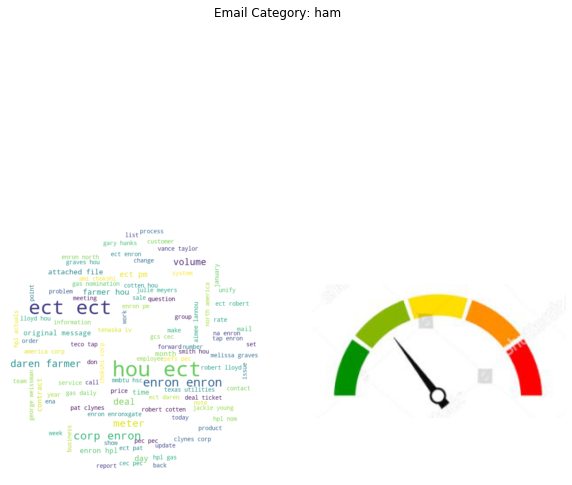

compound: 1.0, neg: 0.059, neu: 0.805, pos: 0.136, 


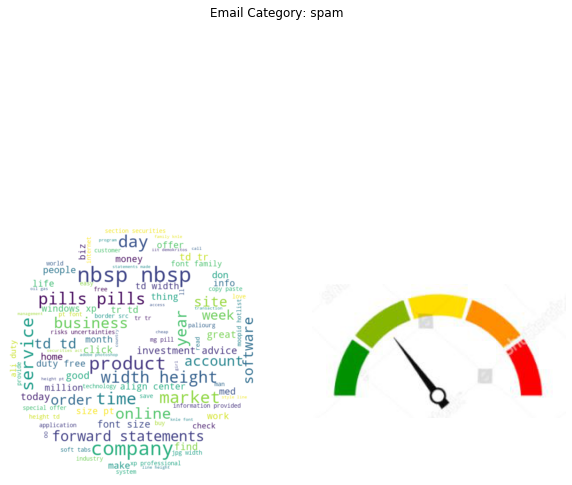

In [16]:
plt.rcParams["figure.figsize"] = (10,10)
for label in ['ham','spam']:
    temp_df=corpus_df[corpus_df.label==label]  
    label_df=pd.DataFrame()
    label_df['compound']=0.00
    label_df['neg']=0.000
    label_df['neu']=0.000
    label_df['pos']=0.000
    sid = SentimentIntensityAnalyzer()
     #print(sentence)
    sent=nltk.flatten(list(temp_df['bow']))
    ss = sid.polarity_scores(' '.join(sent))
    for k in sorted(ss):
        label_df.loc[index,label_df.columns.isin([k])]=ss[k]
        print('{}: {}, '.format(k, ss[k]), end='')
    print()
    
    fig, axes = plt.subplots(1, 2)
    wc=WordCloud(max_font_size=50, max_words=100, background_color="white",width = 250, height = 250,  mask=mask)
    wordcloud =wc.generate(' '.join(sent))
    fig.suptitle("Email Category: "+(label))
    axes[0].imshow(wc, interpolation="bilinear")
    if label_df.loc[index,'pos']-label_df.loc[index,'neg']>0:
        axes[1].imshow(mask_pos, cmap=plt.cm.gray, interpolation="bilinear")
    elif label_df.loc[index,'pos']-label_df.loc[index,'neg']<0:
        axes[1].imshow(mask_neg, cmap=plt.cm.gray, interpolation="bilinear")
    else:
        axes[1].imshow(mask_neu, cmap=plt.cm.gray, interpolation="bilinear")
    for ax in axes:
        ax.set_axis_off()
    plt.show()

### POS tagging in NLTK

In [17]:
# Lab Week 4 - POS tagging in NLTK
# This file has small examples that are meant to be run individually
#   in the Python shell

import nltk

# POS Tagged Corpora:  Brown and Penn Treebank
# the Brown corpus has its own set of POS tags
from nltk.corpus import brown
# the tagged_sents function gives POS tagged sentences and tagged_words gives POS tagged words
print(brown.tagged_sents()[:2], '\n')
print(brown.tagged_words()[:50])


# Each tagged word is a pair, which Python calls a tuple  
#  it behaves like a list except that you can't change the elements (immutable)
wordtag = brown.tagged_words()[0]
print(wordtag)
print(type(wordtag))
print(wordtag[0])
print(wordtag[1])

# the brown corpus can also be accessed by category
print(brown.categories(), '\n')

brown_humor_tagged = brown.tagged_words(categories='humor', tagset='universal')
print(brown_humor_tagged[:50])

# the chat corpus uses Penn POS tags
print(nltk.corpus.nps_chat.tagged_words()[:50])

# Penn treebank
from nltk.corpus import treebank

# use corpus methods to get the text as strings and as tokens as before
treebank_text = treebank.raw()
print(treebank_text[:150], '\n')

treebank_tokens = treebank.words()
print(treebank_tokens[:20])

# but we also have functions to get words with tags and sentences with tagged words
treebank_tagged_words = treebank.tagged_words()
print(treebank_tagged_words[:50])

treebank_tagged = treebank.tagged_sents()
print(treebank_tagged[:2])


## Frequency distribution of tags in Penn Treebank
tag_fd = nltk.FreqDist(tag for (word, tag) in treebank_tagged_words)
print(tag_fd.keys(), '\n')

for tag,freq in tag_fd.most_common():
    print (tag, freq)

# use the first letter of the POS tag to get classes of tags
tag_classes_fd = nltk.FreqDist(tag[0] for (word, tag) in treebank_tagged_words)
print(tag_classes_fd.keys(), '\n')
for tag,freq in tag_classes_fd.most_common():
    print (tag, freq)


## POS Tagging

# Separating the data into training and test data
size = int(len(treebank_tagged) * 0.9)
treebank_train = treebank_tagged[:size]
treebank_test = treebank_tagged[size:]

# Default Tagger assign 'NN' to every word
# creates the tagger
t0 = nltk.DefaultTagger('NN')
# show the effect of the tagger by tagging the first 50 words
print(t0.tag(treebank_tokens[:50]))

# evaluate function applies the tagger t0 to the untagged version of treebank
#   and compares with the tagged version
print(t0.evaluate(treebank_test))

# Unigram tagger learns tag with the highest probability for each word
# creates the tagger on the training set
t1 = nltk.UnigramTagger(treebank_train)
# show the effect of the tagger by tagging the first 50 words
print(t1.tag(treebank_tokens[:50]))

# evaluates the tagger on the test set
print(t1.evaluate(treebank_test))

# Bigram Tagging with Backoff to Combine Taggers
# create a sequence of taggers with backoff to get a bigram tagger
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(treebank_train, backoff=t0)
t2 = nltk.BigramTagger(treebank_train, backoff=t1)
# Accuracy with BigramTagger: 
print(t2.evaluate(treebank_test))

# Using the bigram tagger on some new text
text = "Three Calgarians have found a rather unusual way of leaving snow and ice behind. They set off this week on foot and by camels on a grueling trek across the burning Arabian desert."

# Unigram tagger learns tag with the highest probability for each word
# creates the tagger on the training set
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(treebank_tagged)
# show the effect of the tagger by tagging the first 50 words
print(t1.tag(treebank_tokens[:50]))

# evaluates the tagger on the test set
print(t1.evaluate(treebank_test))

# Bigram Tagging with Backoff to Combine Taggers
# create a sequence of taggers with backoff to get a bigram tagger
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(treebank_tagged, backoff=t0)
t2 = nltk.BigramTagger(treebank_tagged, backoff=t1)

# Accuracy with BigramTagger: 
print(t2.evaluate(treebank_test))

# But we should separate the text into sentences first
textsplit = nltk.sent_tokenize(text)
print(textsplit)

# apply the word tokenizer to each sentence
tokentext = [nltk.word_tokenize(sent) for sent in textsplit]
print(tokentext)

# use the t2 bigram tagger to tag each sentence tokens
taggedtext = [t2.tag(tokens) for tokens in tokentext]
print(taggedtext)


# use the Stanford POS tagger to tag each sentence tokens
taggedtextStanford = [nltk.pos_tag(tokens) for tokens in tokentext]
print(taggedtextStanford)

# show how to flatten a list of tagged tokens
taggedtext_flat = [pair for sent in taggedtext for pair in sent]
print(taggedtext_flat)

taggedtextStanford_flat = [pair for sent in taggedtextStanford for pair in sent]
print(taggedtextStanford_flat)


[[('The', 'AT'), ('Fulton', 'NP-TL'), ('County', 'NN-TL'), ('Grand', 'JJ-TL'), ('Jury', 'NN-TL'), ('said', 'VBD'), ('Friday', 'NR'), ('an', 'AT'), ('investigation', 'NN'), ('of', 'IN'), ("Atlanta's", 'NP$'), ('recent', 'JJ'), ('primary', 'NN'), ('election', 'NN'), ('produced', 'VBD'), ('``', '``'), ('no', 'AT'), ('evidence', 'NN'), ("''", "''"), ('that', 'CS'), ('any', 'DTI'), ('irregularities', 'NNS'), ('took', 'VBD'), ('place', 'NN'), ('.', '.')], [('The', 'AT'), ('jury', 'NN'), ('further', 'RBR'), ('said', 'VBD'), ('in', 'IN'), ('term-end', 'NN'), ('presentments', 'NNS'), ('that', 'CS'), ('the', 'AT'), ('City', 'NN-TL'), ('Executive', 'JJ-TL'), ('Committee', 'NN-TL'), (',', ','), ('which', 'WDT'), ('had', 'HVD'), ('over-all', 'JJ'), ('charge', 'NN'), ('of', 'IN'), ('the', 'AT'), ('election', 'NN'), (',', ','), ('``', '``'), ('deserves', 'VBZ'), ('the', 'AT'), ('praise', 'NN'), ('and', 'CC'), ('thanks', 'NNS'), ('of', 'IN'), ('the', 'AT'), ('City', 'NN-TL'), ('of', 'IN-TL'), ('Atlant

0.8905852417302799
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.'), ('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'JJ'), ('publishing', 'NN'), ('group', 'NN'), ('.', '.'), ('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT')]
0.96
0.9863613231552163
['Three Calgarians have found a rather unusual way of leaving snow and ice behind.', 'They set off this week on foot and by camels on

In [18]:
corpus_df['treebank_tag']=corpus_df['bow'].apply(lambda x: list(t2.tag(x)))
corpus_df['pos_tag']=corpus_df['bow'].apply(lambda x: list(nltk.pos_tag(x)))

In [19]:
corpus_df.loc[0,'treebank_tag']

[('christmas', 'NN'), ('tree', 'NN'), ('farm', 'NN'), ('pictures', 'NN')]

In [20]:
corpus_df.loc[0,'pos_tag']

[('christmas', 'NNS'), ('tree', 'VBP'), ('farm', 'NN'), ('pictures', 'NNS')]

In [21]:
## Frequency distribution of tags in Penn Treebank
tag_fd = nltk.FreqDist(tag for (word, tag) in [item for sublist in list(corpus_df['treebank_tag']) for item in sublist])
print(tag_fd.keys(), '\n')

for tag,freq in tag_fd.most_common():
    print (tag, freq)

# use the first letter of the POS tag to get classes of tags
tag_classes_fd = nltk.FreqDist(tag[0] for (word, tag) in  [item for sublist in list(corpus_df['pos_tag']) for item in sublist])
print(tag_classes_fd.keys(), '\n')
for tag,freq in tag_classes_fd.most_common():
    print (tag, freq)

dict_keys(['NN', 'NNS', 'JJ', 'JJR', 'VB', 'CD', 'VBZ', 'VBN', 'VBG', 'RB', 'VBD', 'VBP', 'LS', 'JJS', '-NONE-', 'IN', 'DT', 'RP', 'FW', 'CC', 'NNP', 'RBR', 'MD', 'PDT', '``', 'WDT']) 

NN 371119
CD 47594
NNS 22799
JJ 20607
VB 13762
VBN 9696
VBD 6208
VBG 5263
VBP 3858
RB 3606
VBZ 2231
-NONE- 1586
JJR 585
JJS 368
DT 133
`` 125
IN 124
FW 122
MD 71
LS 34
RP 34
NNP 31
CC 14
RBR 11
PDT 2
WDT 1
dict_keys(['N', 'V', 'J', 'C', 'R', 'F', '$', 'I', 'W', '(', ')', 'M', 'D', 'P', 'T', 'E', '`', "'"]) 

N 266593
C 83449
J 73114
V 72320
R 9962
I 2591
F 879
$ 296
T 217
` 125
M 103
) 91
W 82
( 82
P 38
D 37
E 4
' 1


In [22]:
corpus_df.head()

doc  \
0  ham/0001.1999-12-10.farmer.ham.txt   
1  ham/0002.1999-12-13.farmer.ham.txt   
2  ham/0003.1999-12-14.farmer.ham.txt   
3  ham/0004.1999-12-14.farmer.ham.txt   
4  ham/0005.1999-12-14.farmer.ham.txt   

                                                 bow label  compound    neg  \
0                  [christmas, tree, farm, pictures]   ham    0.0000  0.000   
1  [vastar, resources, gary, production, high, is...   ham   -0.9153  0.066   
2  [calpine, daily, gas, nomination, calpine, dai...   ham    0.0000  0.000   
3  [issue, fyi, note, stella, forwarded, stella, ...   ham    0.8689  0.000   
4  [meter, 7268, nov, allocation, fyi, forwarded,...   ham    0.5106  0.000   

     neu    pos                                       treebank_tag  \
0  1.000  0.000  [(christmas, NN), (tree, NN), (farm, NN), (pic...   
1  0.911  0.023  [(vastar, NN), (resources, NNS), (gary, NN), (...   
2  1.000  0.000  [(calpine, NN), (daily, JJ), (gas, NN), (nomin...   
3  0.902  0.098  [(issue, NN), (fyi, NN), (note, NN), (stella, ...   
4  0.945  0.055  [(meter, NN), (7268, NN), (nov, NN), (allocati...   

                                             pos_tag  
0  [(christmas, NNS), (tree, VBP), (farm, NN), (p...  
1  [(vastar, NN), (resources, NNS), (gary, JJ), (...  
2  [(calpine, JJ), (daily, JJ), (gas, NN), (nomin...  
3  [(issue, NN), (fyi, VBZ), (note, VBP), (stella...  
4  [(meter, NN), (7268, CD), (nov, JJ), (allocati...

## Step 2: The second step is to produce the features in the notation of the NLTK

In [98]:
# This coverts the df into a list of list
#corpus_df.loc[:,['bow','label']].values.tolist()

# To conver the DF results into a list of tuples
corpus_df_tuples=list(corpus_df.loc[:,['bow','label']].to_records(index=False))

In [99]:
import random

random.shuffle(corpus_df_tuples)
corpus_df_tuples[:1]

[(list(['meter', '1512', 'resolved', 'robert', 'volume', 'management', 'involved', 'november', 'robert', 'care', 'dec', 'input', 'ken', 'kimberly', 'vaughn', '12', '21', '99', '04', '17', 'pm', 'kenneth', 'seaman', 'hou', 'ect', 'ect', 'meter', '1512', 'vacation', 'week', 'note', 'wondering', 'helped', 'resolve', 'forwarded', 'kimberly', 'vaughn', 'hou', 'ect', '12', '21', '99', '03', '15', 'pm', 'kenneth', 'seaman', '12', '21', '99', '03', '28', 'pm', 'kimberly', 'vaughn', 'hou', 'ect', 'ect', 'meter', '1512', 'kimberly', 'vaughn', '12', '21', '99', '02', '12', 'pm', 'kenneth', 'seaman', 'hou', 'ect', 'ect', 'meter', '1512', 'ken', 'anthing', 'forwarded', 'kimberly', 'vaughn', 'hou', 'ect', '12', '21', '99', '01', '10', 'pm', 'kenneth', 'seaman', '12', '13', '99', '02', '19', 'pm', 'howard', 'camp', 'hou', 'ect', 'ect', 'kimberly', 'vaughn', 'hou', 'ect', 'ect', 'robert', 'lloyd', 'hou', 'ect', 'ect', 'meter', '1512', 'november', 'volume', 'applied', 'deal', '92963', 'fact', 'volume',

In [100]:
# We need to define the set of words that will be used for features.   we will limit the length of the 
# word features to 1500.

all_words_list = [word for (sent,cat) in corpus_df_tuples for word in sent]
all_words = nltk.FreqDist(all_words_list)
word_items = all_words.most_common(1500)
word_features = [word for (word, freq) in word_items]

In [101]:
word_items[:5]

[('ect', 13900), ('hou', 7289), ('enron', 6555), ('2000', 4386), ('gas', 3034)]

### Baseline Feature (Unigram)

In [102]:
# As before, the word feature labels will be ‘V_keyword)’ for each keyword (aka word) in the word_features set, 
# and the value of the feature will be Boolean,  according to whether the word is contained in that document.

def document_features(document, word_features):
	document_words = set(document)
	features = {}
	for word in word_features:
		features['V_{}'.format(word)] = (word in document_words)
	return features

In [103]:
random.shuffle(corpus_df_tuples)

In [104]:
# Define the feature sets for the documents. 
featuresets = [(document_features(d,word_features), c) for (d,c) in corpus_df_tuples]
len(featuresets)


5171

In [105]:
featuresets[0:1]

[({'V_ect': False,
   'V_hou': False,
   'V_enron': False,
   'V_2000': False,
   'V_gas': False,
   'V_3': False,
   'V_deal': True,
   'V_1': False,
   'V_meter': False,
   'V_00': False,
   'V_2': True,
   'V_pm': False,
   'V_hpl': False,
   'V_000': True,
   'V_10': False,
   'V_2001': True,
   'V_daren': False,
   'V_01': False,
   'V_corp': False,
   'V_0': False,
   'V_4': False,
   'V_5': False,
   'V_11': False,
   'V_mmbtu': False,
   'V_12': False,
   'V_forwarded': False,
   'V_http': False,
   'V_03': False,
   'V_price': False,
   'V_company': False,
   'V_information': False,
   'V_farmer': False,
   'V_attached': False,
   'V_7': False,
   'V_99': False,
   'V_6': False,
   'V_02': True,
   'V_day': False,
   'V_time': False,
   'V_message': False,
   'V_9': False,
   'V_04': False,
   'V_30': False,
   'V_contract': False,
   'V_20': False,
   'V_volume': True,
   'V_8': False,
   'V_mail': False,
   'V_robert': False,
   'V_05': False,
   'V_month': False,
   'V_sita

In [106]:
train_set, test_set = featuresets[1000:], featuresets[:1000]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))


0.941


In [107]:
# The function show_most_informative_features shows the top ranked features according to the ratio of one
# label to the other one.  For example, if there are 20 times as many positive documents containing this word as negative ones,
# then the ratio will be reported as     20.00: 1.00   pos:neg.

classifier.show_most_informative_features(30)

Most Informative Features
             V_forwarded = True              ham : spam   =    193.4 : 1.0
                   V_hou = True              ham : spam   =    182.7 : 1.0
          V_prescription = True             spam : ham    =    137.4 : 1.0
                   V_nom = True              ham : spam   =    123.7 : 1.0
                  V_pain = True             spam : ham    =    115.7 : 1.0
                   V_ect = True              ham : spam   =    113.3 : 1.0
                  V_2001 = True              ham : spam   =    105.3 : 1.0
                  V_2005 = True             spam : ham    =     95.8 : 1.0
                V_health = True             spam : ham    =     84.1 : 1.0
                   V_bob = True              ham : spam   =     81.0 : 1.0
                   V_sex = True             spam : ham    =     79.1 : 1.0
                  V_spam = True             spam : ham    =     75.8 : 1.0
           V_medications = True             spam : ham    =     75.8 : 1.0

In [108]:
# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))



In [109]:
# First we build the reference and test lists from the classifier on the test set, but we will call them the gold list and 
#the predicted list.

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))

# We can look at the first 30 examples and think about whether the corresponding elements of the last match.

print(goldlist[:30])
print(predictedlist[:30])


['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']
['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']


In [110]:
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

 
# (row = gold; col = predicted)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <63.8%>  5.5% |
spam |   0.4% <30.3%>|
-----+---------------+
(row = reference; col = test)



In [111]:
# Now we can call this function on our data.

eval_measures(goldlist, predictedlist)

# This gives us more information into the performance of the model for each label.  
# We can see that the ‘neg’ label is predicted with higher precision, .75,
# while the ‘pos’ label is predicted with higher recall, .738.


	Precision	Recall		F1
spam 	      0.987      0.846      0.911
ham 	      0.921      0.994      0.956


In [112]:
print(accuracy_score(goldlist, predictedlist)) 
print(precision_score(goldlist, predictedlist, average="weighted"))
print(recall_score(goldlist, predictedlist, average="weighted")) 
print(f1_score(goldlist, predictedlist, average="weighted"))
print(classification_report(goldlist, predictedlist))
results.loc[0,'model']="Unigram Feature set"
results.loc[0,'accuracy_score']=accuracy_score(goldlist, predictedlist)
results.loc[0,'precision_score']=precision_score(goldlist, predictedlist, average="weighted")
results.loc[0,'recall_score']=recall_score(goldlist, predictedlist, average="weighted")
results.loc[0,'f1_score']=f1_score(goldlist, predictedlist, average="weighted")

0.941
0.9485174385213804
0.941
0.9421354397229027
              precision    recall  f1-score   support

         ham       0.99      0.92      0.96       693
        spam       0.85      0.99      0.91       307

    accuracy                           0.94      1000
   macro avg       0.92      0.95      0.93      1000
weighted avg       0.95      0.94      0.94      1000



### Bigram Feature

In [113]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()


In [114]:
# We create a bigram collocation finder using the original movie review words, since the bigram finder must have the words 
# in order.  Note that our all_words_list has exactly this list.

all_words_list[:50]
finder = BigramCollocationFinder.from_words(all_words_list)

In [115]:
# We use the chi-squared measure to get bigrams that are informative features.  
# Note that we don’t need to get the scores of the bigrams, so we use the nbest function which just returns the highest scoring 
# bigrams, using the number specified. (Or try bigram_measures.raw_freq.)

bigram_features = finder.nbest(bigram_measures.chi_sq, 500)

In [116]:
# The nbest function returns a list of significant bigrams in this corpus, and we can look at some of them.

print(bigram_features[:50])

# We are going to use these bigrams as features in a new features function.  In order to test if any bigram in the 
# bigram_features list is in the document, we need to generate the bigrams of the document, which we do using the 
# nltk.bigrams function.  To show this, we define a sentence and show the bigrams.

sent = ['Arthur','carefully','rode','the','brown','horse','around','the','castle']
sentbigrams = list(nltk.bigrams(sent))
sentbigrams


[('\x11', '63884831'), ('00020608', 'twcnka'), ('0027', 'volpe'), ('01405', 'wffur'), ('0184', 'bowy'), ('03090806', '02010207'), ('036474336', 'transalta'), ('038', '500681'), ('04005', 'jnkex'), ('0424040', 'ftar'), ('04607001', 'easttrans'), ('064', 'gtsa'), ('0688', '105631'), ('09050804', '00020608'), ('092', 'alwando'), ('0920', '8774937918'), ('0980805', '0980877'), ('0980877', '0980803'), ('0986511', 'huff'), ('0989708', 'swyka'), ('1007', '9415'), ('1010', 'liverpool'), ('1012', '6934'), ('102372', '2423'), ('103745', '342'), ('104256', '104738'), ('104355', '104001'), ('104975', '104256'), ('10939', '7876'), ('113858', '93779'), ('114099', '92918'), ('1147', 'lousis'), ('1163', '1135'), ('11669', 'kbmu'), ('118532', '101473'), ('1225', 'ingleside'), ('12278', 'hnbgd'), ('123395', '95394'), ('124972', '72047'), ('125827', '125828'), ('126289', '9757'), ('126360', '6742'), ('128285', '2174'), ('13035', '9736'), ('131054', '131048'), ('1328', 'jejohnson'), ('134755', '251650'), 

[('Arthur', 'carefully'),
 ('carefully', 'rode'),
 ('rode', 'the'),
 ('the', 'brown'),
 ('brown', 'horse'),
 ('horse', 'around'),
 ('around', 'the'),
 ('the', 'castle')]

In [117]:
# For any one bigram, we can test if it is in the bigrams of the sentence and we can use string formatting, 
# with two occurrences of {}s, to insert the two words of the bigram into the name of the feature.

bigram = ('brown','horse')
print(bigram in sentbigrams)
print('B_{}_{}'.format(bigram[0], bigram[1]))

# Now we create a feature extraction function that has all the word features as before, but also has bigram features.

def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
    return features



True
B_brown_horse


In [118]:
# Now we create feature sets as before, but using this feature extraction function.

bigram_featuresets = [(bigram_document_features(d,word_features,bigram_features), c) for (d,c) in corpus_df_tuples]

#There should be 2000 features:  1500 word features and 500 bigram features

len(bigram_featuresets[0][0].keys())

train_set, test_set = bigram_featuresets[1000:], bigram_featuresets[:1000]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

# So in my random training, test split, the bigrams did not improve the classification for this data.  
# But there are many classification tasks for which bigrams are important.


0.941


In [119]:
# First we build the reference and test lists from the classifier on the test set, but we will call them the gold list and 
#the predicted list.

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))

# We can look at the first 30 examples and think about whether the corresponding elements of the last match.

print(goldlist[:30])
print(predictedlist[:30])


['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']
['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']


In [120]:
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

 
# (row = gold; col = predicted)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <63.8%>  5.5% |
spam |   0.4% <30.3%>|
-----+---------------+
(row = reference; col = test)



In [121]:
# Now we can call this function on our data.

eval_measures(goldlist, predictedlist)

# This gives us more information into the performance of the model for each label.  
# We can see that the ‘neg’ label is predicted with higher precision, .75,
# while the ‘pos’ label is predicted with higher recall, .738.


	Precision	Recall		F1
spam 	      0.987      0.846      0.911
ham 	      0.921      0.994      0.956


In [122]:
print(accuracy_score(goldlist, predictedlist)) 
print(precision_score(goldlist, predictedlist, average="weighted"))
print(recall_score(goldlist, predictedlist, average="weighted")) 
print(f1_score(goldlist, predictedlist, average="weighted"))
print(classification_report(goldlist, predictedlist))
results.loc[1,'model']="Bigram Feature set"
results.loc[1,'accuracy_score']=accuracy_score(goldlist, predictedlist)
results.loc[1,'precision_score']=precision_score(goldlist, predictedlist, average="weighted")
results.loc[1,'recall_score']=recall_score(goldlist, predictedlist, average="weighted")
results.loc[1,'f1_score']=f1_score(goldlist, predictedlist, average="weighted")

0.941
0.9485174385213804
0.941
0.9421354397229027
              precision    recall  f1-score   support

         ham       0.99      0.92      0.96       693
        spam       0.85      0.99      0.91       307

    accuracy                           0.94      1000
   macro avg       0.92      0.95      0.93      1000
weighted avg       0.95      0.94      0.94      1000



### POS Feature

In [123]:
# Observing the Stanford POS tagger, which is the default in NLTK, on a sentence:
print(sent)
print(nltk.pos_tag(sent))


['Arthur', 'carefully', 'rode', 'the', 'brown', 'horse', 'around', 'the', 'castle']
[('Arthur', 'NNP'), ('carefully', 'RB'), ('rode', 'VBD'), ('the', 'DT'), ('brown', 'JJ'), ('horse', 'NN'), ('around', 'IN'), ('the', 'DT'), ('castle', 'NN')]


In [124]:
# Here is the definition of our new feature function, adding POS tag counts to the word features.

def POS_features(document):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features


In [125]:
# Try out the POS features.
POS_featuresets = [(POS_features(d), c) for (d, c) in corpus_df_tuples]
# number of features for document 0
len(POS_featuresets[0][0].keys())

# Show the first sentence in your (randomly shuffled) documents and look at its POS tag features.

print(corpus_df_tuples[0])
# the pos tag features for this sentence
print('num nouns', POS_featuresets[0][0]['nouns'])
print('num verbs', POS_featuresets[0][0]['verbs'])
print('num adjectives', POS_featuresets[0][0]['adjectives'])
print('num adverbs', POS_featuresets[0][0]['adverbs'])

# Now split into training and test and rerun the classifier.
train_set, test_set = POS_featuresets[1000:], POS_featuresets[:1000]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

#This improved classification a small amount for my train/test split.




(list(['tenaska', 'iv', 'march', '2001', 'actuals', 'txu', 'tenaska', 'iv', 'march', '2001', 'receipt', 'williams', 'money', 'recoup', 'williams', 'repay', 'tenaska', 'iv', 'change', 'deals', 'questions', 'deal', '384258', 'change', 'demand', 'fee', '2', '653', '694', '95', '2', '607', '176', '02', 'deal', '514353', 'change', 'volume', '45', '000', '44', '590', 'megan']), 'ham')
num nouns 18
num verbs 5
num adjectives 3
num adverbs 0


0.945

In [126]:
# First we build the reference and test lists from the classifier on the test set, but we will call them the gold list and 
#the predicted list.

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))

# We can look at the first 30 examples and think about whether the corresponding elements of the last match.

print(goldlist[:30])
print(predictedlist[:30])


['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']
['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']


In [127]:
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

 
# (row = gold; col = predicted)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <64.1%>  5.2% |
spam |   0.3% <30.4%>|
-----+---------------+
(row = reference; col = test)



In [128]:
# Now we can call this function on our data.

eval_measures(goldlist, predictedlist)

# This gives us more information into the performance of the model for each label.  
# We can see that the ‘neg’ label is predicted with higher precision, .75,
# while the ‘pos’ label is predicted with higher recall, .738.


	Precision	Recall		F1
spam 	      0.990      0.854      0.917
ham 	      0.925      0.995      0.959


In [129]:
print(accuracy_score(goldlist, predictedlist)) 
print(precision_score(goldlist, predictedlist, average="weighted"))
print(recall_score(goldlist, predictedlist, average="weighted")) 
print(f1_score(goldlist, predictedlist, average="weighted"))
print(classification_report(goldlist, predictedlist))
results.loc[2,'model']="POS Feature set"
results.loc[2,'accuracy_score']=accuracy_score(goldlist, predictedlist)
results.loc[2,'precision_score']=precision_score(goldlist, predictedlist, average="weighted")
results.loc[2,'recall_score']=recall_score(goldlist, predictedlist, average="weighted")
results.loc[2,'f1_score']=f1_score(goldlist, predictedlist, average="weighted")

0.945
0.9519290425012212
0.945
0.9460245749528163
              precision    recall  f1-score   support

         ham       1.00      0.92      0.96       693
        spam       0.85      0.99      0.92       307

    accuracy                           0.94      1000
   macro avg       0.92      0.96      0.94      1000
weighted avg       0.95      0.94      0.95      1000



### Adding Features from a Sentiment Lexicon

### Sentiment Lexicon:  Subjectivity Count features

In [130]:
# Module Subjectivity reads the subjectivity lexicon file from Wiebe et al
#    at http://www.cs.pitt.edu/mpqa/ (part of the Multiple Perspective QA project)
#
# This file has the format that each line is formatted as in this example for the word "abandoned"
#     type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
# In our data, the pos tag is ignored, so this program just takes the last one read
#     (typically the noun over the adjective)
#
# The data structure that is created is a dictionary where
#    each word is mapped to a list of 4 things:  
#        strength, which will be either 'strongsubj' or 'weaksubj'
#        posTag, either 'adj', 'verb', 'noun', 'adverb', 'anypos'
#        isStemmed, either true or false
#        polarity, either 'positive', 'negative', or 'neutral'

import nltk

# pass the absolute path of the lexicon file to this program
# example call:
SLpath = "C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\Week8\\subjclueslen1-hltemnlp05\\subjclueslen1-HLTEMNLP05.tff"


# this function returns a dictionary where you can look up words and get back 
#     the four items of subjectivity information described above
def readSubjectivity(path):
    flexicon = open(path, 'r')
    # initialize an empty dictionary
    sldict = { }
    for line in flexicon:
        fields = line.split()   # default is to split on whitespace
        # split each field on the '=' and keep the second part as the value
        strength = fields[0].split("=")[1]
        word = fields[2].split("=")[1]
        posTag = fields[3].split("=")[1]
        stemmed = fields[4].split("=")[1]
        polarity = fields[5].split("=")[1]
        if (stemmed == 'y'):
            isStemmed = True
        else:
            isStemmed = False
        # put a dictionary entry with the word as the keyword
        #     and a list of the other values
        sldict[word] = [strength, posTag, isStemmed, polarity]
    return sldict



In [131]:
# Now run the function that reads the file.  It creates a Subjectivity Lexicon that is represented here as a dictionary, 
# where each word is mapped to a list containing the strength, POStag, whether it is stemmed and the polarity.  
# (See more details in the Subjectivity.py file.)
SL = readSubjectivity(SLpath)


In [132]:
# Now the variable SL (for Subjectivity Lexicon) is a dictionary where you can look up words and find the strength, POS tag,
# whether it is stemmed and polarity.  We can try out some words.
SL['absolute']
SL['shabby']
# Or we can use the Python multiple assignment to get the 4 items:
strength, posTag, isStemmed, polarity = SL['absolute']


In [133]:
def SL_features(document, SL, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
        # count variables for the 4 classes of subjectivity
        weakPos = 0
        strongPos = 0
        weakNeg = 0
        strongNeg = 0
        for word in document_words:
            if word in SL:
                strength, posTag, isStemmed, polarity = SL[word]
                if strength == 'weaksubj' and polarity == 'positive':
                    weakPos += 1
                if strength == 'strongsubj' and polarity == 'positive':
                    strongPos += 1
                if strength == 'weaksubj' and polarity == 'negative':
                    weakNeg += 1
                if strength == 'strongsubj' and polarity == 'negative':
                    strongNeg += 1
                features['positivecount'] = weakPos + (2 * strongPos)
                features['negativecount'] = weakNeg + (2 * strongNeg)      
    return features


In [134]:
# Now we create feature sets as before, but using this feature extraction function.

SL_featuresets = [(SL_features(d, SL,word_features), c) for (d,c) in corpus_df_tuples]


In [135]:
# features in document 0
print(SL_featuresets[0][0]['positivecount'])

print(SL_featuresets[0][0]['negativecount'])

print(SL_featuresets[0][1])

train_set, test_set = SL_featuresets[1000:], SL_featuresets[:1000]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

3
0
ham
0.944


In [136]:
# First we build the reference and test lists from the classifier on the test set, but we will call them the gold list and 
#the predicted list.

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))

# We can look at the first 30 examples and think about whether the corresponding elements of the last match.

print(goldlist[:30])
print(predictedlist[:30])


['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']
['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']


In [137]:
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

 
# (row = gold; col = predicted)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <63.8%>  5.5% |
spam |   0.1% <30.6%>|
-----+---------------+
(row = reference; col = test)



In [138]:
# Now we can call this function on our data.

eval_measures(goldlist, predictedlist)

# This gives us more information into the performance of the model for each label.  
# We can see that the ‘neg’ label is predicted with higher precision, .75,
# while the ‘pos’ label is predicted with higher recall, .738.


	Precision	Recall		F1
spam 	      0.997      0.848      0.916
ham 	      0.921      0.998      0.958


In [139]:
print(accuracy_score(goldlist, predictedlist)) 
print(precision_score(goldlist, predictedlist, average="weighted"))
print(recall_score(goldlist, predictedlist, average="weighted")) 
print(f1_score(goldlist, predictedlist, average="weighted"))
print(classification_report(goldlist, predictedlist))
results.loc[3,'model']="SL Feature set"
results.loc[3,'accuracy_score']=accuracy_score(goldlist, predictedlist)
results.loc[3,'precision_score']=precision_score(goldlist, predictedlist, average="weighted")
results.loc[3,'recall_score']=recall_score(goldlist, predictedlist, average="weighted")
results.loc[3,'f1_score']=f1_score(goldlist, predictedlist, average="weighted")

0.944
0.952142639772151
0.944
0.9451283379187569
              precision    recall  f1-score   support

         ham       1.00      0.92      0.96       693
        spam       0.85      1.00      0.92       307

    accuracy                           0.94      1000
   macro avg       0.92      0.96      0.94      1000
weighted avg       0.95      0.94      0.95      1000



### Adding Negation Features 

In [140]:

negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', \
                 'rarely', 'seldom', 'neither', 'nor']

# remove some negation words 
negationwords.extend(['ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'])


In [141]:
# One strategy with negation words is to negate the word following the negation word
#   other strategies negate all words up to the next punctuation
# Strategy is to go through the document words in order adding the word features,
#   but if the word follows a negation words, change the feature to negated word
# Start the feature set with all 2000 word features and 2000 Not word features set to false
def NOT_features(document, word_features, negationwords):
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        else:
            features['V_{}'.format(word)] = (word in word_features)
    return features


In [142]:
# Create feature sets as before, using the NOT_features extraction funtion, train the classifier and test the accuracy.
NOT_featuresets = [(NOT_features(d, word_features, negationwords), c) for (d, c) in corpus_df_tuples]
#print(NOT_featuresets[0][0]['V_NOTcare'])
#print(NOT_featuresets[0][0]['V_always'])

train_set, test_set = NOT_featuresets[1000:], NOT_featuresets[:1000]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

# classifier.show_most_informative_features(30)


0.939


In [143]:
# First we build the reference and test lists from the classifier on the test set, but we will call them the gold list and 
#the predicted list.

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))

# We can look at the first 30 examples and think about whether the corresponding elements of the last match.

print(goldlist[:30])
print(predictedlist[:30])


['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']
['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']


In [144]:
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

 
# (row = gold; col = predicted)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <63.2%>  6.1% |
spam |      . <30.7%>|
-----+---------------+
(row = reference; col = test)



In [145]:
# Now we can call this function on our data.

eval_measures(goldlist, predictedlist)

# This gives us more information into the performance of the model for each label.  
# We can see that the ‘neg’ label is predicted with higher precision, .75,
# while the ‘pos’ label is predicted with higher recall, .738.


	Precision	Recall		F1
spam 	      1.000      0.834      0.910
ham 	      0.912      1.000      0.954


In [146]:
print(accuracy_score(goldlist, predictedlist)) 
print(precision_score(goldlist, predictedlist, average="weighted"))
print(recall_score(goldlist, predictedlist, average="weighted")) 
print(f1_score(goldlist, predictedlist, average="weighted"))
print(classification_report(goldlist, predictedlist))
results.loc[4,'model']="Negation Feature set"
results.loc[4,'accuracy_score']=accuracy_score(goldlist, predictedlist)
results.loc[4,'precision_score']=precision_score(goldlist, predictedlist, average="weighted")
results.loc[4,'recall_score']=recall_score(goldlist, predictedlist, average="weighted")
results.loc[4,'f1_score']=f1_score(goldlist, predictedlist, average="weighted")

0.939
0.9491114130434782
0.939
0.9403521453529001
              precision    recall  f1-score   support

         ham       1.00      0.91      0.95       693
        spam       0.83      1.00      0.91       307

    accuracy                           0.94      1000
   macro avg       0.92      0.96      0.93      1000
weighted avg       0.95      0.94      0.94      1000



### Additional Feature (TFIDF)

In [147]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        if bagOfWordsCount==0:
            tfDict[word] = 0
        else:
            tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    #for word, val in idfDict.items():
     #   idfDict[word] = math.log(N / float(val))
    return idfDict

def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [148]:
corpus_df_tuples[1]

(list(['valero', 'marketing', 'supply', '{', 'pasadena', '}', 'meter', '1394', 'sitara', '148396', 'fyi', 'presently', 'scheduled', '10', '0', 'buyback', 'interconnect', 'due', 'plant', 'status', 'day', 'day', '10', '0', 'buyback', 'begun', 'wednesday', 'april', '5', 'gary', 'interconnect', 'allocated', '{', 'force', 'majeure', 'sitara', '148390', '}']), 'ham')

In [149]:
uniqueWords=set()
for doc,label in corpus_df_tuples:
    uniqueWords = set(uniqueWords).union(set(doc))

In [150]:
print(len(uniqueWords))
list(uniqueWords)[:5]

50044


['patsy', 'supra', 'heftige', 'avtech', 'documenting']

In [151]:
bow_list =[]

for bow,label in corpus_df_tuples: 
    bow_list.append(' '.join(bow))


In [152]:
bow_list[2]

'kenney song sat 24 apr 2004 09 50 03 0600 sir madam mor tg age application received yesterday glad confirm application accepted low 3 fixed rate fill final details complete forward hearing sincerely graham temple mor tg age broker association rem www lifeisimportant biz meger diucggx lsjtzht zmpem rapjvrz ykrnvxzr ogzqe wgkcanq tgtgpkmpo wmpbwdioe gkdiaz ganrdo rajqmlgf tpfcesai ogcbovdt elhswgg sbyskqmhr womaetud zfesp kowjb ntbqefbvs dyuwdgkb rzrmkei fdqzqvq zfrvfe dleln zsvigw zwmdjvr ypdnevxst hbwugmzl syvutgf pkpzztlc kndndfq kwqlab gmijdnp fnqtc smripvbb xhiaxwso dotnauesn llqwzg wuzecm zbwjdljyh fexryo qialb rpoogjk xyzle ktwbfnu rgnawbx wgjezsmte nurhdak sosucett ghvpmapc ljotd fexepom tpbqnlzxi kyvelxsp zqonsvu xjznjekik wzztiwpm kuremquo qxuct jpafoked qrbojk vgtpelonm gcjbjuc gkbhe xrhfp coheqzqfs afcozrxxc qrxvdiww ovonoyg faxmernhp rrnrwuwb qxixcbk ndrsr pupoda piwdi riupyik ztljrg itzdzeezb mwvwh gkqdgdgjq vgvbuvj qqjatg samah yubntd txjftsb koprer jruyrv maysvvqj vdiwjh

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(bow_list)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [173]:
df['label']=corpus_df.label
df.head()

00       000  0000  000000  000000000002858  000000000049773  000080  \
0  0.0  0.072532   0.0     0.0              0.0              0.0     0.0   
1  0.0  0.000000   0.0     0.0              0.0              0.0     0.0   
2  0.0  0.000000   0.0     0.0              0.0              0.0     0.0   
3  0.0  0.000000   0.0     0.0              0.0              0.0     0.0   
4  0.0  0.421756   0.0     0.0              0.0              0.0     0.0   

   000099  0001  00018  ...  zynve  zyqtaqlt  zyrtec  zyyqywp  zzezrjok  zzn  \
0     0.0   0.0    0.0  ...    0.0       0.0     0.0      0.0       0.0  0.0   
1     0.0   0.0    0.0  ...    0.0       0.0     0.0      0.0       0.0  0.0   
2     0.0   0.0    0.0  ...    0.0       0.0     0.0      0.0       0.0  0.0   
3     0.0   0.0    0.0  ...    0.0       0.0     0.0      0.0       0.0  0.0   
4     0.0   0.0    0.0  ...    0.0       0.0     0.0      0.0       0.0  0.0   

   zzo  zzocb  zzso  zzsyt  
0  0.0    0.0   0.0    0.0  
1  0.0    0.0   0.0    0.0  
2  0.0    0.0   0.0    0.0  
3  0.0    0.0   0.0    0.0  
4  0.0    0.0   0.0    0.0  

[5 rows x 49978 columns]

In [178]:
from sklearn.model_selection import train_test_split

TrainDF, TestDF = train_test_split(df, test_size=0.3)

TrainDF_nolabels=TrainDF.drop(["label"], axis=1)
TestDF_nolabels=TestDF.drop(["label"], axis=1)


TrainLabels=pd.to_numeric(TestDF["label"].apply(lambda x: "".join('0' if x=='ham' else '1'  )))
TestLabels=pd.to_numeric(TestDF["label"].apply(lambda x: "".join('0' if x=='ham' else '1'  )))

In [180]:
from sklearn.naive_bayes import MultinomialNB

#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.fit
#Create the modeler
MyModelNB= MultinomialNB()
## When you look up this model, you learn that it wants the 
## DF seperate from the labels

print(TrainLabels)
MyModelNB.fit(TrainDF_nolabels, TrainLabels)
Prediction = MyModelNB.predict(TestDF_nolabels)
print("The prediction from NB is:")
print(Prediction)
print("The actual labels are:")
print(TestLabels)

cnf_matrix = confusion_matrix(TestLabels, Prediction)
print("The confusion matrix is:")
print(cnf_matrix)


4662    1
3797    1
944     0
4213    1
1100    0
       ..
4652    1
4538    1
268     0
1318    0
4088    1
Name: label, Length: 1552, dtype: int64


ValueError: Found input variables with inconsistent numbers of samples: [3619, 1552]

### All Features in one set (unigrams, bigrams, POS tag counts, and sentiment word counts )

In [155]:
def all_features(document, word_features, bigram_features,SL):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    # Unigram Features
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    
    # Bigram Features
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
    
    # POS Features
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    
    # SL Features
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
        # count variables for the 4 classes of subjectivity
        weakPos = 0
        strongPos = 0
        weakNeg = 0
        strongNeg = 0

        for word in document_words:
            if word in SL:
                strength, posTag, isStemmed, polarity = SL[word]
                if strength == 'weaksubj' and polarity == 'positive':
                    weakPos += 1
                if strength == 'strongsubj' and polarity == 'positive':
                    strongPos += 1
                if strength == 'weaksubj' and polarity == 'negative':
                    weakNeg += 1
                if strength == 'strongsubj' and polarity == 'negative':
                    strongNeg += 1
                features['positivecount'] = weakPos + (2 * strongPos)
                features['negativecount'] = weakNeg + (2 * strongNeg)    
            
    return features



In [156]:
all_featuresets = [(all_features(d,word_features,bigram_features,SL), c) for (d,c) in corpus_df_tuples]

# features in document 0
print('num nouns', all_featuresets[0][0]['nouns'])
print('num verbs', all_featuresets[0][0]['verbs'])
print('num adjectives', all_featuresets[0][0]['adjectives'])
print('num adverbs', all_featuresets[0][0]['adverbs'])

print(all_featuresets[0][0]['positivecount'])
print(all_featuresets[0][0]['negativecount'])
print(all_featuresets[0][1])



num nouns 18
num verbs 5
num adjectives 3
num adverbs 0
3
0
ham


In [157]:
# Now split into training and test and rerun the classifier.
train_set, test_set = all_featuresets[1000:], all_featuresets[:1000]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.942

In [158]:
# First we build the reference and test lists from the classifier on the test set, but we will call them the gold list and 
#the predicted list.

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))

# We can look at the first 30 examples and think about whether the corresponding elements of the last match.

print(goldlist[:30])
print(predictedlist[:30])


['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']
['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham']


In [159]:
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

 
# (row = gold; col = predicted)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <63.7%>  5.6% |
spam |   0.2% <30.5%>|
-----+---------------+
(row = reference; col = test)



In [160]:
# Now we can call this function on our data.

eval_measures(goldlist, predictedlist)

# This gives us more information into the performance of the model for each label.  
# We can see that the ‘neg’ label is predicted with higher precision, .75,
# while the ‘pos’ label is predicted with higher recall, .738.


	Precision	Recall		F1
spam 	      0.993      0.845      0.913
ham 	      0.919      0.997      0.956


In [161]:

print(accuracy_score(goldlist, predictedlist)) 
print(precision_score(goldlist, predictedlist, average="weighted"))
print(recall_score(goldlist, predictedlist, average="weighted")) 
print(f1_score(goldlist, predictedlist, average="weighted"))
print(classification_report(goldlist, predictedlist))
results.loc[5,'model']="All Feature set"
results.loc[5,'accuracy_score']=accuracy_score(goldlist, predictedlist)
results.loc[5,'precision_score']=precision_score(goldlist, predictedlist, average="weighted")
results.loc[5,'recall_score']=recall_score(goldlist, predictedlist, average="weighted")
results.loc[5,'f1_score']=f1_score(goldlist, predictedlist, average="weighted")

0.942
0.950207717217432
0.942
0.9431686357015698
              precision    recall  f1-score   support

         ham       1.00      0.92      0.96       693
        spam       0.84      0.99      0.91       307

    accuracy                           0.94      1000
   macro avg       0.92      0.96      0.93      1000
weighted avg       0.95      0.94      0.94      1000



### The Evaluation Method of Cross-Validation

In [81]:
subset_size = len(featuresets)//10
i=0
print(subset_size,i)


517 0


In [82]:
def cross_validation(num_folds, featuresets):
    subset_size = len(featuresets)//num_folds
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[i*subset_size:][:subset_size]
        train_this_round = featuresets[:i*subset_size]+featuresets[(i+1)*subset_size:]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print(i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print('mean accuracy', sum(accuracy_list) / num_folds)

In [83]:
# Run the cross-validation on our word feature sets with 10 folds.
cross_validation(10, featuresets)
# Instead of accuracy, we should have a cross-validation function to report precision and recall for each label.


0 0.9535783365570599
1 0.9187620889748549
2 0.9535783365570599
3 0.9497098646034816
4 0.941972920696325
5 0.9458413926499033
6 0.9555125725338491
7 0.9323017408123792
8 0.9535783365570599
9 0.9458413926499033
mean accuracy 0.9450676982591878


In [84]:
# Run the cross-validation on our word bigram feature sets with 10 folds.
cross_validation(10, bigram_featuresets)

0 0.9535783365570599
1 0.9187620889748549
2 0.9535783365570599
3 0.9497098646034816
4 0.941972920696325
5 0.9458413926499033
6 0.9555125725338491
7 0.9323017408123792
8 0.9535783365570599
9 0.9458413926499033
mean accuracy 0.9450676982591878


In [85]:
# Run the cross-validation on our word POS feature sets with 10 folds.
cross_validation(10, POS_featuresets)

0 0.9574468085106383
1 0.9206963249516441
2 0.9574468085106383
3 0.9439071566731141
4 0.9381044487427466
5 0.9516441005802708
6 0.9574468085106383
7 0.9323017408123792
8 0.9632495164410058
9 0.9497098646034816
mean accuracy 0.9471953578336556


In [86]:
# Run the cross-validation on our word SL feature sets with 10 folds.
cross_validation(10, SL_featuresets)

0 0.9535783365570599
1 0.9187620889748549
2 0.9497098646034816
3 0.9477756286266924
4 0.9400386847195358
5 0.9497098646034816
6 0.9574468085106383
7 0.9303675048355899
8 0.9516441005802708
9 0.9477756286266924
mean accuracy 0.9446808510638297


In [87]:
# Run the cross-validation on our word Negation feature sets with 10 folds.
cross_validation(10, NOT_featuresets)

0 0.9477756286266924
1 0.9148936170212766
2 0.9497098646034816
3 0.9361702127659575
4 0.9303675048355899
5 0.9477756286266924
6 0.9574468085106383
7 0.9129593810444874
8 0.9458413926499033
9 0.9439071566731141
mean accuracy 0.9386847195357833


In [88]:
# Run the cross-validation on all feature sets with 10 folds.
cross_validation(10, all_featuresets)

0 0.9555125725338491
1 0.9187620889748549
2 0.9516441005802708
3 0.9477756286266924
4 0.9400386847195358
5 0.9477756286266924
6 0.9593810444874274
7 0.9303675048355899
8 0.9555125725338491
9 0.9477756286266924
mean accuracy 0.9454545454545453


### Evaluation Measures:  Precision, Recall and F1

In [89]:
# First we build the reference and test lists from the classifier on the test set, but we will call them the gold list and 
#the predicted list.

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))

# We can look at the first 30 examples and think about whether the corresponding elements of the last match.

print(goldlist[:30])
print(predictedlist[:30])

# Now we use the NLTK function to define the confusion matrix, and we print it out:


['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham']
['spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham']


In [90]:
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

 
# (row = gold; col = predicted)

     |             s |
     |      h      p |
     |      a      a |
     |      m      m |
-----+---------------+
 ham | <65.3%>  5.8% |
spam |   0.3% <28.6%>|
-----+---------------+
(row = reference; col = test)



In [91]:
# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))



In [92]:
# Now we can call this function on our data.

eval_measures(goldlist, predictedlist)

# This gives us more information into the performance of the model for each label.  
# We can see that the ‘neg’ label is predicted with higher precision, .75,
# while the ‘pos’ label is predicted with higher recall, .738.


	Precision	Recall		F1
spam 	      0.990      0.831      0.904
ham 	      0.918      0.995      0.955


## Step 3: Experiments

In [162]:
results

model  accuracy_score  precision_score  recall_score  \
5       All Feature set           0.942         0.950208         0.942   
0   Unigram Feature set           0.941         0.948517         0.941   
1    Bigram Feature set           0.941         0.948517         0.941   
2       POS Feature set           0.945         0.951929         0.945   
3        SL Feature set           0.944         0.952143         0.944   
4  Negation Feature set           0.939         0.949111         0.939   

   f1_score  
5  0.943169  
0  0.942135  
1  0.942135  
2  0.946025  
3  0.945128  
4  0.940352

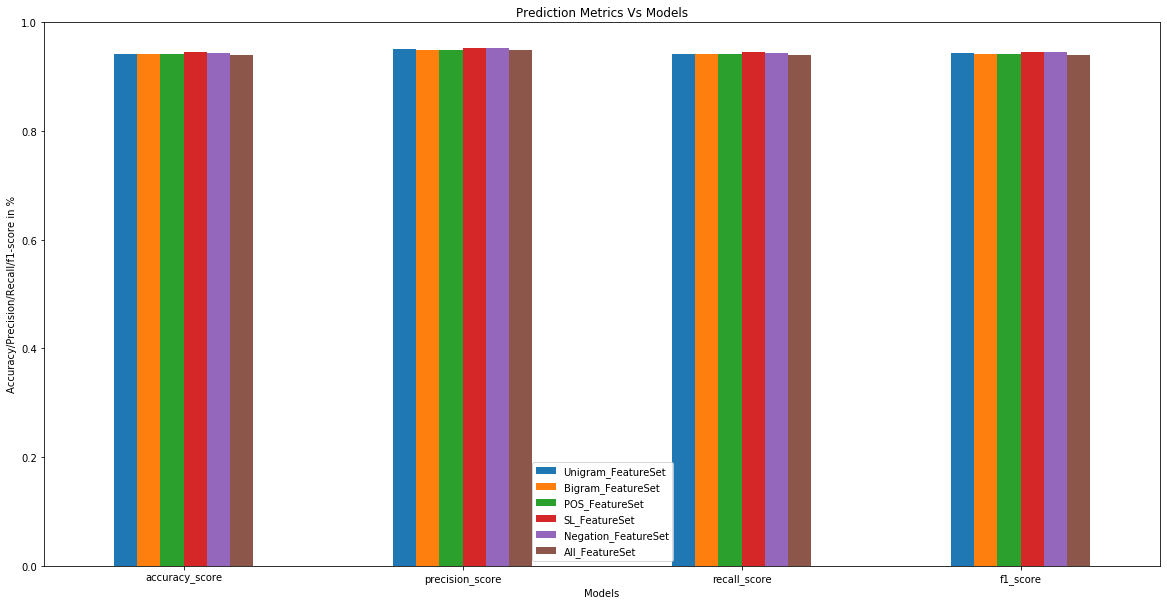

In [164]:
plt.rcParams["figure.figsize"] = (20,10)
Unigram_FeatureSet = results.T.iloc[1:5,0]
Bigram_FeatureSet =results.T.iloc[1:5,1]
POS_FeatureSet = results.T.iloc[1:5,2]
SL_FeatureSet = results.T.iloc[1:5,3]
Negation_FeatureSet = results.T.iloc[1:5,4]
All_FeatureSet = results.T.iloc[1:5,5]

index = ['accuracy_score', 'precision_score', 'recall_score',
         'f1_score']
df = pd.DataFrame({'Unigram_FeatureSet': Unigram_FeatureSet,
                   'Bigram_FeatureSet': Bigram_FeatureSet,
                   'POS_FeatureSet': POS_FeatureSet,
                   'SL_FeatureSet': SL_FeatureSet,
                   'Negation_FeatureSet': Negation_FeatureSet,
                   'All_FeatureSet': All_FeatureSet}, index=index)
ax = df.plot.bar(rot=0)
#bar = ax.bar(x=df.index.values, y=MultinomialNB,height=1)

ax.set_ylim(0,1)
ax.set_title('Prediction Metrics Vs Models')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy/Precision/Recall/f1-score in %')
#plt.plot(ax)
plt.show()